# Introduction

In this notebook, my capstone project for General Assembly's Data Science Immersive, I will explore an anonymized dataset of Instacart customers (accessed via https://www.kaggle.com/c/instacart-market-basket-analysis/data) and then derive features to fit a model that will predict which previously ordered items will be in customers' next order. I will then analyze the performance of the model and draw next steps for improving model performance.

Dimitri Linde, July 2017

### Table of Contents

- [EDA](#eda)
    - [Ordering Behavior](#ordering-behavior)
    - [Most Ordered Products](#most-ordered-products)
    - [Reorder Rate](#reorder-rate)
    - [Orders Without Reordered Products](#orders-without-reordered-products)
    

- [Generating Features](#generating-features)
    - [The Feature Graveyard](#the-feature-graveyard)


- [Testing The Model](#testing-the-model)
    - [Model With Customers With 10 or More Orders](#model-2)
    - [Model With Customers With Less Than 10 Orders](#model-1)
    - [Local Validation](#local-validation)


- [Analyzing Residuals](#analyzing-residuals)
    - [Converting The Output](#converting-the-output)
    - [Creating Missed, Wrong, and Correct Dataframes](#creating-dataframes)
    - [Analyzing Users With Less Than 10 Orders](#less-than-10)
    - [Analyzing Users with 10 or More Orders](#10-or-more)


- [Conclusion](#conclusion)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
order_products_train = pd.read_csv("./order_products_train.csv")
orders = pd.read_csv("./orders.csv")
products = pd.read_csv("./products.csv")
aisles = pd.read_csv("./aisles.csv")
departments = pd.read_csv("./departments.csv")
order_products_prior = pd.read_csv("./order_products_prior.csv")

<a id="eda"></a>
# EDA

<a id="ordering-behavior"></a>
### Ordering Behavior

For all 206,209 users in the Instacart dataset, there are 3 to 99 prior orders which are stored in the prior order set. These prior orders sum to over 3.2 million orders. The last order of each user - meaning between each users' 4th and 100th order - is divided into the train and test orders. There are 75,000 orders allocated to the testing split and the remaining 131209 in a training split. The prior and training orders contain the items in each order; the test orders do not.

In [3]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [4]:
unique_users = orders.groupby("eval_set")["user_id"].nunique()
unique_users

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

A plurality of users in the prior orders dataset ordered products from Instacart 4 times. There is a steadily diminishing number of customers as the number of orders per customer increases, with an uptick at 100 orders, the cap in the dataset.

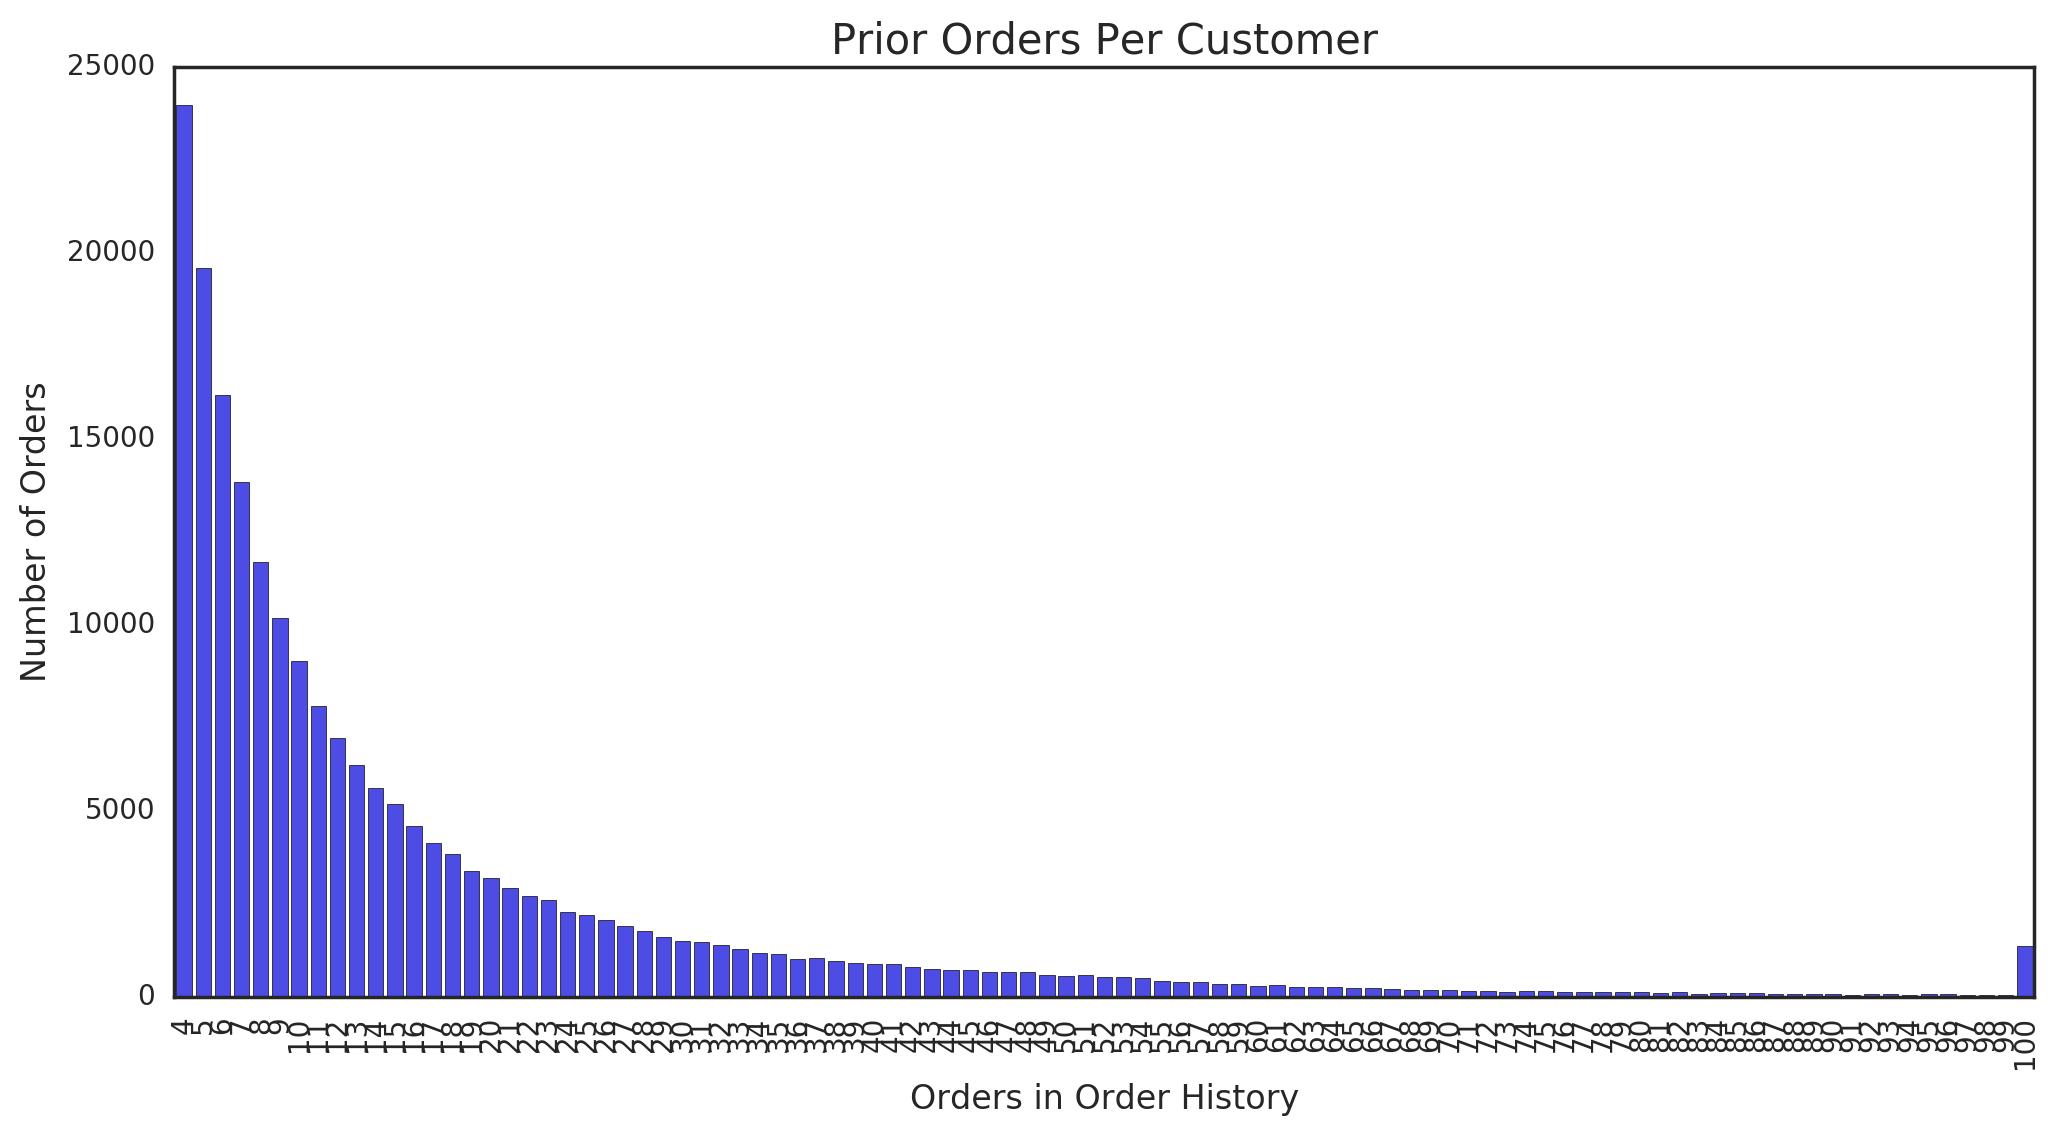

In [5]:
orders_per_user = orders.groupby("user_id")["order_number"].max().reset_index()
orders_per_user = orders_per_user['order_number'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(orders_per_user.index, orders_per_user.values, alpha=0.8, color='blue')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Orders in Order History', fontsize=12)
plt.title('Prior Orders Per Customer', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

The modal number of products per customer order is 5 and the median number of products 8. I've capped these number of items per order at 51 here, though a handful of outlier orders contain more products. After peaking at 5-6 items, each incremental number of products in an order occurs less frequently than orders with fewer products.

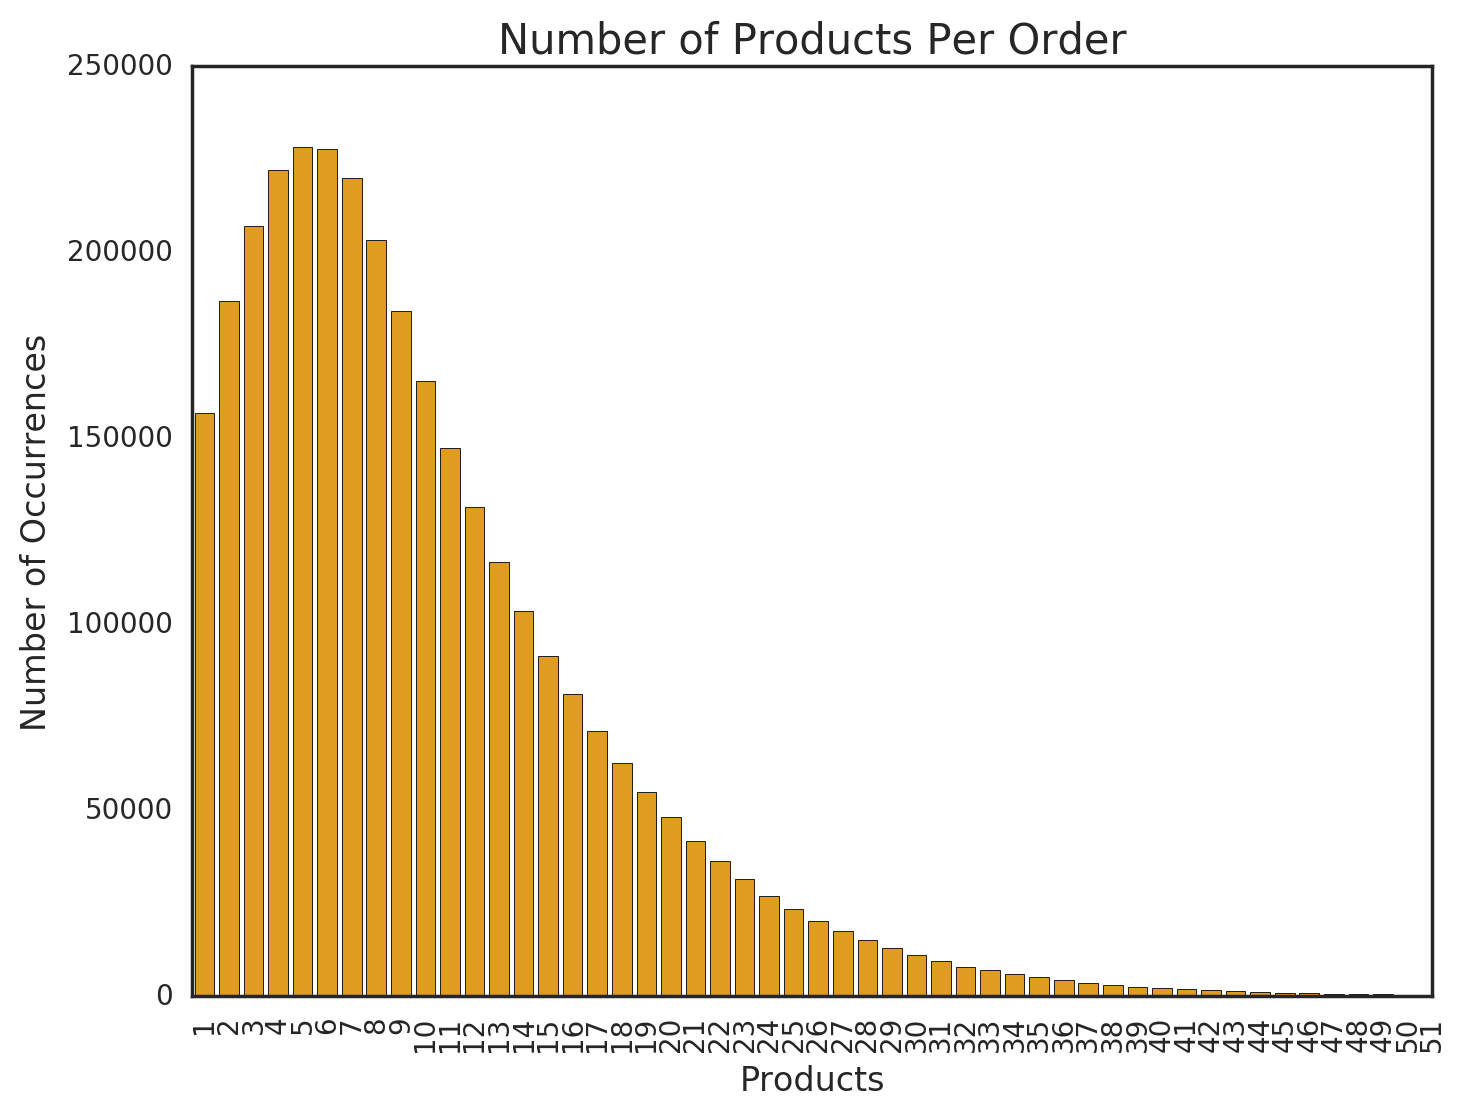

In [6]:
products_per = order_products_prior.groupby("order_id")["add_to_cart_order"].max().reset_index()
products_per = products_per['add_to_cart_order'].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(products_per.index, products_per.values, color='orange')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Products', fontsize=12)
plt.title('Number of Products Per Order', fontsize=15)
plt.xlim(xmax=50)
plt.xticks(rotation='vertical')
plt.show()

Orders are 30-40% more likely to occur on Sunday or Monday than another day of the week.

In [56]:
def make_day(num):
    if num==0:
        return('Sunday')
    elif num==1:
        return('Monday')
    elif num==2:
        return('Tuesday')
    elif num==3:
        return('Wednesday')
    elif num==4:
        return('Thursday')
    elif num==5:
        return('Friday')
    else:
        return('Saturday')


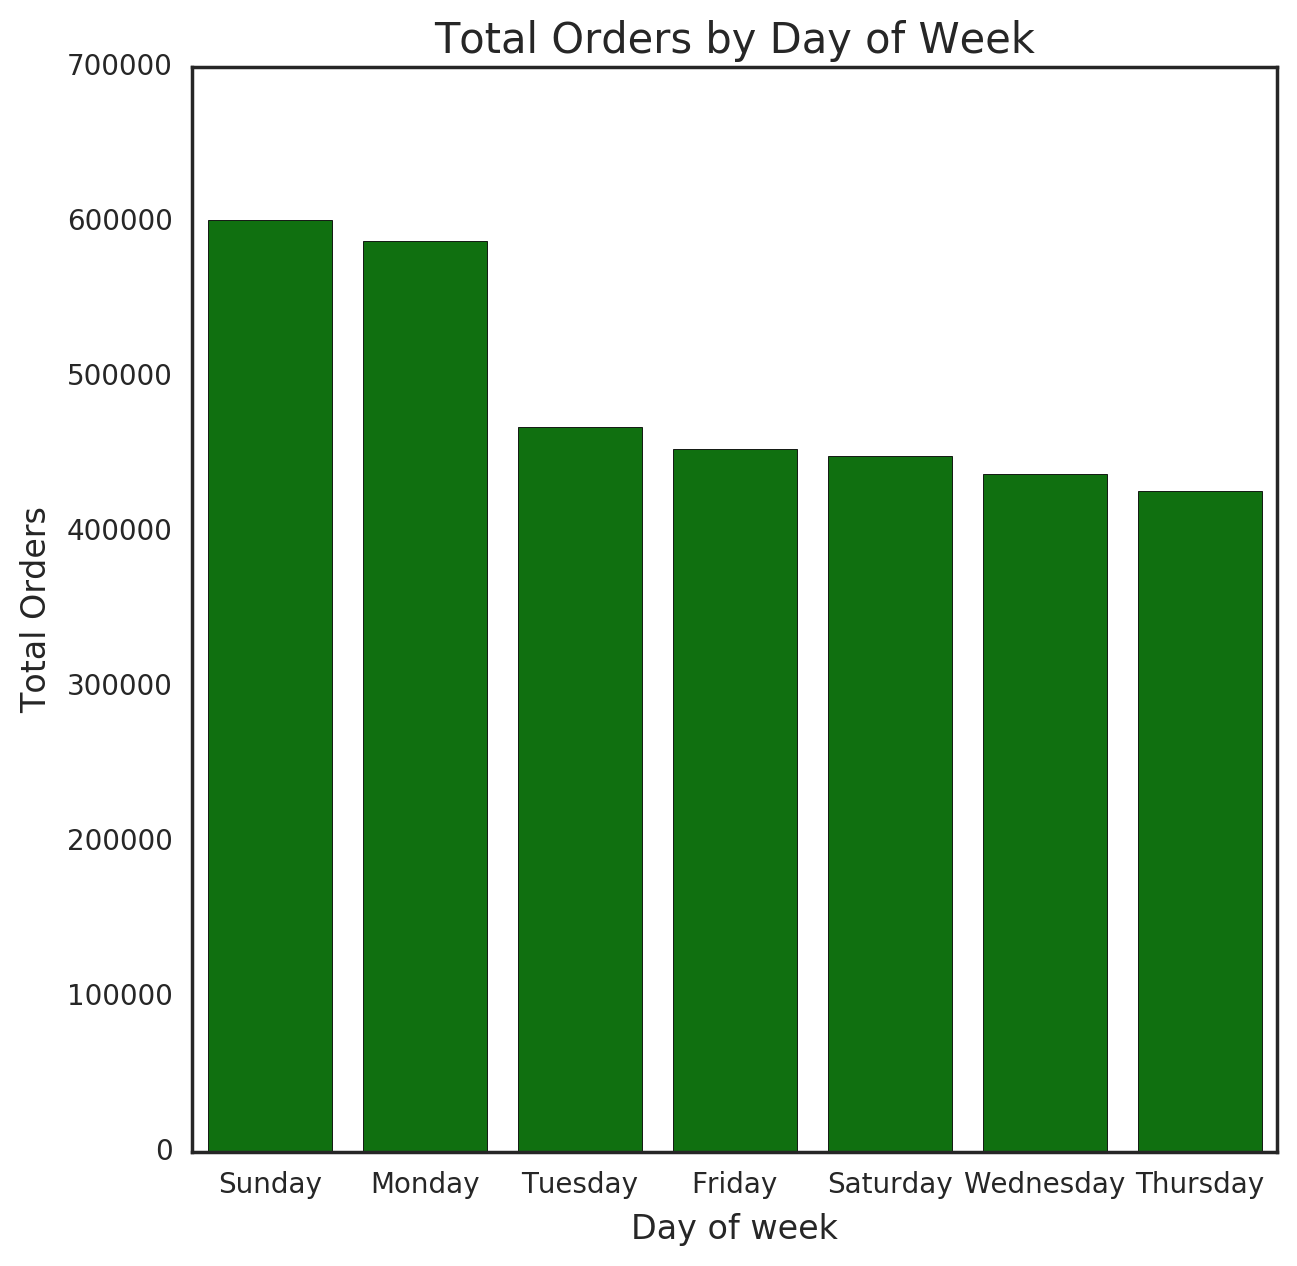

In [57]:
orders['order_dow'] = orders['order_dow'].map(make_day)
dow = orders.groupby('order_dow')[['order_id']].count().reset_index()
dow = dow.sort_values('order_id',ascending=False)
plt.figure(figsize=(7,7))
sns.barplot(x='order_dow', y='order_id', data=dow, color='green')
plt.ylabel('Total Orders', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title("Total Orders by Day of Week", fontsize=15)
plt.show()

Order volume is concentrated between late morning and late afternoon. There is more modest early morning and late evening ordering and then dramatic tapering in the small hours.

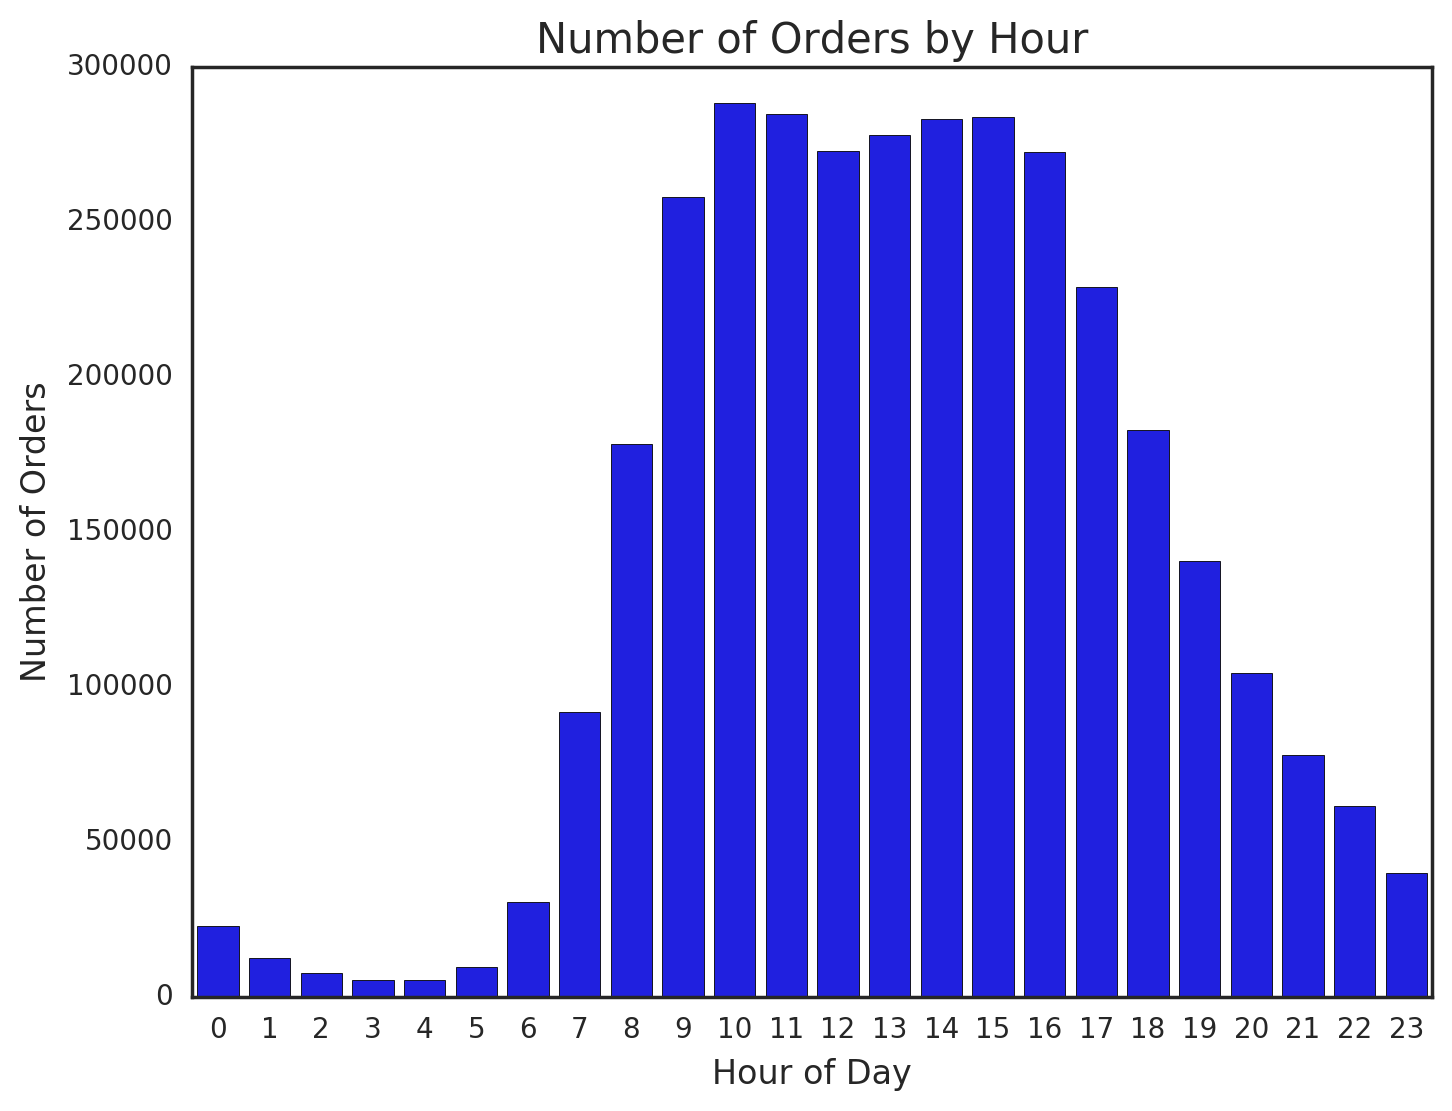

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(x="order_hour_of_day", data=orders, color='blue')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Hour of Day', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title("Number of Orders by Hour", fontsize=15)
plt.show()

About half of customer orders occur within a week after a given customer’s previous order. Order volume generally increases each day following a customers previous order for a week and then tapers, with exceptions for reliable bumps each 7-day interval. The high volume of orders 30 days after a previous order is almost certainly due to any order made 30 days or longer after the previous order being coded as 30 days.

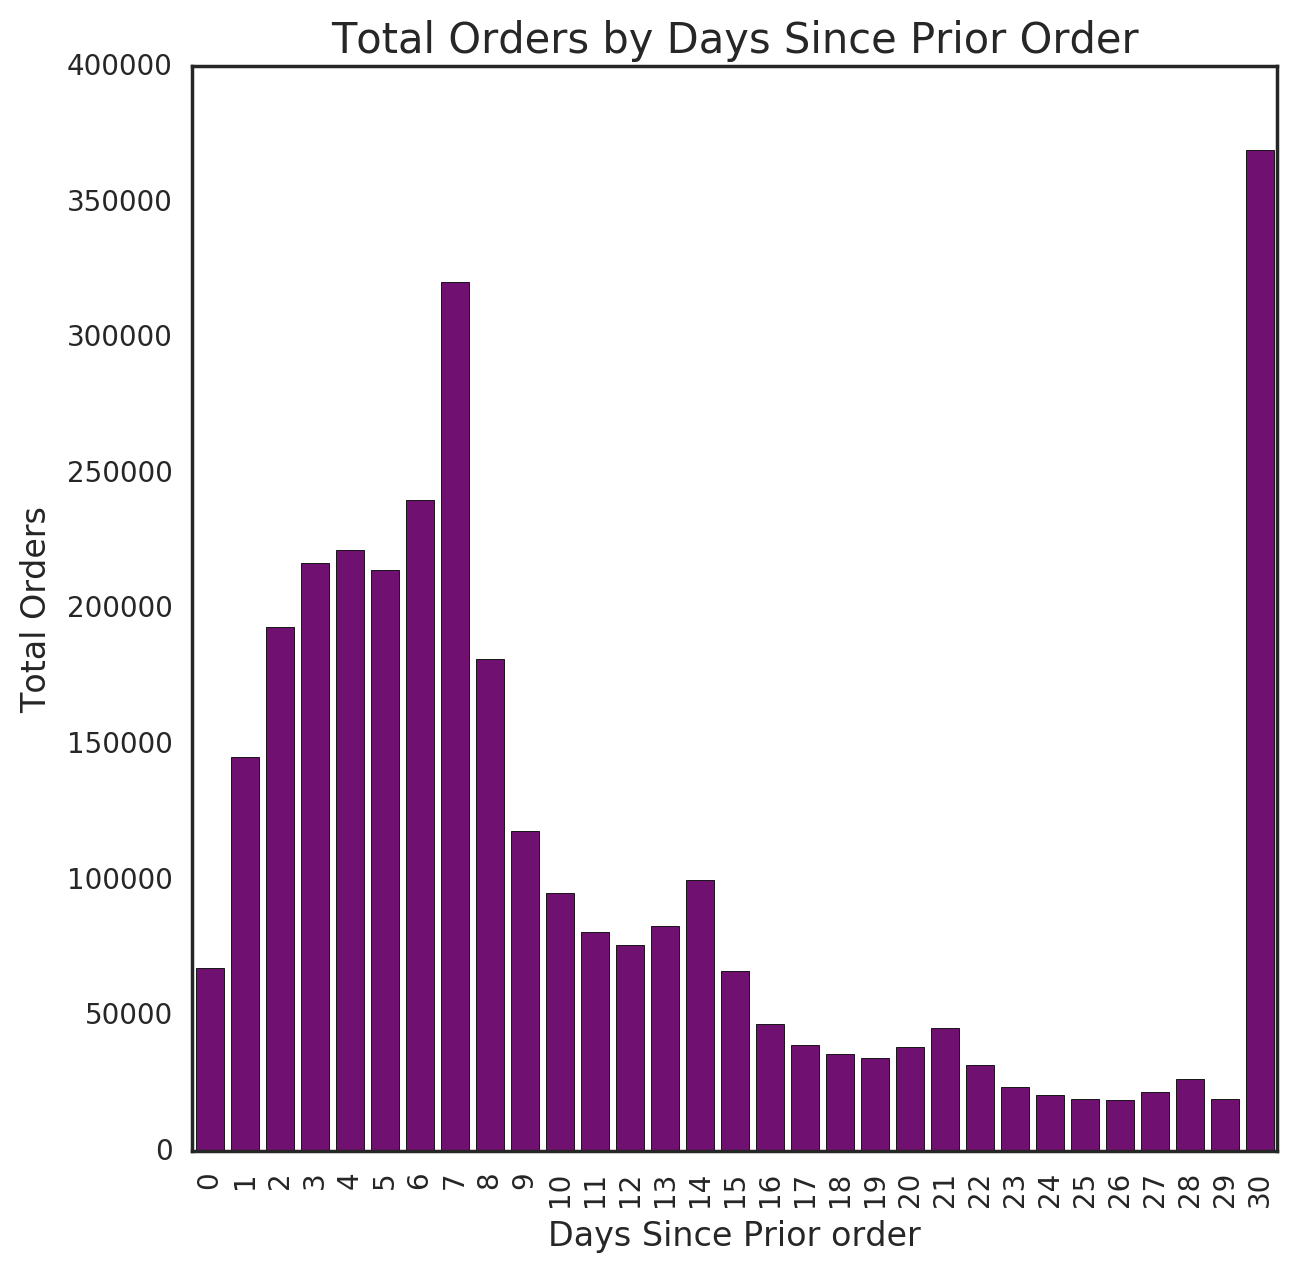

In [10]:
sample = orders[orders['days_since_prior_order'].notnull()]
sample['days_since_prior_order'] = sample['days_since_prior_order'].map(lambda x: int(x))
plt.figure(figsize=(7,7))
sns.countplot(x="days_since_prior_order", data=sample, color='purple')
plt.ylabel('Total Orders', fontsize=12)
plt.xlabel('Days Since Prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Total Orders by Days Since Prior Order", fontsize=15)
plt.show()

Prefacing my examination of the most ordered products, there is no product quantity in the previously ordered products table and no product appears more than once per order. This means the number of products sold must significantly understate the true number of products sold through the orders in the dataset.

In [11]:
duplicates = order_products_prior.groupby(['order_id','product_id'])[['product_id']].count()
duplicates.columns = ['count']
duplicates = duplicates.reset_index()
print('Number of instances of an item having a quanity greater than one in an order: ' + 
      str(len(duplicates[duplicates['count']>1])))

Number of instances of an item having a quanity greater than one in an order: 0


<a id="most-ordered-products"></a>
### Most Ordered Products

In [26]:
opp = pd.merge(order_products_prior, products, on='product_id',how='inner')
opp = pd.merge(opp, departments, on='department_id',how='inner')
opp = pd.merge(opp, aisles, on='aisle_id',how='inner')

More than 29% of products sold by Instacart in the dataset originate in the produce department, a striking number. For my part, I’m not discerning about which can or jar I select, but I‘m far more particular about the ripeness and condition of fruits and vegetables, a task Instacart customers entrust with the service’s employees. Though produce dominates sales, the dairy, snacks, beverages, and frozen foods departments also account for at least 2 million items of 32 million items sold.

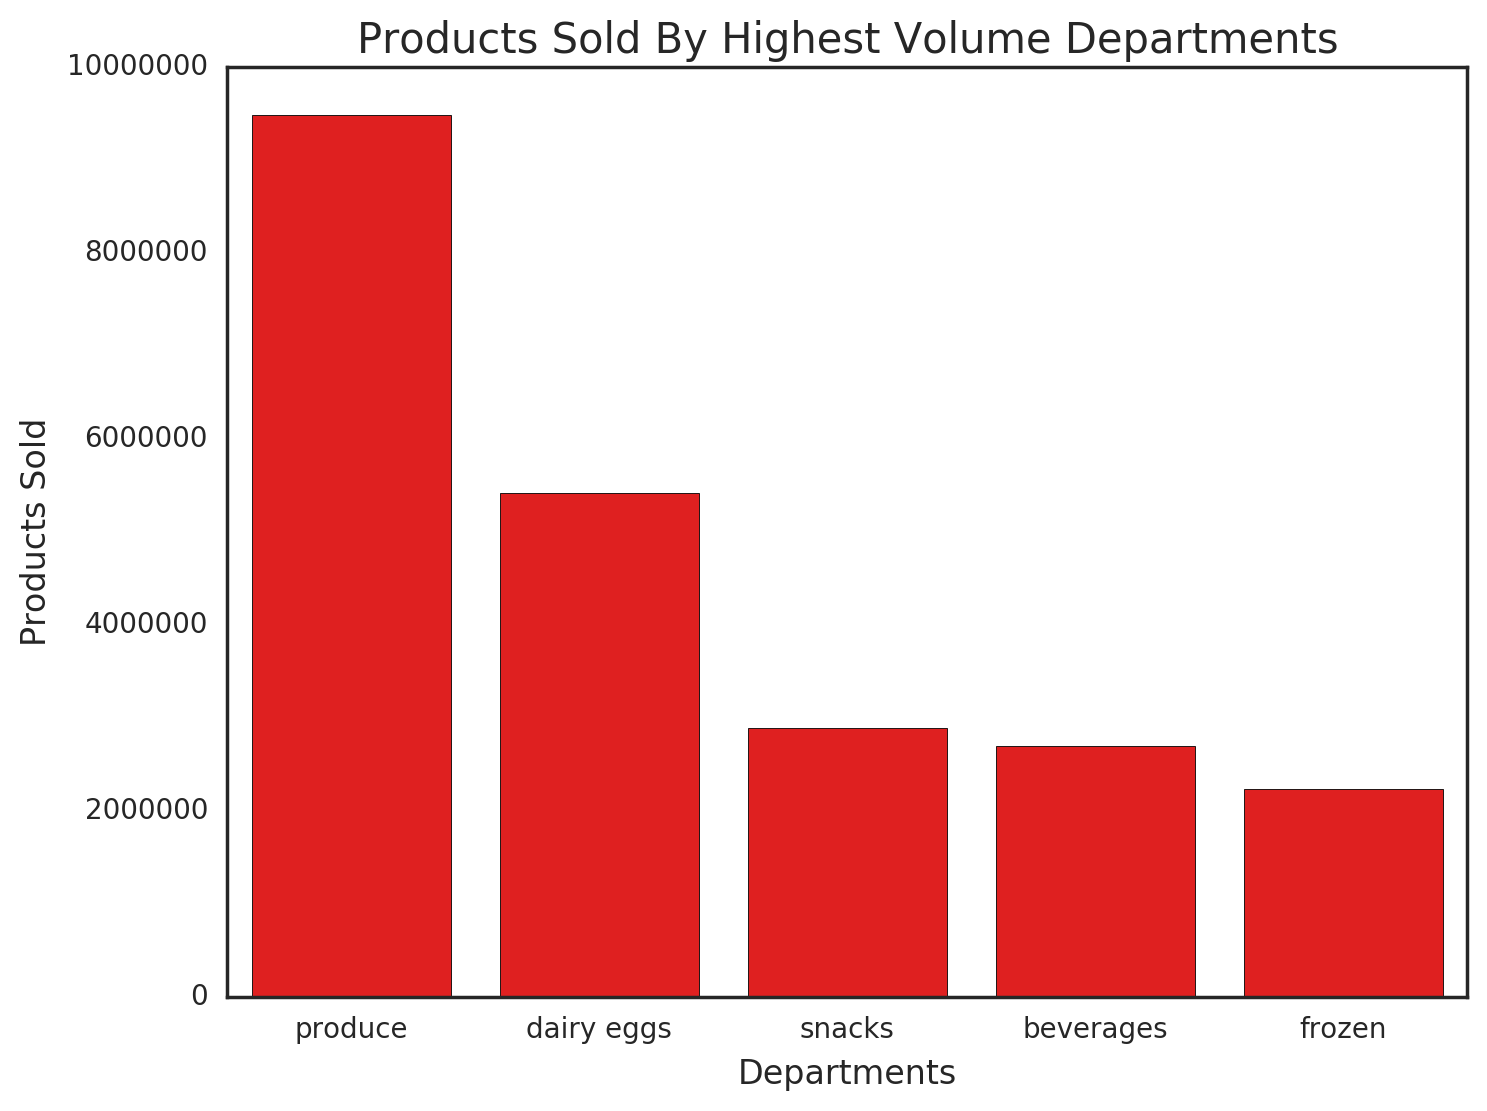

In [27]:
dept_freq = opp['department'].value_counts().head(5)
plt.figure(figsize=(8,6))
ax = sns.barplot(dept_freq.index, dept_freq.values, color='red')
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.ylabel('Products Sold', fontsize=12)
plt.xlabel('Departments', fontsize=12)
plt.title('Products Sold By Highest Volume Departments', fontsize=15)
plt.show()

Instacart customers far less frequently order pet and bulk products with the service, those departments accounting for roughly 100,000 and 40,000 sales, respectively.

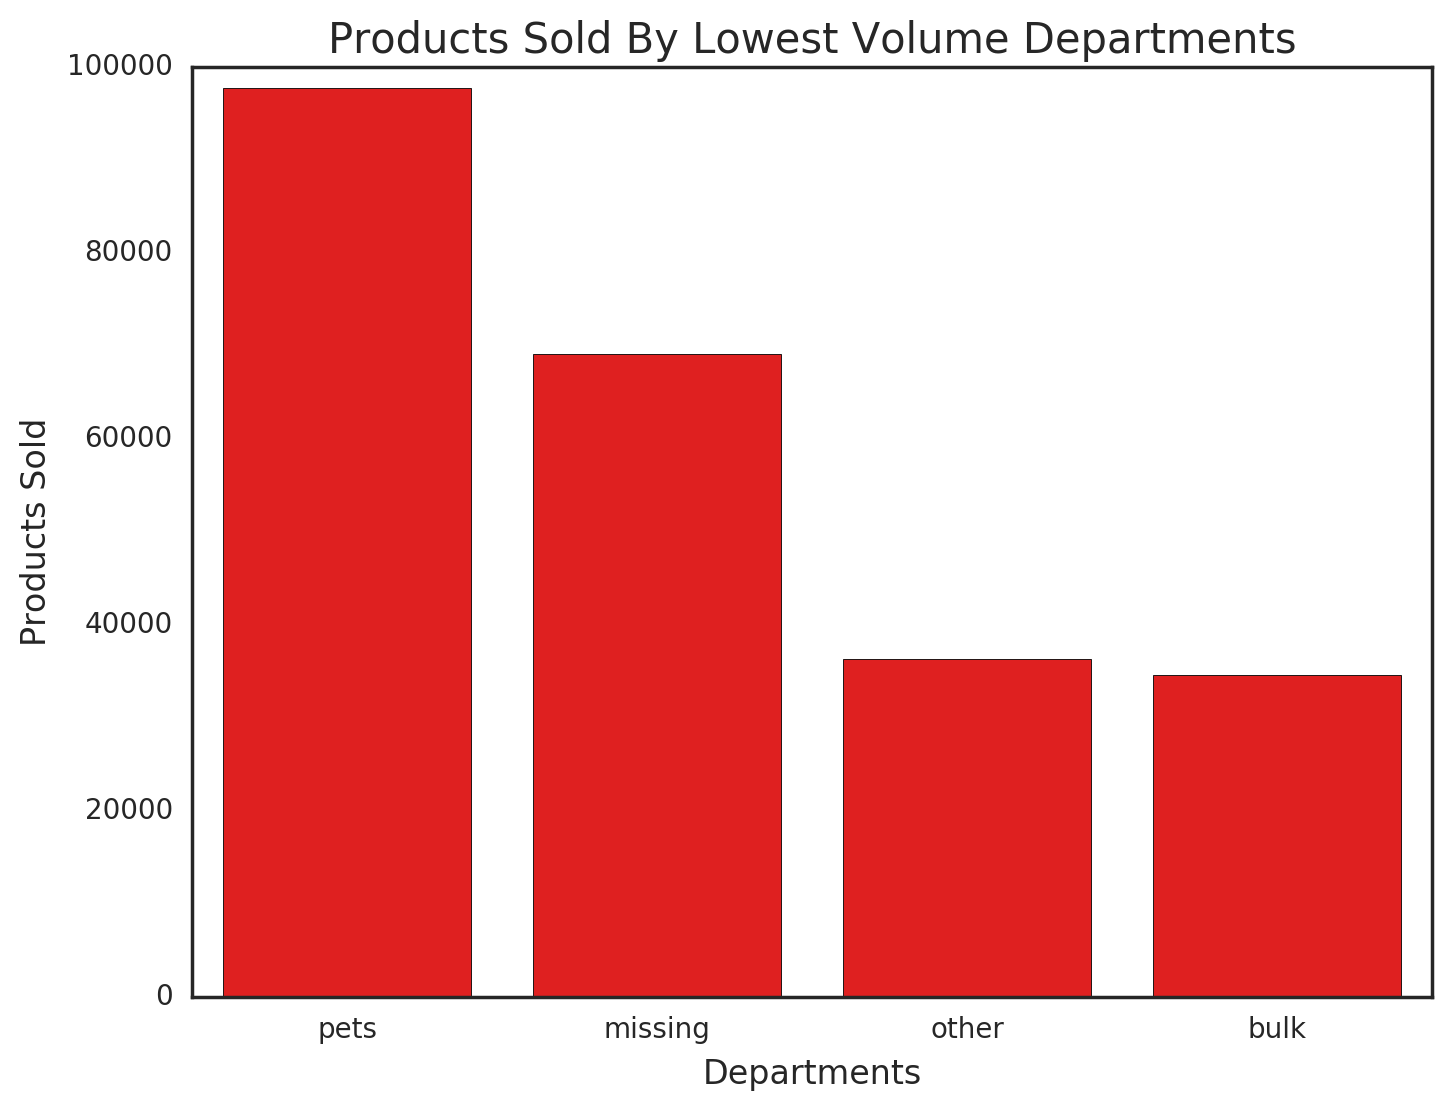

In [28]:
dept_infreq = opp['department'].value_counts().tail(4)
plt.figure(figsize=(8,6))
sns.barplot(dept_infreq.index, dept_infreq.values, color='red')
plt.ylabel('Products Sold', fontsize=12)
plt.xlabel('Departments', fontsize=12)
plt.title('Products Sold By Lowest Volume Departments', fontsize=15)
plt.show()

As one would expect from the highest volume departments, the aisles selling the most items are located in the produce and dairy departments, respectively.

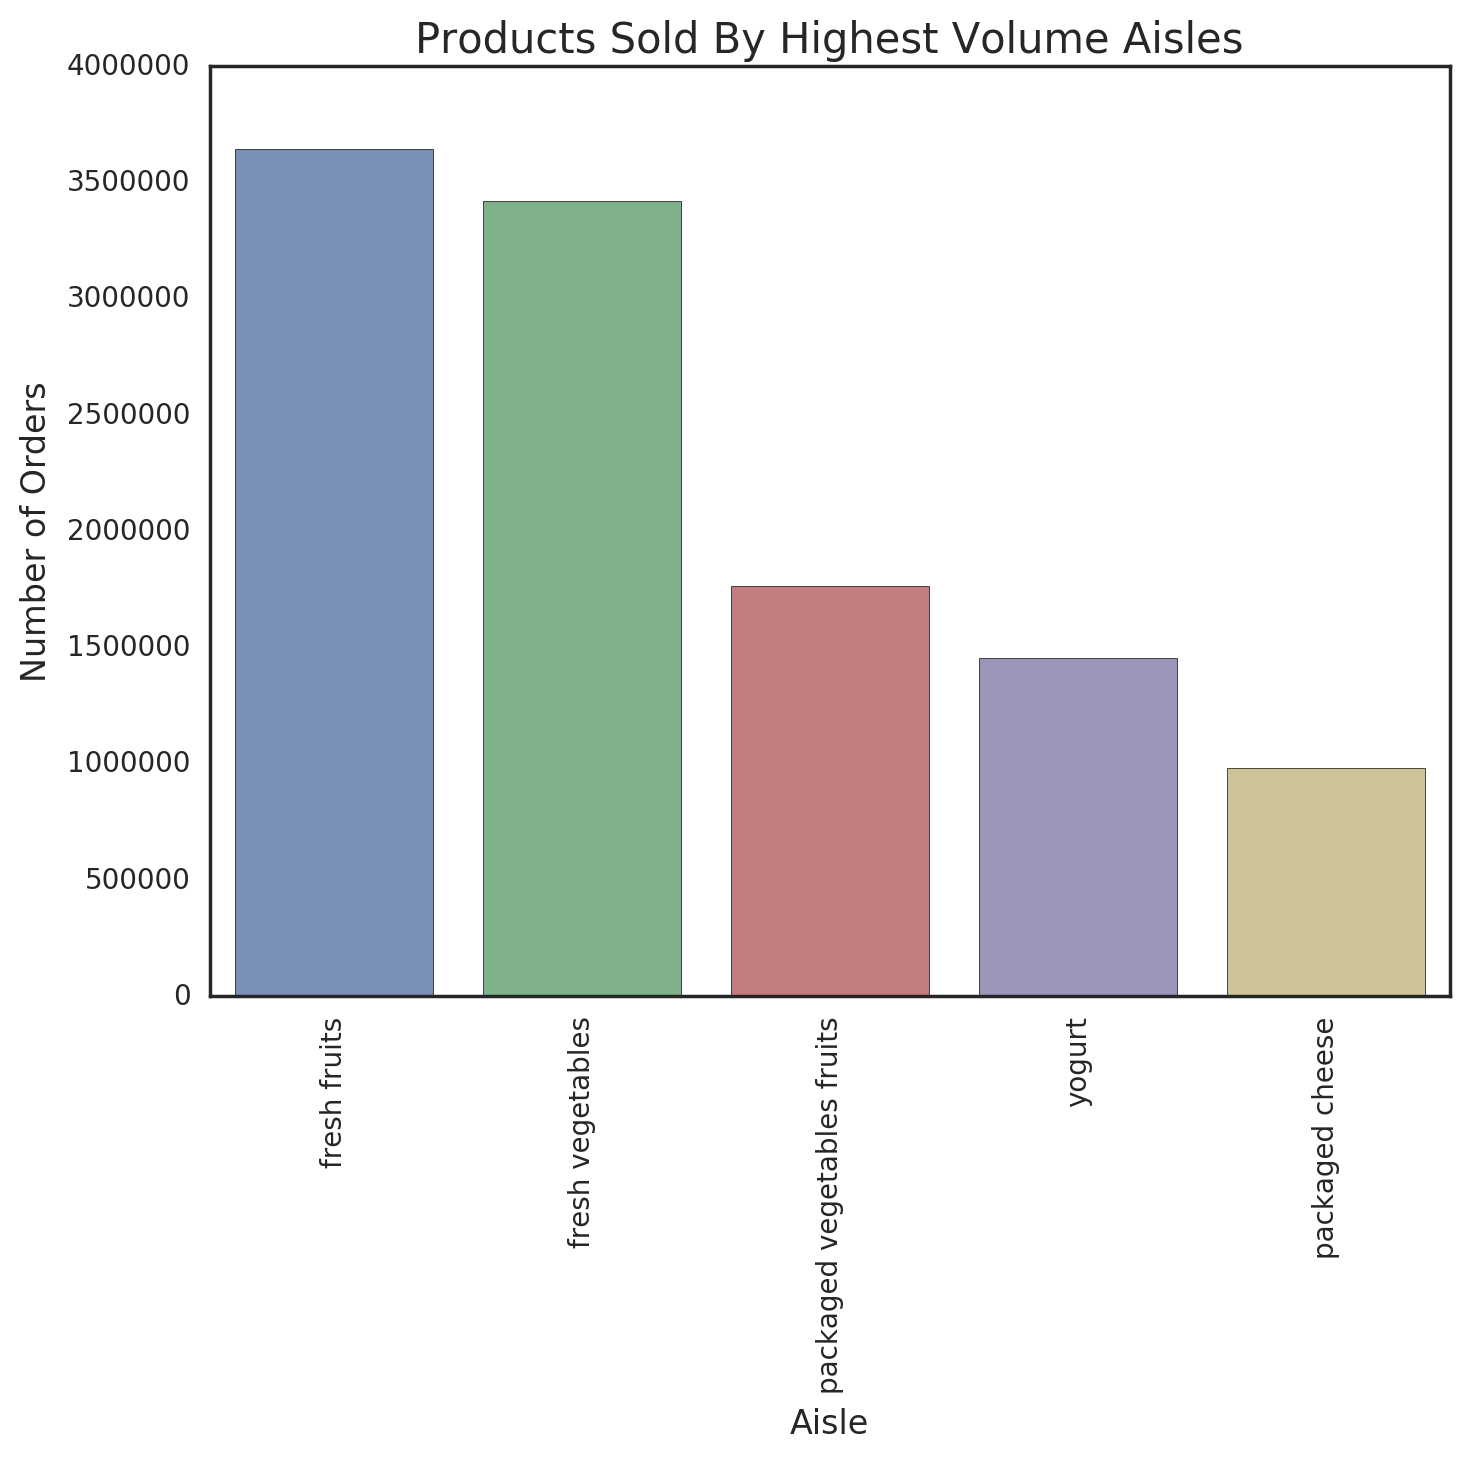

In [30]:
aisle_freq = opp['aisle'].value_counts().head(5)
plt.figure(figsize=(8,6))
sns.barplot(aisle_freq.index, aisle_freq.values, alpha=0.8)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title('Products Sold By Highest Volume Aisles', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

I group each product id with the number of times it has been ordered as well as its product name and department affiliation. With this association I can plot the individual product sales by department as below. Each dot in the plot  represents the sales volume for a unique product in the 7 Instacart departments with the highest sales volumes. I’ve capped the number of orders for each product at 50,000, though the most popular products surpass that threshold. A great many products in the produce and dairy departments sell more frequently than the most purchased products in other popular departments.

In [32]:
opp_orders = pd.merge(opp, orders, on='order_id', how='inner')
prod_orders = opp_orders.groupby('product_id')[['order_id']].count().reset_index()
prod_orders.columns = ['product_id','prod_orders']
prod_orders = pd.merge(prod_orders, products, on='product_id', how='inner')
prod_orders = pd.merge(prod_orders, departments, on='department_id', how='inner')
prod_orders.head(1)

,product_id,prod_orders,product_name,aisle_id,department_id,department
0,1,1852,Chocolate Sandwich Cookies,61,19,snacks


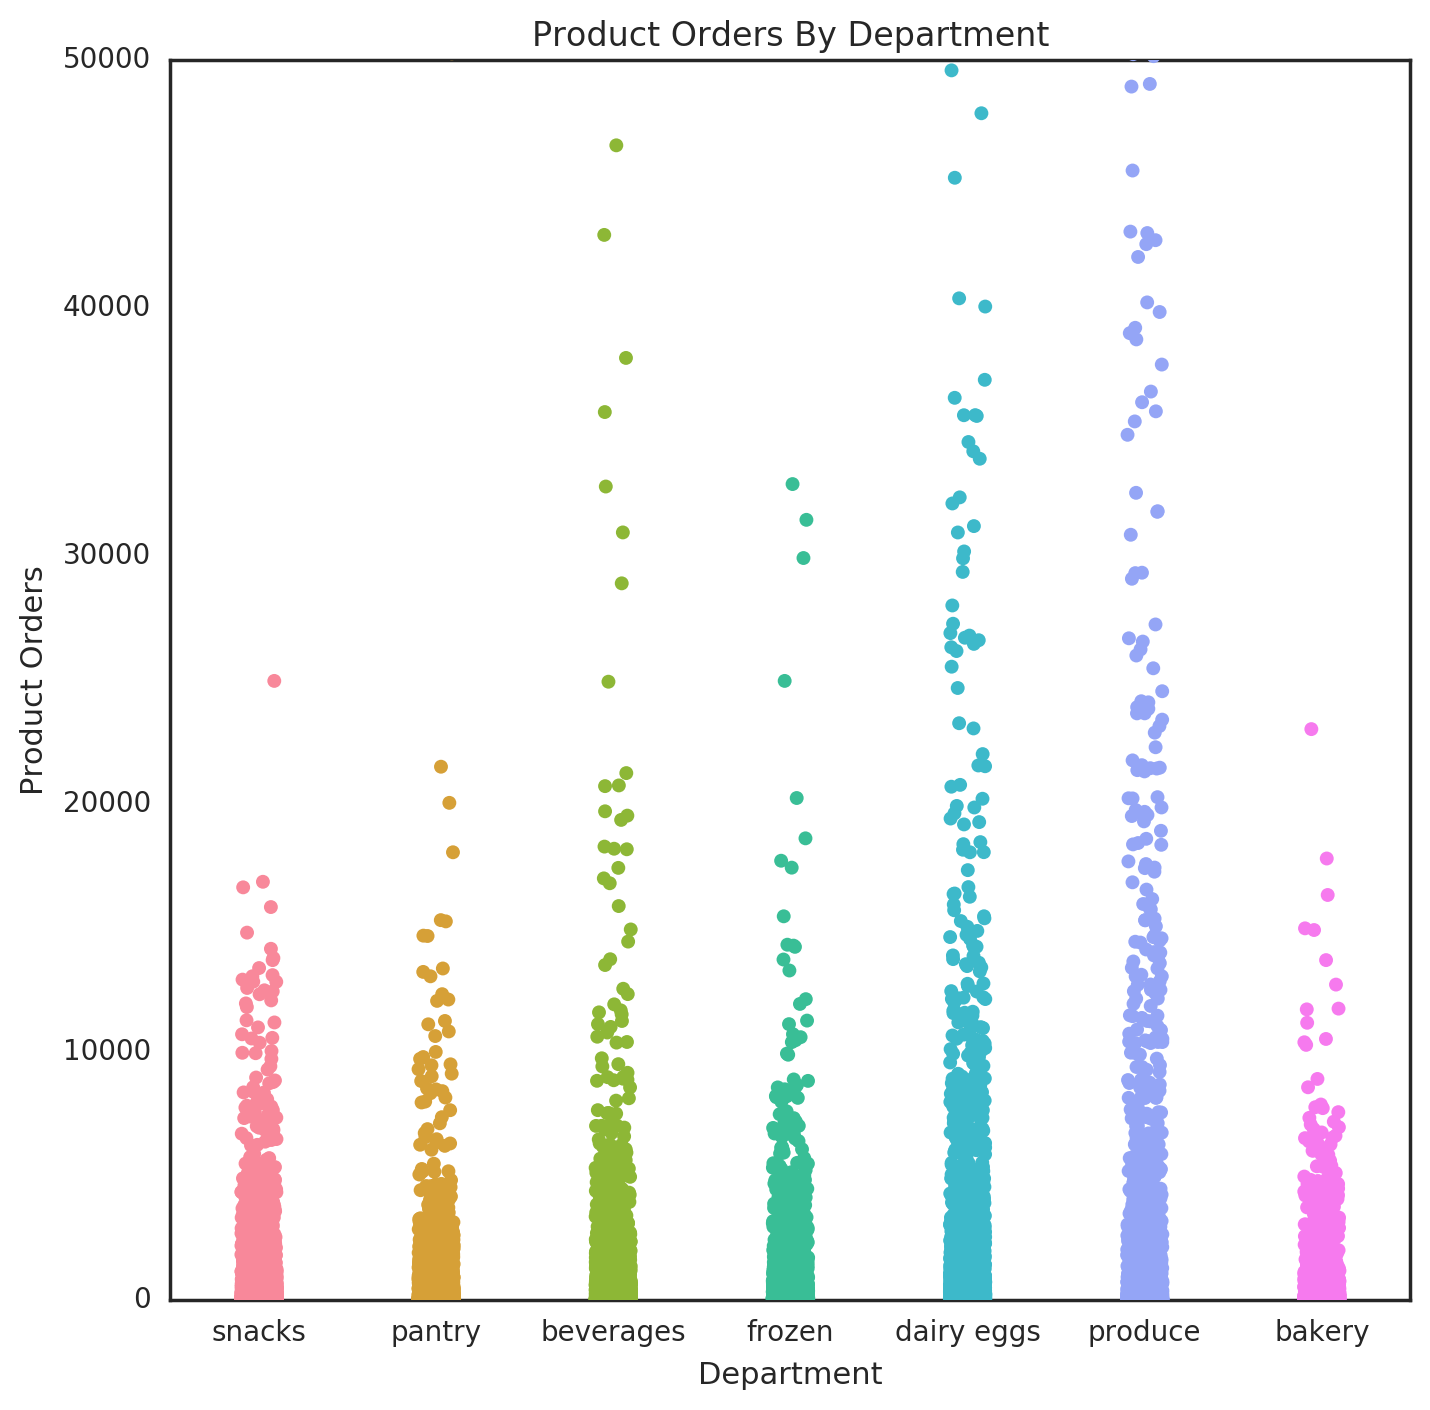

In [33]:
plt.figure(figsize=(8,8))
dept_list = ['dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry','bakery','produce']
mask = prod_orders['department'].isin(dept_list)
ax = sns.stripplot(x="department", y="prod_orders", data=prod_orders[mask],jitter=True)
ax.set(xlabel='Department', ylabel='Product Orders',title='Product Orders By Department')
plt.ylim(ymin=0)
plt.ylim(ymax=50000)
plt.show()

The most frequently ordered products: bananas, bananas, bananas. The two best selling banana products have, combined, been ordered ~850,000 times in the dataset. A variety of organic fruits and vegetables follow, ‘organic’ hinting that Instacart customers skew affluent. Organic whole milk is the lone non-produce product in the top 15 most ordered items. As a whole, fruits sell slightly more than vegetables, but that wouldn’t be so if avocado, for example, were reclassified as a vegetable.

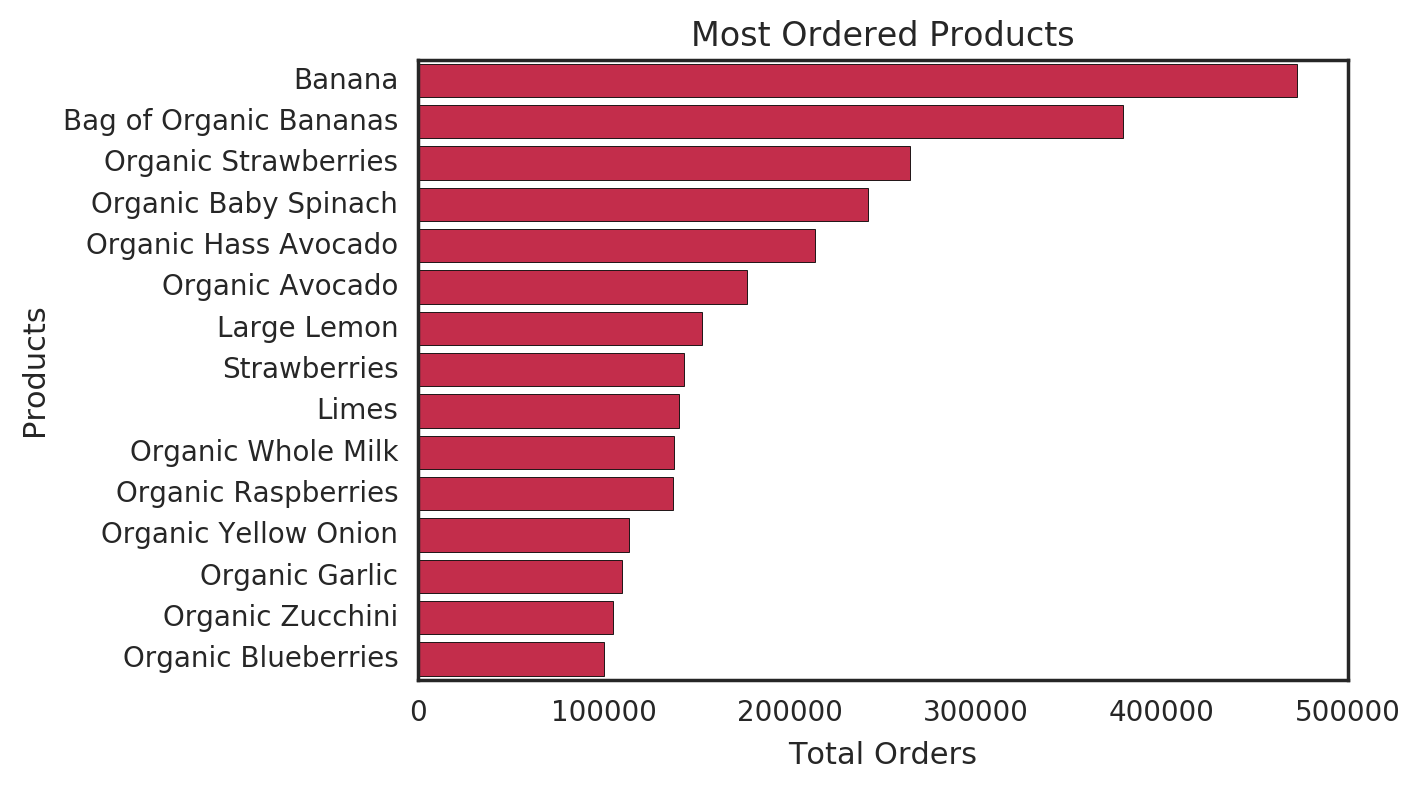

In [18]:
most_ordered = prod_orders.sort_values('prod_orders',ascending=False).head(15)
most_ordered = most_ordered[['product_name','prod_orders']]
ax = sns.barplot(y='product_name',x='prod_orders',data=most_ordered, color='crimson')
ax.set(xlabel='Total Orders', ylabel='Products',title='Most Ordered Products')
plt.show()

Of the nearly 50,000 products in the dataset, the median product is only ordered 60 times. Products like bananas, with the most popular variety sold nearly 500,000 times, drag the mean product orders up to nearly 11x the median.

In [34]:
print('Unique Products: ' + str(products['product_id'].nunique()))
print('Median Product Orders: ' + str(prod_orders['prod_orders'].median()))
print('Mean Product Orders: ' +str(prod_orders['prod_orders'].mean()))

Unique Products: 49688
Median Product Orders: 60.0
Mean Product Orders: 652.907562856


In order to better predict those instances in which a customer makes an order without any products from their order history, I create a product callled 'None.' I then track the incidence of 'None' being ordered, which can happen during any order except a customer's first order.

In [35]:
products['product_id'][49688] = 49699
products['product_name'][49688] = 'None'
products['aisle_id'][49688] = 100
products['department_id'][49688] = 21

In [36]:
prior = pd.merge(order_products_prior, orders, on='order_id', how='inner')
no_reorders = prior[prior['order_number']!=1].groupby('order_id')[['reordered']].sum().reset_index()
no_reorders = no_reorders[no_reorders['reordered']==0]
no_reorders = no_reorders['order_id'].unique()
prior_sub = prior[prior['order_id'].isin(no_reorders)]
prior_sub['product_id'] = 49699
prior_sub = prior_sub.drop('add_to_cart_order',axis=1)
prior_sub = prior_sub.drop_duplicates()
prior = prior.drop('add_to_cart_order',axis=1)
prior = pd.concat([prior, prior_sub], ignore_index=True)

<a id="reorder-rate"></a>
### Reorder rate

To find the reorder rate, I calculate for each product the number of customers who have ordered a product once as well as the number of customers who have ordered a product multiple times, and then divide the total number of customers who have ordered a product by the number of customers who have ordered it multiple times.

In [38]:
prod_by_user = prior.groupby(['user_id','product_id'])[['order_id']].count().reset_index()
prod_by_user.columns = ['user_id','product_id','orders']
mask = prod_by_user['orders']==1
single_orders = prod_by_user[mask].groupby('product_id')[['orders']].count().reset_index()
single_orders.columns = ['product_id','single']
mask = prod_by_user['orders']>1
multiple_orders = prod_by_user[mask].groupby('product_id')[['orders']].count().reset_index()
multiple_orders.columns = ['product_id','multiple']
prod_reorder = pd.merge(single_orders, multiple_orders, on='product_id', how='left')
prod_reorder = prod_reorder.fillna(value=0)
prod_reorder['reorder_rate'] = prod_reorder['multiple'] / (prod_reorder['single']+prod_reorder['multiple'])
prod_reorder[prod_reorder['product_id']==49699]

,product_id,single,multiple,reorder_rate
49587,49699,47426,42674.0,0.473629


101 products were only ever reordered - no customers purchased the product just once. For whatever reason, these products did not merge onto the dataframe with the reorder rate for the other products.

In [39]:
prods = prod_reorder['product_id'].unique()
print('Products single ordered at least once: ' + str(prod_reorder['product_id'].nunique()))
products_subset = products[-products['product_id'].isin(prods)]
products_subset['reorder_rate'] = 1
products_subset = products_subset[['product_id','reorder_rate']]
print('Products only ever reordered: ' + str(products_subset['product_id'].nunique()))

Products single ordered at least once: 49588
Products only ever reordered: 101


In [40]:
prod_reorder.sort_values('reorder_rate', ascending=False, inplace=True)
prod_reorder = prod_reorder[['product_id','reorder_rate']]
prod_reorder = pd.concat([prod_reorder,products_subset],ignore_index=True)

I concatenate the only reordered products dataframe with the main dataframe of reordered products. I then set a filter of at least 1000 product orders and assign the most and least reordered items to separate dataframes. 

In [41]:
product_totals = pd.merge(prod_orders, prod_reorder, on='product_id',how='inner')
mask = product_totals['prod_orders'] >= 1000
head = product_totals[mask].sort_values('reorder_rate',ascending=False).head(7)
tail = product_totals[mask].sort_values('reorder_rate').head(7)

Popular varieties of fruit, milk, yogurt, and egg products populate the most reordered items list. Though whether judging by the most orders or the highest reorder rate, the banana is king.

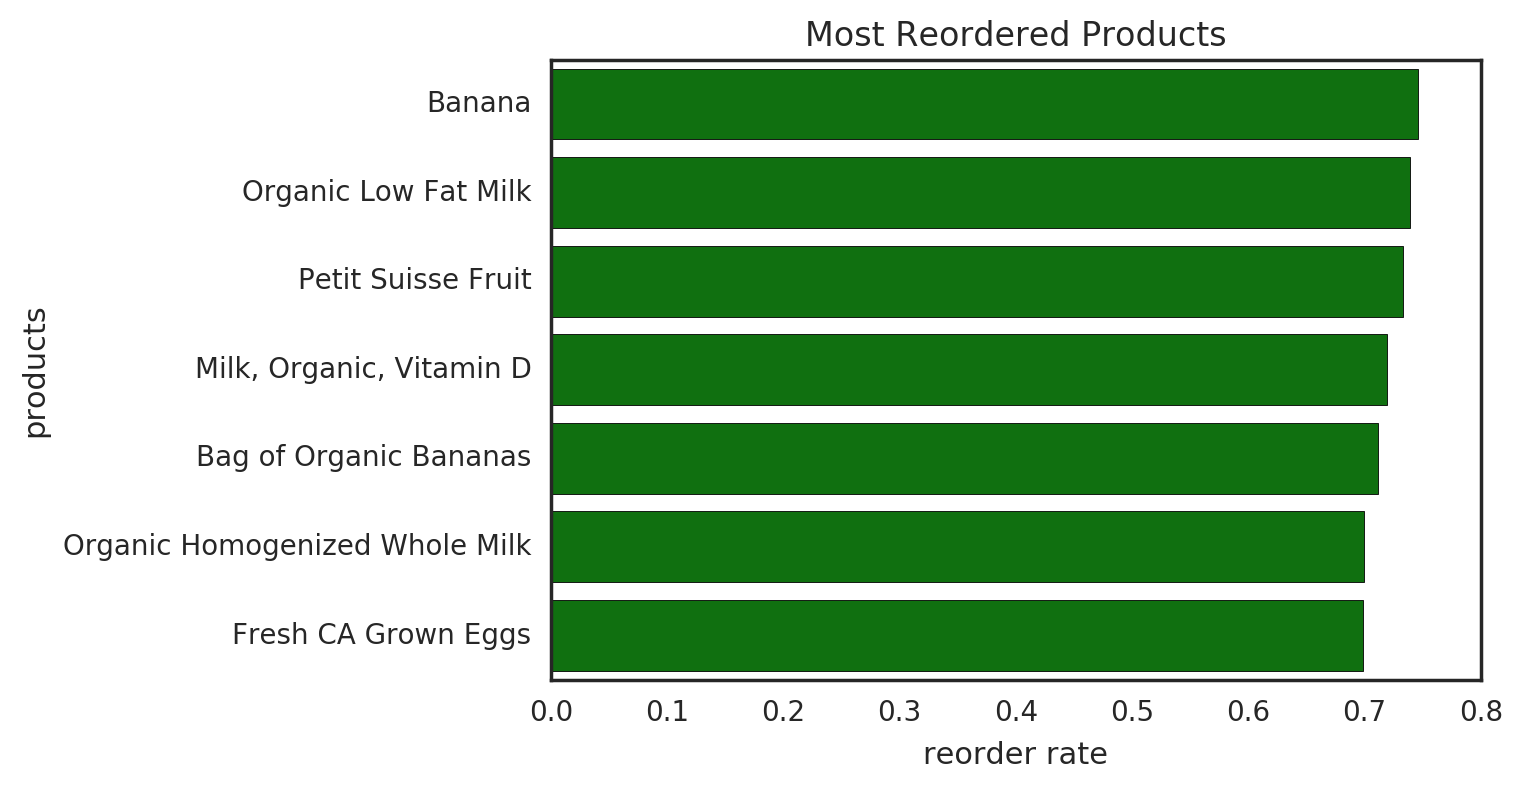

In [42]:
ax = sns.barplot(y='product_name',x='reorder_rate',color='green',data=head)
ax.set(xlabel='reorder rate', ylabel='products',title='Most Reordered Products')
plt.show()

Items with low reorder rates disproportionately come from the pantry department. Whether to bake, thicken, or season dishes, pantry products are items that most people need occasionally, but use infrequently, and keep for a long time.


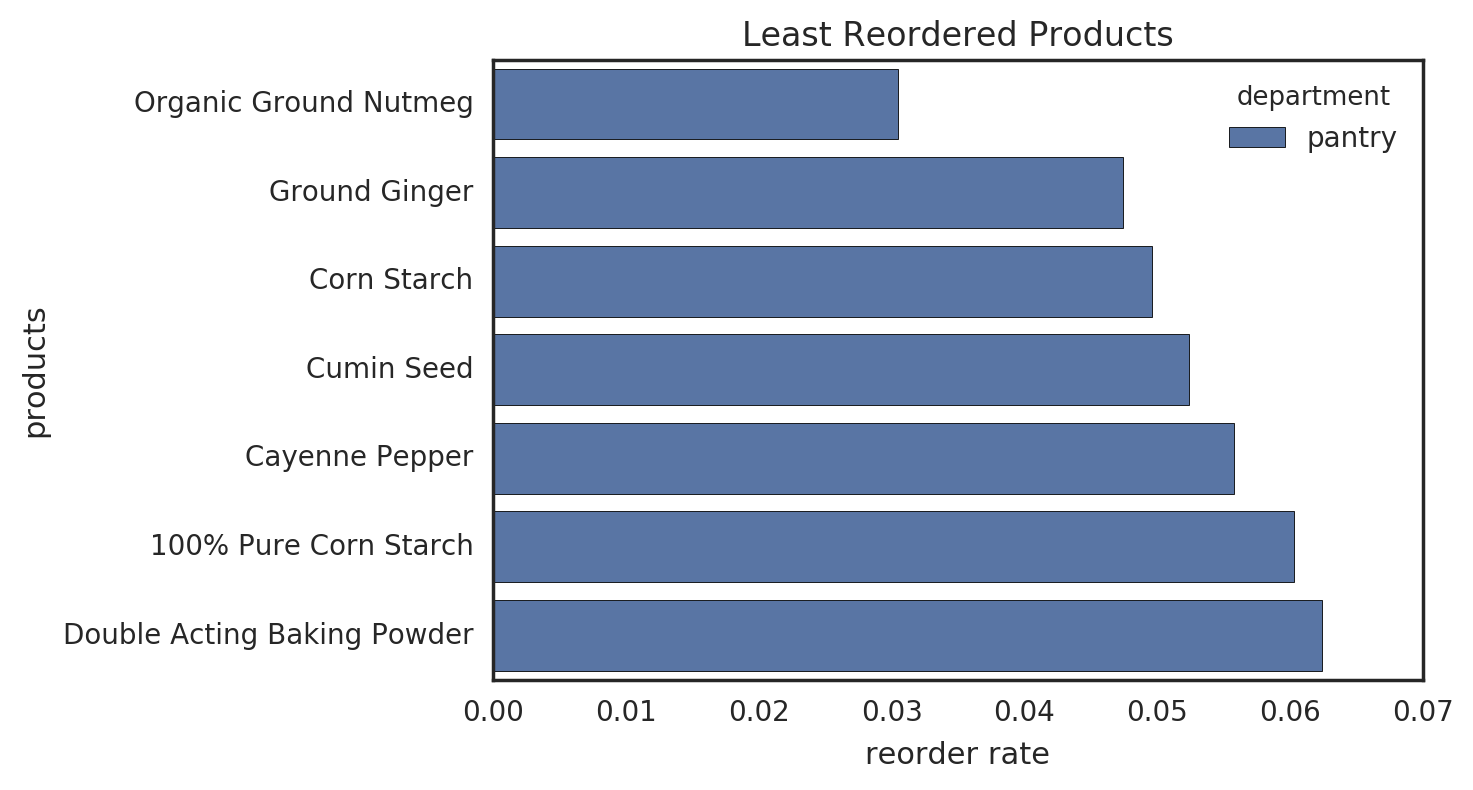

In [43]:
ax = sns.barplot(y='product_name',x='reorder_rate',hue='department',data=tail)
ax.set(xlabel='reorder rate', ylabel='products',title='Least Reordered Products')
plt.show()

Most customers do not purchase the same product twice. The median reorder rate across all products, meaning the percentage of users who have ordered a product multiple times divided by the total number of customers who have ordered the product, is only 28%. 

In [44]:
print('Median reorder rate: '+str(prod_reorder['reorder_rate'].median()))
print('Mean reorder rate: '+str(prod_reorder['reorder_rate'].mean()))

Median reorder rate: 0.28
Mean reorder rate: 0.27728922425


<a id="orders-without-reordered-products"></a>
### Orders Without Reordered Products

Customer orders are very likely to include a reordered item — 93.5% of orders in the training split contained a previously purchased item. That said, we should expect about 6.5% of orders in the test split not to contain reordered items, assuming those customers' number of total orders, proximity in days to their last order, and other attributes are consistent with the training split. 

In [3]:
grouped_df = order_products_train.groupby("order_id")["reordered"].sum().reset_index()
print('Percent of orders with no reordered products in training orders: ' + 
      str(float(grouped_df[grouped_df['reordered']==0].shape[0]) / grouped_df.shape[0]))

Percent of orders with no reordered products in training orders: 0.0655595271666


Looking at orders with no reordered products in proportion to the total numbers of orders made between 0-30 days after a previous order, orders without reordered products are disproportionately likely for users making orders 0-2 and 30 days after their previous order.

Here and in the plots below I impute values in places to better evince trends where a small number of users makes the data volatile.

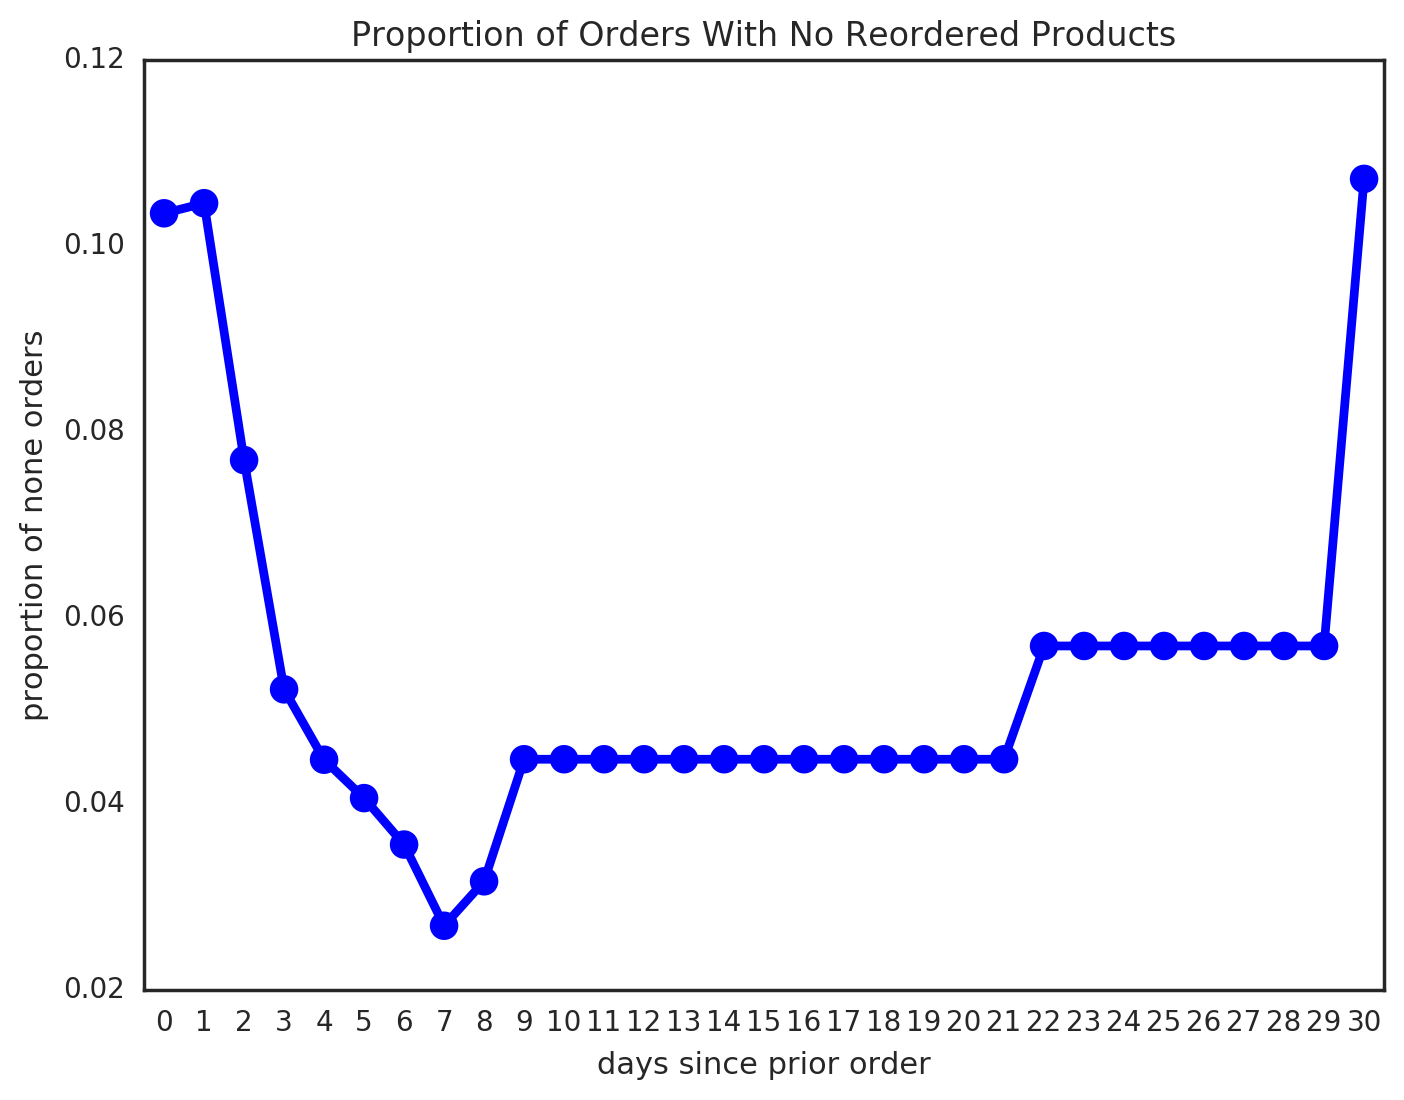

In [4]:
train_orders = orders[orders['eval_set']=='train']
train_days = train_orders.groupby('days_since_prior_order')[['order_id']].count().reset_index()
train_days.columns = ['days_since_prior_order', 'train_orders']
nulls = pd.merge(orders, grouped_df[grouped_df['reordered']==0], on='order_id', how='inner')
none_df = nulls.groupby('days_since_prior_order')[['order_id']].count().reset_index()
none_df.columns = ['days_since_prior_order','none_orders']
none_df = pd.merge(none_df, train_days, on='days_since_prior_order', how='left')
none_df['proportion_of_nones'] = none_df['none_orders'] / none_df['train_orders']
none_df['days_since_prior_order'] = none_df['days_since_prior_order'].map(lambda x: int(x))
mask = (none_df['days_since_prior_order']>=9) & (none_df['days_since_prior_order']<=21)
median1 = none_df[mask]['proportion_of_nones'].median()
none_df.loc[none_df[mask].days_since_prior_order,'proportion_of_nones'] = median1
mask = (none_df['days_since_prior_order']>=22) & (none_df['days_since_prior_order']<=29)
median2 = none_df[mask]['proportion_of_nones'].median()
none_df.loc[none_df[mask].days_since_prior_order,'proportion_of_nones'] = median2
fig, ax = plt.subplots(figsize=(8,6))
sns.pointplot(y='proportion_of_nones',x='days_since_prior_order', color='blue',data=none_df, ax=ax)
ax.set(xlabel='days since prior order', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products')
plt.show()

While orders made at 5am appear to be different from other times of the day in terms of people not ordering from their order histories, those orders are few enough that I think we're seeing noise here.

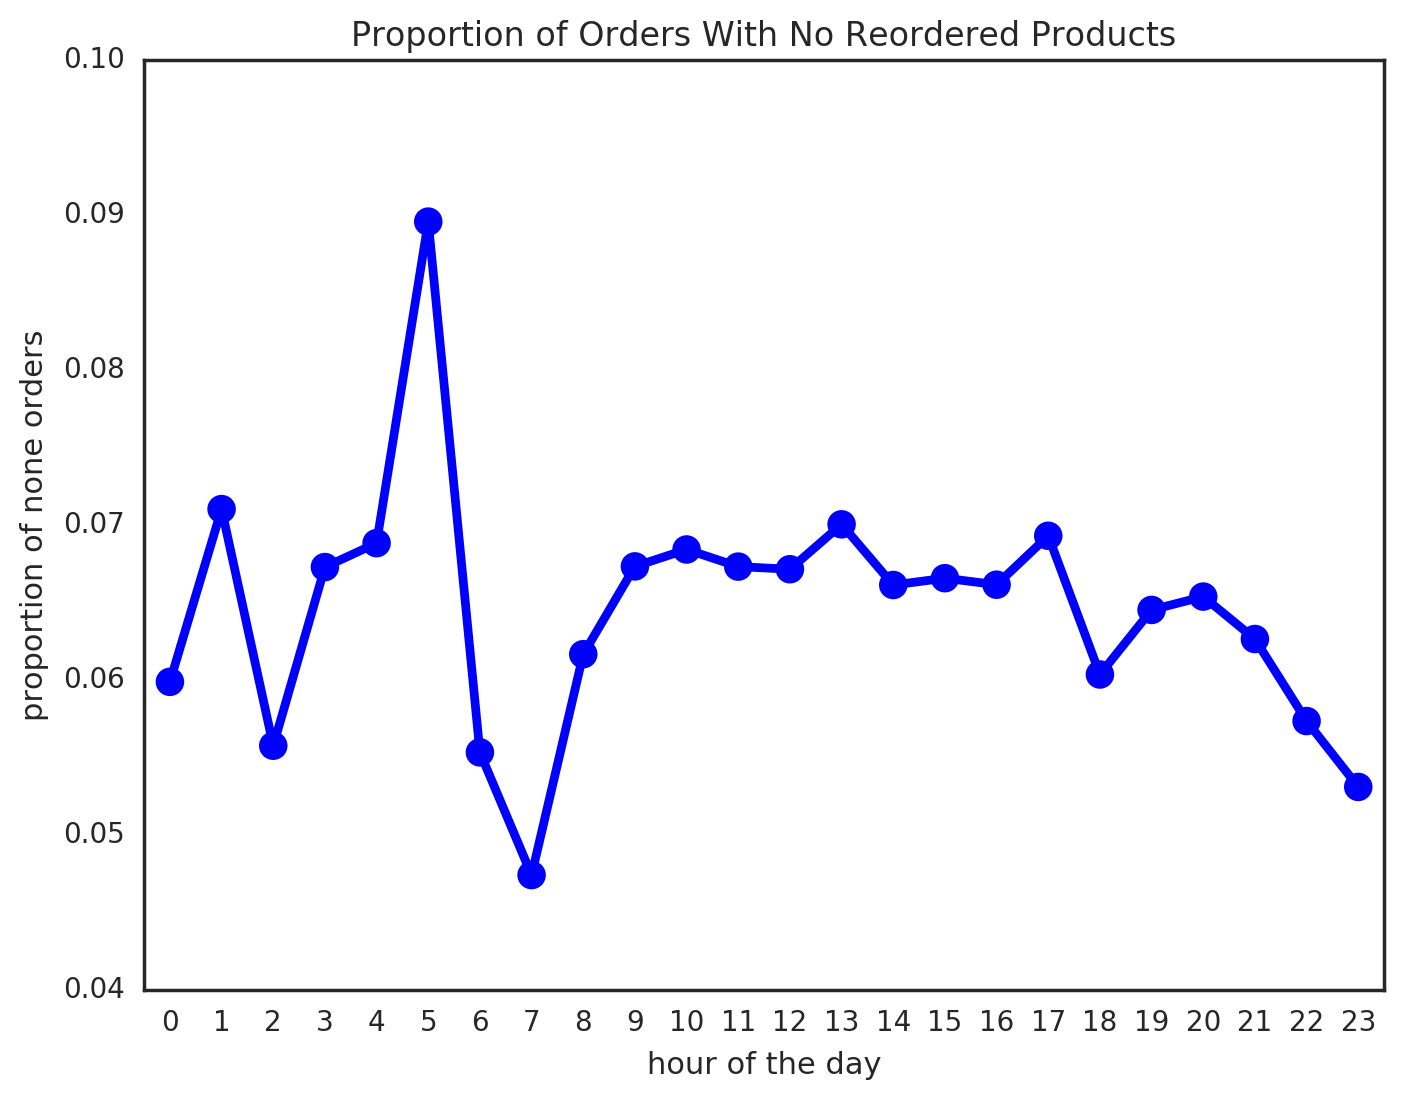

In [122]:
train_hour = train_orders.groupby('order_hour_of_day')[['order_id']].count().reset_index()
train_hour.columns = ['order_hour_of_day', 'train_orders']
none_hour = nulls.groupby('order_hour_of_day')[['order_id']].count().reset_index()
none_hour.columns = ['order_hour_of_day','none_orders']
none_hour = pd.merge(none_hour, train_hour, on='order_hour_of_day', how='left')
none_hour['proportion_of_nones'] = none_hour['none_orders'] / none_hour['train_orders']
fig, ax = plt.subplots(figsize=(8,6))
sns.pointplot(y='proportion_of_nones',x='order_hour_of_day', color='blue',data=none_hour, ax=ax)
ax.set(xlabel='hour of the day', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products')
plt.show()

By day of the week, orders made on Sunday are particularly likely to contain reordered products, but from an absolute standpoint the effect isn't too pronounced . For users making orders close to or far away from their previous orders, that behavior does not seem to be driven by the day of the week.

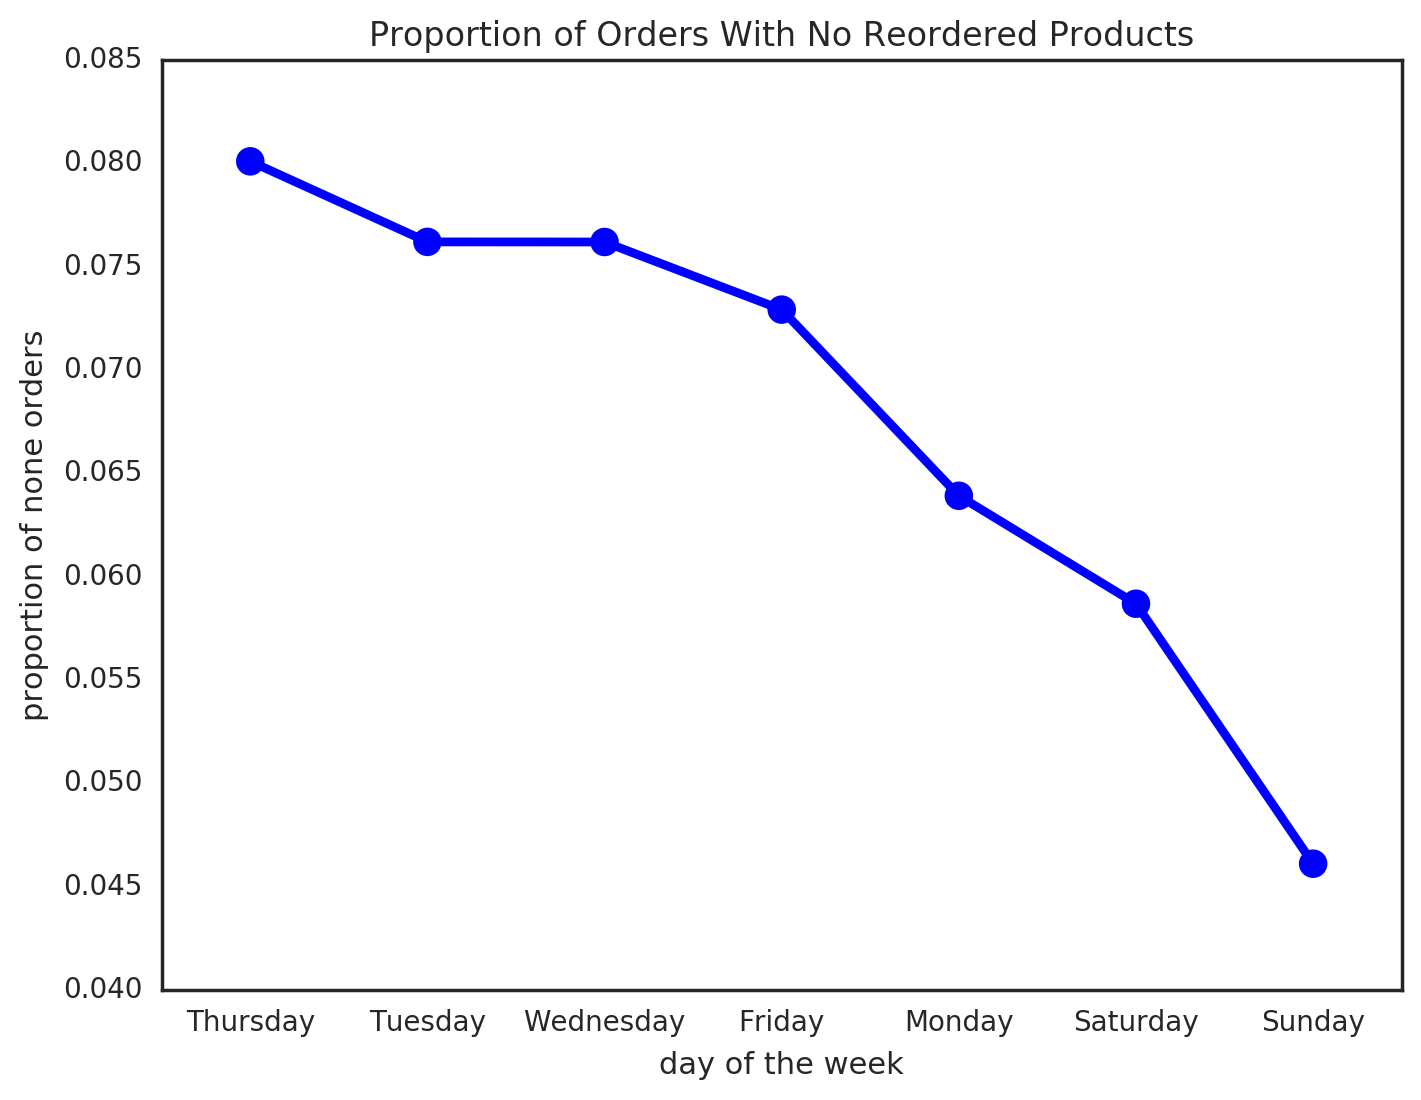

In [59]:
train_dow = train_orders.groupby('order_dow')[['order_id']].count().reset_index()
train_dow.columns = ['order_dow', 'train_orders']
none_dow = nulls.groupby('order_dow')[['order_id']].count().reset_index()
none_dow.columns = ['order_dow','none_orders']
none_dow = pd.merge(none_dow, train_dow, on='order_dow', how='left')
none_dow['proportion_of_nones'] = none_dow['none_orders'] / none_dow['train_orders']
none_dow = none_dow.sort_values('proportion_of_nones', ascending=False)
fig, ax = plt.subplots(figsize=(8,6))
sns.pointplot(y='proportion_of_nones',x='order_dow', color='blue',data=none_dow, ax=ax)
ax.set(xlabel='day of the week', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products')
plt.show()

Looking at orders with no reordered products in proportion to the total numbers of orders each user has made demonstrates that, intuitively, customers who have ordered fewer products are less likely to be confined to their order history when ordering products. Orders without reordered products are far more likely to come from users with few orders with Instacart. This feels significant given that these users with fewer orders are by far the most common user type in the dataset.

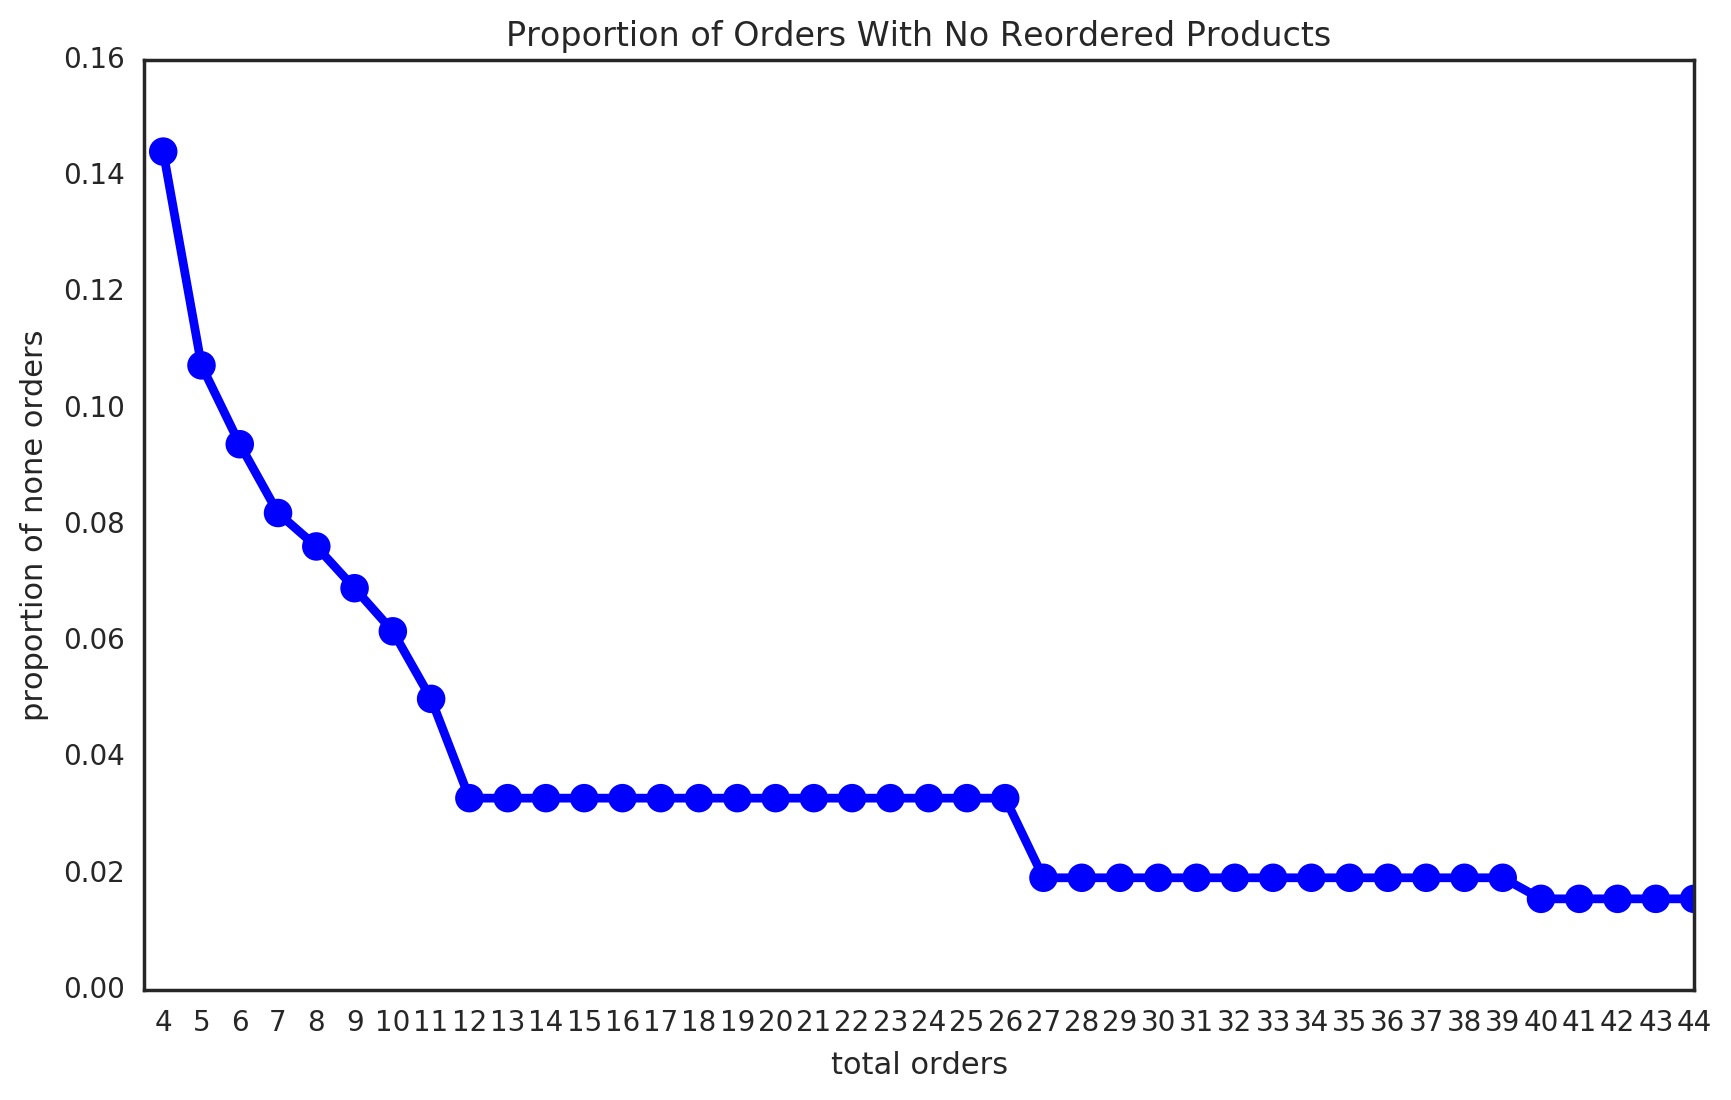

In [8]:
train_total = train_orders.groupby('order_number')[['order_id']].count().reset_index()
train_total.columns = ['order_number', 'train_orders']
none_total = nulls.groupby('order_number')[['order_id']].count().reset_index()
none_total.columns = ['order_number','none_orders']
none_total = pd.merge(none_total, train_total, on='order_number', how='left')
none_total['proportion_of_nones'] = none_total['none_orders'] / none_total['train_orders']
order_numbers = none_total['order_number'].unique()
not_in = pd.DataFrame(columns=['order_number','proportion_of_nones'])
median = none_total[none_total['order_number']>=40]['proportion_of_nones'].median()
for i in range(4,101):
        if i not in order_numbers:
            not_in.loc[i,'order_number'] = i
            not_in.loc[i,'none_orders'] = np.nan
            not_in.loc[i,'train_orders'] = np.nan
            not_in.loc[i,'proportion_of_nones'] = median
none_total = pd.concat([none_total,not_in],ignore_index=True)
mask = (none_total['order_number']>=12) & (none_total['order_number']<=26)
median2 = none_total[mask]['proportion_of_nones'].median()
none_total.set_value(none_total[mask].index, 'proportion_of_nones', median2)
mask = (none_total['order_number']>=27) & (none_total['order_number']<=39)
median3 = none_total[mask]['proportion_of_nones'].median()
none_total.set_value(none_total[mask].index, 'proportion_of_nones', median3)
none_total.loc[none_total.order_number >= 40,'proportion_of_nones'] = median
none_total = none_total.sort_values('order_number')
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(y='proportion_of_nones',x='order_number', color='blue',data=none_total, ax=ax)
ax.set(xlabel='total orders', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products')
plt.xlim(xmax=40)
plt.show()

Isolating the 0-2 day window where orders without reorders are more common and looking at that by total orders, we can see that as with the large sample, the fewer orders a customer has made, the greater the likelihood of their making an order without reorded products. Customers with minimum number of orders, 4, who are also the most common, are ~22.5% likely to make and order with no reordered products 0-2 days after their last order. Orders without reordered products are particularly common for users with less than 10 orders and relatively common for users with up to 2 dozen orders when making orders in this time window.

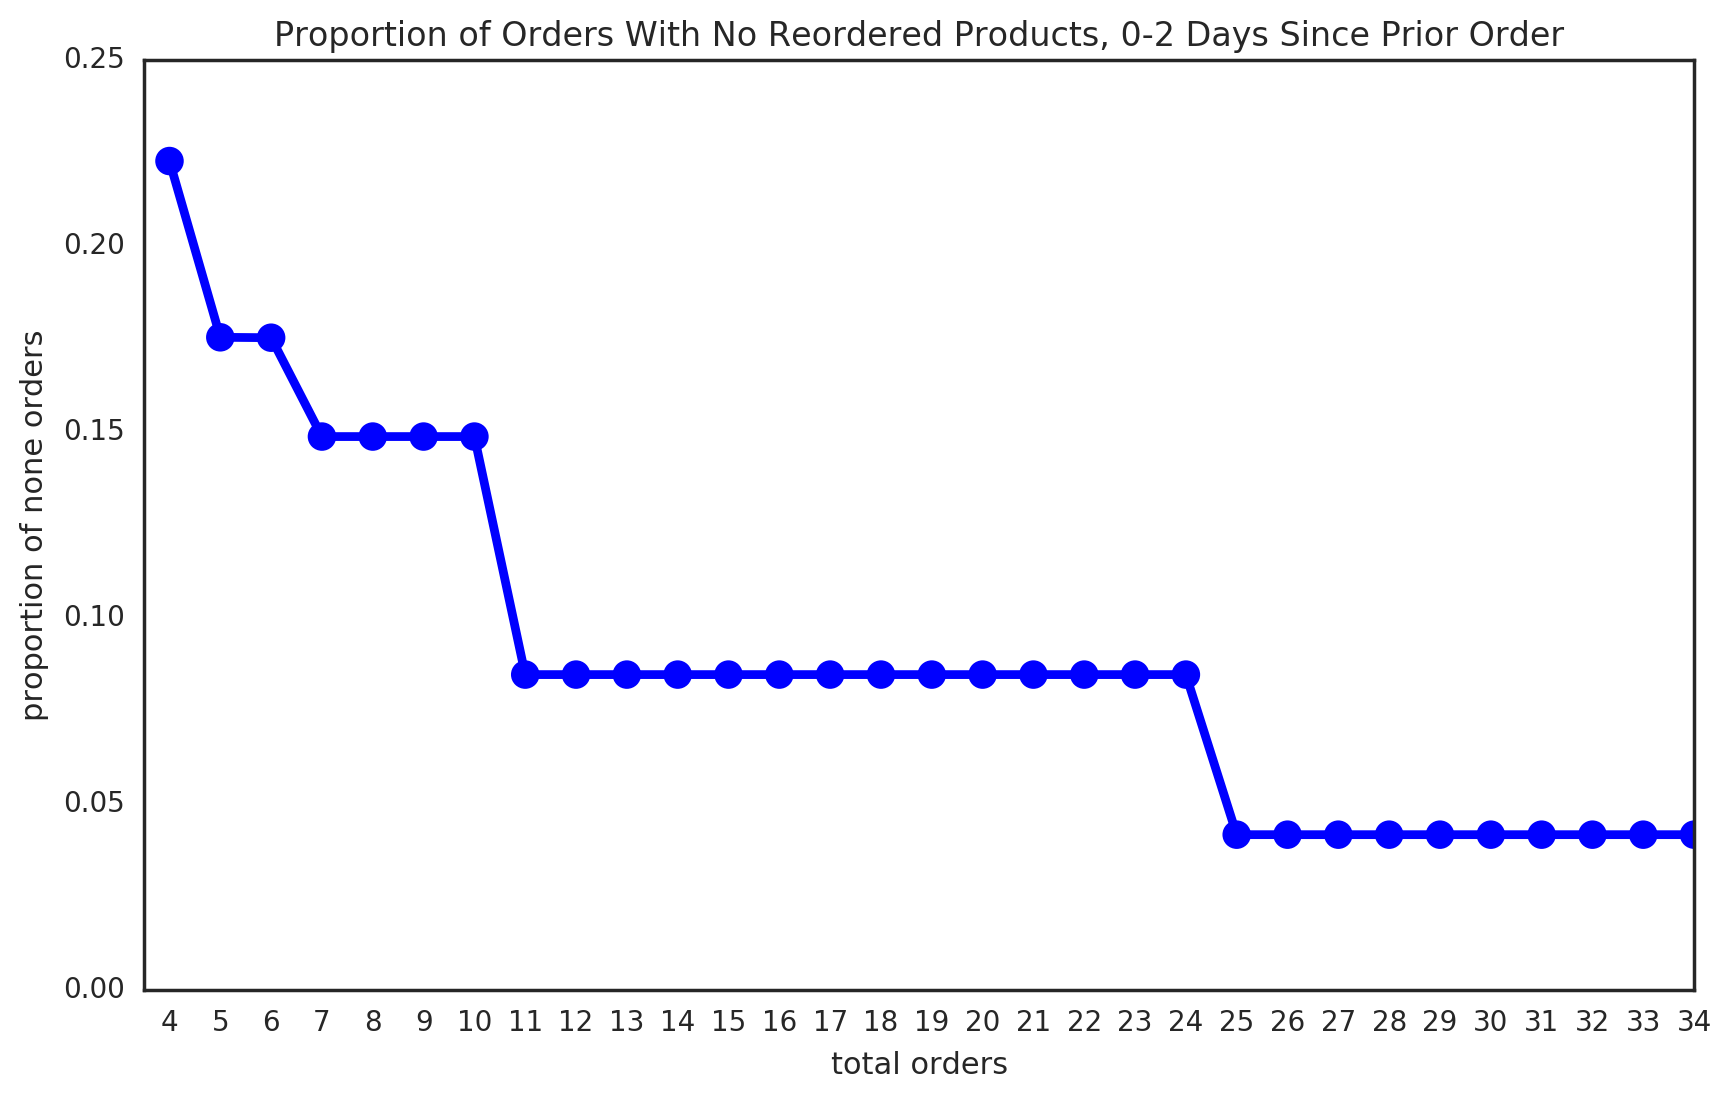

In [61]:
days_list = [0.0,1.0,2.0]
mask = train_orders['days_since_prior_order'].isin(days_list)
train_0_2 = train_orders[mask].groupby('order_number')[['order_id']].count().reset_index()
train_0_2.columns = ['order_number', 'train_orders']
mask = nulls['days_since_prior_order'].isin(days_list)
none_0_2 = nulls[mask].groupby('order_number')[['order_id']].count().reset_index()
none_0_2.columns = ['order_number','none_orders']
none_0_2 = pd.merge(none_0_2, train_0_2, on='order_number', how='left')
none_0_2['proportion_of_nones'] = none_0_2['none_orders'] / none_0_2['train_orders']
median = none_0_2[none_0_2['order_number']>=25]['proportion_of_nones'].median()
order_numbers = none_0_2['order_number'].unique()
not_in = pd.DataFrame(columns=['order_number','proportion_of_nones'])
for i in range(4,101):
        if i not in order_numbers:
            not_in.loc[i,'order_number'] = i
            not_in.loc[i,'none_orders'] = np.nan
            not_in.loc[i,'train_orders'] = np.nan
            not_in.loc[i,'proportion_of_nones'] = median
none_0_2 = pd.concat([none_0_2,not_in],ignore_index=True)
mask1 = (none_0_2['order_number']>=7) & (none_0_2['order_number']<=10)
median2 = none_0_2[mask1]['proportion_of_nones'].median()
none_0_2.set_value(none_0_2[mask1].index, 'proportion_of_nones', median2)
mask = (none_0_2['order_number']>=11) & (none_0_2['order_number']<=24)
median3 = none_0_2[mask]['proportion_of_nones'].median()
none_0_2.loc[none_0_2.order_number >= 11,'proportion_of_nones'] = median3
none_0_2.loc[none_0_2.order_number >= 25,'proportion_of_nones'] = median
none_0_2 = none_0_2.sort_values('order_number')
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(y='proportion_of_nones',x='order_number', color='blue',data=none_0_2, ax=ax)
ax.set(xlabel='total orders', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products, 0-2 Days Since Prior Order')
plt.xlim(xmax=30)
plt.show()


For orders made between 3-29 days after a customers previous order, users with fewer orders are likeliest to order products without reordered products, though the effect dissipates with each additional order, leveling off after 9-10 orders.

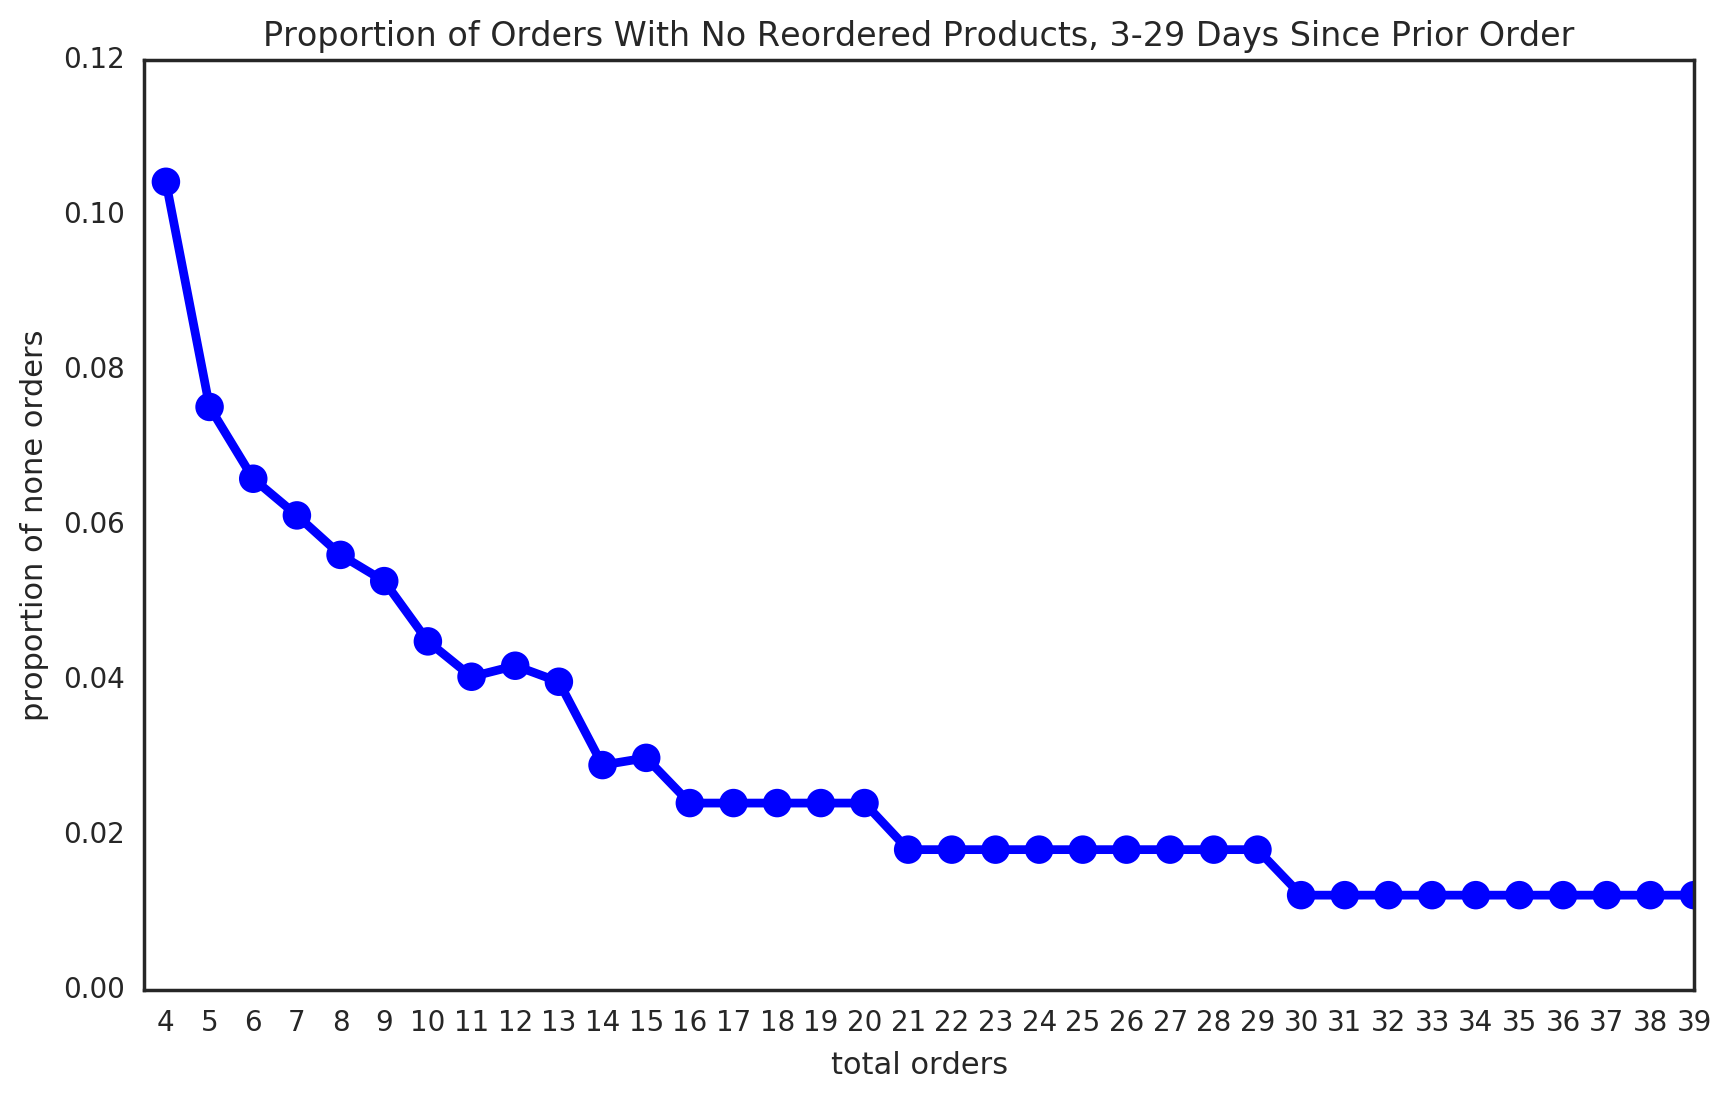

In [62]:
mask =  (train_orders['days_since_prior_order']>=3) & (train_orders['days_since_prior_order']<=29)
train_3_29 = train_orders[mask].groupby('order_number')[['order_id']].count().reset_index()
train_3_29.columns = ['order_number', 'train_orders']
mask = (nulls['days_since_prior_order']>=3) & (nulls['days_since_prior_order']<=29)
none_3_29 = nulls[mask].groupby('order_number')[['order_id']].count().reset_index()
none_3_29.columns = ['order_number','none_orders']
none_3_29 = pd.merge(none_3_29, train_3_29, on='order_number', how='left')
none_3_29['proportion_of_nones'] = none_3_29['none_orders'] / none_3_29['train_orders']
median = none_3_29[none_3_29['order_number']>=30]['proportion_of_nones'].median()
order_numbers = none_3_29['order_number'].unique()
not_in = pd.DataFrame(columns=['order_number','proportion_of_nones'])
for i in range(4,101):
        if i not in order_numbers:
            not_in.loc[i,'order_number'] = i
            not_in.loc[i,'none_orders'] = np.nan
            not_in.loc[i,'train_orders'] = np.nan
            not_in.loc[i,'proportion_of_nones'] = median
none_3_29 = pd.concat([none_3_29,not_in],ignore_index=True)
mask = (none_3_29['order_number']>=16) & (none_3_29['order_number']<=20)
median1 = none_3_29[mask]['proportion_of_nones'].median()
none_3_29.set_value(none_3_29[mask].index, 'proportion_of_nones', median1)
mask = (none_3_29['order_number']>=21) & (none_3_29['order_number']<=29)
median2 = none_3_29[mask]['proportion_of_nones'].median()
none_3_29.set_value(none_3_29[mask].index, 'proportion_of_nones', median2)
none_3_29.loc[none_3_29.order_number >= 30,'proportion_of_nones'] = median
none_3_29 = none_3_29.sort_values('order_number')
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(y='proportion_of_nones',x='order_number', color='blue',data=none_3_29, ax=ax)
ax.set(xlabel='total orders', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products, 3-29 Days Since Prior Order')
plt.xlim(xmax=35)
plt.show()

Lastly, looking at orders made 30 days or more out, we see again that users who have made the fewest orders are much likelier to make orders without reordered products, and that this likelihood far surpasses that of orders made with 3-29 days proximity to the last. The effect dissipates and levels off around 10 orders, though for users with many orders, the probability of an order not containing previously ordered products is likewise higher than that of 3-29 days.

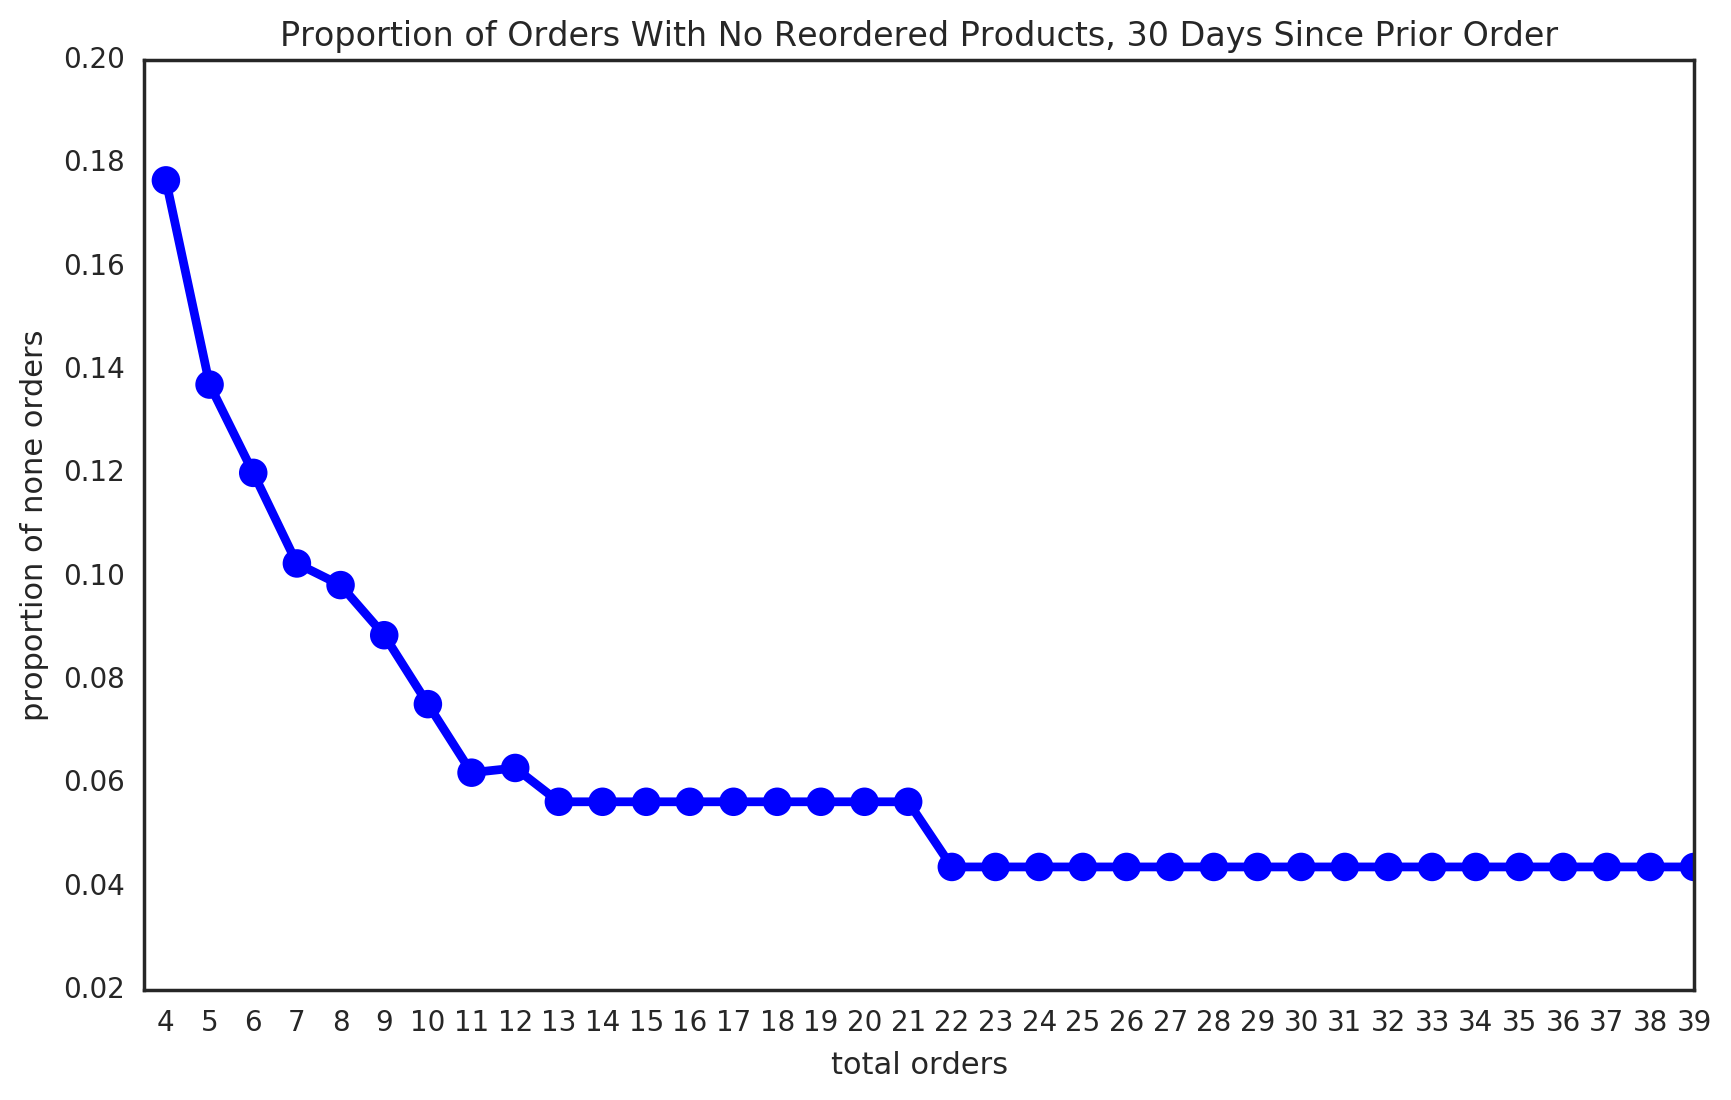

In [63]:
mask =  (train_orders['days_since_prior_order']==30)
train_30 = train_orders[mask].groupby('order_number')[['order_id']].count().reset_index()
train_30.columns = ['order_number', 'train_orders']
mask = (nulls['days_since_prior_order']==30)
none_30 = nulls[mask].groupby('order_number')[['order_id']].count().reset_index()
none_30.columns = ['order_number','none_orders']
none_30 = pd.merge(none_30, train_30, on='order_number', how='left')
none_30['proportion_of_nones'] = none_30['none_orders'] / none_30['train_orders']
mask = (none_30['order_number']>=22) & (none_30['order_number']<=41)
median = none_30[mask]['proportion_of_nones'].median()
order_numbers = none_30['order_number'].unique()
not_in = pd.DataFrame(columns=['order_number','proportion_of_nones'])
for i in range(4,101):
        if i not in order_numbers:
            not_in.loc[i,'order_number'] = i
            not_in.loc[i,'none_orders'] = np.nan
            not_in.loc[i,'train_orders'] = np.nan
            not_in.loc[i,'proportion_of_nones'] = median
none_30 = pd.concat([none_30,not_in],ignore_index=True)
mask = (none_30['order_number']>=13) & (none_30['order_number']<=21)
median2 = none_30[mask]['proportion_of_nones'].median()
none_30.set_value(none_30[mask].index, 'proportion_of_nones', median2)
none_30.loc[none_30.order_number >= 22,'proportion_of_nones'] = median
none_30 = none_30.sort_values('order_number')
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(y='proportion_of_nones',x='order_number', color='blue',data=none_30, ax=ax)
ax.set(xlabel='total orders', ylabel='proportion of none orders' ,title=
       'Proportion of Orders With No Reordered Products, 30 Days Since Prior Order')
plt.xlim(xmax=35)
plt.show()

The takeaway here: I want to capture the relationship between total orders and days since a prior order as they pertain to orders without reordered products.

<a id="generating-features"></a>
# Generating Features

The first step in generating features is to group users by the products they've ordered and the number of times the've ordered each product. Remember, I'm only predicting products in a given users' order history. The raw number of times a customer has order an item will represent the first feature in my model.

In [64]:
prod_by_user = prior.groupby(['user_id','product_id'])[['order_id']].count().reset_index()
prod_by_user.columns = ['user_id','product_id','num_ordered']
prod_by_user.head(1)

,user_id,product_id,num_ordered
0,1,196,10


Next, I fetch the total orders for each customer and then divide the number of product orders by the total orders to derive a personal order rate for each product. The order rate is simply the proportion of times a customer has ordered a given product. I intuitively expect things customers order a lot  to be in their next order; things customers order infrequently I do not. The order rate is limited, however, in there not being any distinction between customers with an order rate derived from 4 orders and customers with an order rate derived from 40 orders, the latter of which is intuitively more robust.

In [65]:
max_orders = prior.groupby('user_id')[['order_number']].max().reset_index()
max_orders.columns = ['user_id','total_orders']
prod_by_user = pd.merge(prod_by_user,max_orders, on='user_id',how='left')
prod_by_user['order_rate'] = prod_by_user['num_ordered'] / prod_by_user['total_orders']
prod_by_user.head(1)

,user_id,product_id,num_ordered,total_orders,order_rate
0,1,196,10,10,1.0


The order rate can also mislead by not picking up clustering in ordering behavior. In the fall, each trip I take to the grocery store results in a purchase of honeycrisp apples. But at a certain point, the apple season is over, the honeycrisps are no longer in the stores, and I won’t buy another (decent) apple for a while. If you took a snapshot of seven of my orders, however, though maybe my last three orders orders did not include honeycrisps, my first four did, and my 57% order rate strongly suggests I’ll order them in my next trip. To counteract this problem with order rate and send a negative signal of a product being in a customer’s order, I add an orders since feature, which is the number of orders that have elapsed between a customer’s last order and a customer’s most recent order that included the product of interest. The orders since value in my honeycrisp example is 3.

In [66]:
last_order = prior.groupby(['user_id','product_id'])[['order_number']].max().reset_index()
last_order.columns = ['user_id','product_id','last_order']
prod_by_user = pd.merge(prod_by_user,last_order, on=['user_id','product_id'],how='left')
prod_by_user['orders_since'] = prod_by_user['total_orders'] - prod_by_user['last_order']
prod_by_user.sample(1)

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since
12691556,195274,16782,2,17,0.117647,2,15


I take the reorder rate, derived above from the population and defined as the proportion of users who have ordered a given product multiple times over the total number of users who have ordered that product, and merge it on to the dataframe I've just created with each user and their product history.

In [67]:
prod_reorder_subset = prod_reorder[['product_id','reorder_rate']]
prod_by_user = pd.merge(prod_by_user, prod_reorder_subset, on='product_id', how='inner')
prod_by_user[prod_by_user['user_id']==4]

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since,reorder_rate
289637,4,19057,1,5,0.2,3,2,0.592685
534891,4,37646,1,5,0.2,3,2,0.564763
761093,4,49699,3,5,0.6,5,0,0.473629
1180718,4,1200,1,5,0.2,3,2,0.273128
1181172,4,2707,1,5,0.2,1,4,0.299156
1182713,4,7160,1,5,0.2,2,3,0.260504
1182832,4,7350,1,5,0.2,1,4,0.550905
1183716,4,11865,1,5,0.2,3,2,0.435294
1184736,4,17769,1,5,0.2,3,2,0.488550
1185129,4,21573,1,5,0.2,5,0,0.448284


Because the dataset provides prior orders for each user, I write a function to mark which if any of customers' most recent orders included a product in their order history. "in_last" refers to whether the product was in the customer's last order, "in_2nd_last" the second last order, and so on. Orders since is a measure of recency, but only captures the last order in which a user ordered an item. Contra the honeycrisp example, a cluster of recent orders intuitively signals that a user is likely to include a product in their latest order. So for each product in a user’s order history, I create a feature tagging whether or not an item was a preceding order. I initially capped the number of orders at 3, given that many customers in the dataset do not have more orders than that. However, using additional orders turns out to be predictive. Possibly the absence of products in these more removed orders (>3) for customers with fewer orders diminishes the likelihood of products in their order history appearing in their next order, which would compensate for the issue of order rate not being calibrated to total orders noted above.

In [68]:
def recently_ordered(prior_df,num_from_last,features_df,new_col):
    order = prior_df.groupby('user_id')[['order_number']].max() - num_from_last
    order = order.reset_index()
    prior_subset = prior_df[['user_id','order_number','product_id']]
    order = pd.merge(order,prior_subset, on=['user_id','order_number'], how='inner')
    order = order[['user_id','product_id']]
    updated_df = pd.merge(features_df, order, on=['user_id','product_id'], how='left',indicator=True)
    updated_df['_merge'] = updated_df['_merge'].map(lambda x: 1 if x=='both' else 0)
    updated_df = updated_df.rename(columns={'_merge':new_col})
    return updated_df

In [69]:
prod_by_user = recently_ordered(prior,0,prod_by_user,'in_last')
prod_by_user = recently_ordered(prior,1,prod_by_user,'in_2nd_last')
prod_by_user = recently_ordered(prior,2,prod_by_user,'in_3rd_last')
prod_by_user = recently_ordered(prior,3,prod_by_user,'in_4th_last')
prod_by_user = recently_ordered(prior,4,prod_by_user,'in_5th_last')
prod_by_user.sample(n=1)

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since,reorder_rate,in_last,in_2nd_last,in_3rd_last,in_4th_last,in_5th_last
12165594,140626,49217,1,34,0.029412,20,14,0.490683,0,0,0,0,0


The proportion of orders with no reordered products is always highest for users with the fewest orders, though particularly high on select days. I try to model the relationship between total orders and days since a prior order as they pertain to orders without reordered products with a feature called ‘prob_not_none.’ The prob_not_none value for each user is the probability of an order including reordered products. For example, a user making their 4th order 30 days after their previous order would have a value of .82, while a user making their 39th order at the same proximity to their last order would show a .96.

In [70]:
mask = (orders['eval_set']=='train') | (orders['eval_set']=='test') 
orders_subset = orders[mask]
orders_subset = orders_subset.drop(['order_id','eval_set','order_hour_of_day'], axis=1)
orders_subset['order_number'] = orders_subset['order_number'].map(lambda x: x-1)
orders_subset = orders_subset.rename(columns={'order_number':'total_orders'})
model = pd.merge(prod_by_user, orders_subset, on=['user_id','total_orders'],how='left')
model.sample(n=5)

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since,reorder_rate,in_last,in_2nd_last,in_3rd_last,in_4th_last,in_5th_last,order_dow,days_since_prior_order
3644164,154593,13575,19,28,0.678571,24,4,0.583453,0,0,0,0,1,Tuesday,4.0
3051501,26681,27086,3,21,0.142857,21,0,0.564679,1,0,0,0,1,Saturday,9.0
4746056,203972,49517,2,61,0.032787,56,5,0.549776,0,0,0,0,0,Monday,7.0
9812175,61414,3550,1,46,0.021739,35,11,0.243564,0,0,0,0,0,Tuesday,2.0
10164968,181751,22627,1,11,0.090909,7,4,0.137968,0,0,0,0,1,Tuesday,21.0


In [71]:
def merge_onto_model(none_df, model_df):
    none_df = none_df[['order_number','proportion_of_nones']]
    none_df['order_number'] = none_df['order_number'].map(lambda x: x-1)
    none_df.columns = ['total_orders','prob_not_none'] 
    model_df = pd.merge(model_df, none_df, on='total_orders', how='inner')
    model_df['prob_not_none'] = model_df['prob_not_none'].map(lambda x: 1-x) 
    return model_df

In [72]:
model['days_since_prior_order'] = model['days_since_prior_order'].map(lambda x: int(x))
mask = (model['days_since_prior_order']>=0) & (model['days_since_prior_order']<=2)
model_0_2 = model[mask]
model_0_2 = merge_onto_model(none_0_2, model_0_2)
model_0_2.head()

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since,reorder_rate,in_last,in_2nd_last,in_3rd_last,in_4th_last,in_5th_last,order_dow,days_since_prior_order,prob_not_none
0,360,196,1,3,0.333333,1,2,0.5825,0,0,1,0,0,Tuesday,1,0.777251
1,5318,196,1,3,0.333333,3,0,0.5825,1,0,0,0,0,Sunday,0,0.777251
2,12353,196,3,3,1.000000,3,0,0.5825,1,1,1,0,0,Tuesday,1,0.777251
3,23800,196,1,3,0.333333,2,1,0.5825,0,1,0,0,0,Monday,2,0.777251
4,30855,196,1,3,0.333333,1,2,0.5825,0,0,1,0,0,Wednesday,2,0.777251


In [73]:
mask = (model['days_since_prior_order']>=3) & (model['days_since_prior_order']<=29)
model_3_29 = model[mask]
model_3_29 = merge_onto_model(none_3_29, model_3_29)
model_30 = model[model['days_since_prior_order']==30]
model_30 = merge_onto_model(none_30, model_30)
model = pd.concat([model_0_2,model_3_29,model_30],ignore_index=True)

In [75]:
#model.to_csv('./model_none_product.csv', index=False)

<a id="the-feature-graveyard"></a>
### The Feature Graveyard

It's evident that there could be many more features in this model. And there were at times many more features but most of the features I created were judged by the recursive feature elimination tool I used to be extraneous. These features include: 
* the average basket size (products per order) for each customer, 
* the average add to cart order for each item, 
* principal components derived from each customer's order rate by aisle, 
* the number of days since a customer's previous order, the hour of the day for each order, 
* the sample order rate for each product (as opposed to just the customer's order rate), 
* binaries for whether the item is perishable, and 
* binaries for items above certain order rate threshold that did not appear in recent orders (e.g. a product ordered half the time not appearing in the customer's last order).

Not all of them were great ideas, mind, but it turns out, in data science as elsewhere, identifying problems is easier than solving them.

In [3]:
#model = pd.read_csv('./model_none_product.csv')

<a id="testing-the-model"></a>
# Testing The Model

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In order to train a model, I filter the model dataframe for users in the training split, creating a new dataframe, and then merge the reordered products in those customers next orders on to the dataframe, creating a binary for each product. Whether a product was in the customer's next order ('in_train_order') or not is the target variable. If a customer has no previously ordered products in their order, I make their order the 'None' product.

In [5]:
train_orders = orders[orders['eval_set']=='train']
train_users = train_orders['user_id'].unique()
train_model = model[model['user_id'].isin(train_users)]

In [6]:
grouped_df = order_products_train.groupby("order_id")["reordered"].sum().reset_index()
no_reorders = grouped_df[grouped_df['reordered']==0]
no_reorders = no_reorders['order_id'].unique()
opt_sub = order_products_train[order_products_train['order_id'].isin(no_reorders)]
opt_sub['product_id'] = 49699
opt_sub['reordered'] = 1
opt_sub = opt_sub.drop('add_to_cart_order',axis=1).drop_duplicates()
order_products_train = order_products_train.drop('add_to_cart_order',axis=1)
order_products_train = pd.concat([order_products_train, opt_sub], ignore_index=True)
order_products_train.sample()

,order_id,product_id,reordered
1046543,2588593,29447,1


In [7]:
opt_reorders = order_products_train[order_products_train['reordered']==1]
products_in_train = pd.merge(opt_reorders, train_orders, on='order_id', how='left')
products_in_train_subset = products_in_train[['user_id','product_id']]
#merge subset with only products in train order with all products in user order history
train_model = pd.merge(train_model, products_in_train_subset, on=['user_id','product_id'], how='left', indicator=True)
#code whether products in training order
train_model['_merge'] = train_model['_merge'].map(lambda x: 1 if x=='both' or x=='right_only' else 0)
train_model = train_model.rename(columns={'_merge':'in_train_order'})
train_model[train_model['user_id'] == 1].head()

,user_id,product_id,num_ordered,total_orders,order_rate,last_order,orders_since,reorder_rate,in_last,in_2nd_last,in_3rd_last,in_4th_last,in_5th_last,order_dow,days_since_prior_order,prob_not_none,in_train_order
741576,1,196,10,10,1.0,10,0,0.582500,1,1,1,1,1,Thursday,14,0.959622,1
741693,1,10258,9,10,0.9,10,0,0.552962,1,1,1,1,1,Thursday,14,0.959622,1
741702,1,10326,1,10,0.1,5,5,0.521581,0,0,0,0,0,Thursday,14,0.959622,0
741735,1,12427,10,10,1.0,10,0,0.529482,1,1,1,1,1,Thursday,14,0.959622,0
741765,1,13032,3,10,0.3,10,0,0.479782,1,0,0,1,0,Thursday,14,0.959622,1


Accuracy is not the cost metric for this model, but an accuracy baseline is 90.2%, meaning 90.2% of products in user's order histories will not be in their next order.

In [8]:
print('Accuracy Baseline: ' + str(1-train_model['in_train_order'].mean()))

Accuracy Baseline: 0.902127963816


I first split the training model into two models - one with users with less than 10 orders and another with users with 10 or more orders. I then subset the training model for features and the target variable and sample for 200,000 products in each model. There are 1800 more users in the model for users with less than 10 orders though nearly 75% of products are in the model for customers with double digit orders.

In [9]:
train_model_1 = train_model[train_model['total_orders']<=9]
train_model_2 = train_model[train_model['total_orders']>=10]

<a id="model-2"></a>
### Model With Customers With 10 or More Orders

#### Cross Validation
In cross validation, logistic regression scores highest among classifiers. Paying attention to the spread in the scores, each fold scores similarly, the parity of performance on each new segment of data suggesting the scores will generalize to the larger sample. The scores in cross validating are F1 scores, a weighted average of precision (true positives / (true positives + false positives) and recall (true positives / (true positives + false negatives). These scores are likely derived using a .5 probability threshold for estimation, which I will show later is not optimal for F1 scores. 

In [10]:
predictors = ['order_rate','reorder_rate', 'in_last','in_2nd_last','in_3rd_last','in_4th_last',
                  'num_ordered','prob_not_none','in_5th_last','orders_since']
testing_cols= ['order_rate','reorder_rate', 'in_last','in_2nd_last','in_3rd_last','in_4th_last',
                'num_ordered','prob_not_none','in_5th_last','orders_since', 'in_train_order']

testing2 = train_model_2[testing_cols]
testing2 = testing2.sample(n=500000)
X = testing2[predictors]
y = testing2['in_train_order']

ss = StandardScaler()
Xs2 = ss.fit_transform(X)

In [11]:
lr = LogisticRegression()
print(cross_val_score(lr, Xs2, y, cv=3, scoring='f1'))

[ 0.29204694  0.28652418  0.28919348]


In [12]:
boost = AdaBoostClassifier()
print(cross_val_score(boost, Xs2, y, cv=3, scoring='f1'))

[ 0.26547536  0.27243904  0.26461971]


In [13]:
gb = GradientBoostingClassifier()
print(cross_val_score(gb, Xs2, y, cv=3, scoring='f1'))

[ 0.27849718  0.27455978  0.27383036]


#### Fitting Classifiers

I take a new sample of data to fit classifiers on.

In [14]:
testing2 = train_model_2[testing_cols].sample(n=200000)
X = testing2[predictors]
y = testing2['in_train_order']

ss = StandardScaler()
Xs2 = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs2, y, test_size=0.25)

Even though the scoring metric fed into the gridsearch is F1, the score output of the logistic regression is accuracy. I gridsearch for an optimal C score. 

In [15]:
gs_params = {
    'penalty':['l2'],
    'solver':['liblinear'],
    'C':np.logspace(-1,1,50)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=3, verbose=1, scoring='f1')

lr_gridsearch.fit(X_train, y_train)
print(lr_gridsearch.best_params_)
best_lr2 = lr_gridsearch.best_estimator_
print(best_lr2.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   42.8s finished


{'penalty': 'l2', 'C': 0.10000000000000001, 'solver': 'liblinear'}
0.92544


I use recursive feature engineering to make sure my features are salient. In this instance, all 10 features are. See The Feature Graveyard above for features that did not clear the salience threshold.

In [16]:
from sklearn.feature_selection import RFECV

selector = RFECV(best_lr2, step=1, cv=10, verbose=False,scoring='f1')
selector = selector.fit(X_test, y_test)

print selector.support_
print selector.ranking_

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [17]:
rfecv_columns = np.array(predictors)[selector.support_]
rfecv_columns

array(['order_rate', 'reorder_rate', 'in_last', 'in_2nd_last',
       'in_3rd_last', 'in_4th_last', 'num_ordered', 'prob_not_none',
       'in_5th_last', 'orders_since'], 
      dtype='|S13')

Observing the logistic regression coefficients for users with 10 or more orders, the number of orders since ordering a product is a particularly strong negative predictor, while the reorder rate for the product and overall order rate are more predictive than other recency measures.

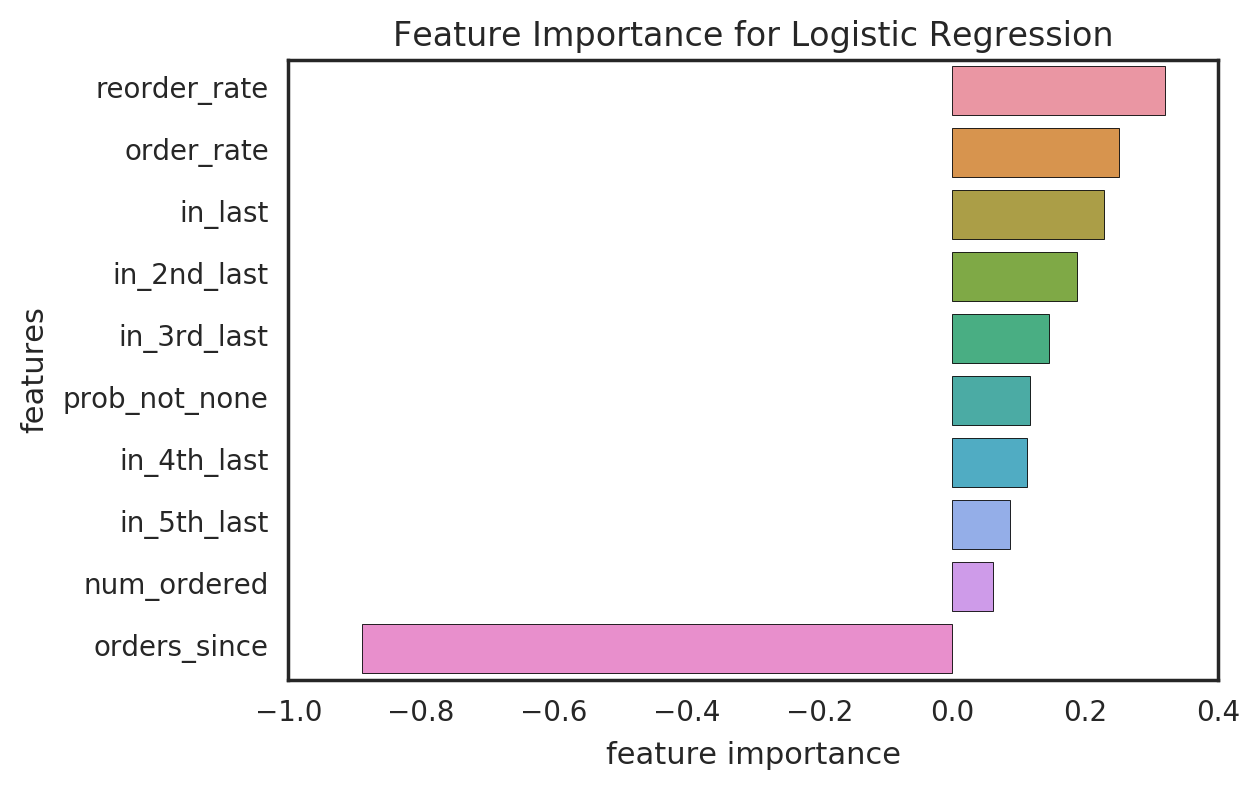

In [18]:
coef_df = pd.DataFrame({
        'coef':best_lr2.coef_[0],
        'feature':X.columns})

coef_df = coef_df.sort_values('coef', ascending=False)
ax = sns.barplot(y='feature',x='coef',data=coef_df)
ax.set(xlabel='feature importance', ylabel='features',title='Feature Importance for Logistic Regression')
plt.show()

I also fit AdaBoost and Gradient Boosting classifiers.

In [19]:
boost2 = AdaBoostClassifier()
boost2.fit(X_train,y_train)
boost2.score(X_test,y_test)

0.92503999999999997

In [20]:
gb2 = GradientBoostingClassifier()
gb2.fit(X_train, y_train)
gb2.score(X_test, y_test)

0.92579999999999996

<a id="model-1"></a>
### Model With Customers With Less Than 10 Orders

#### Cross Validation

F1 scores are lower in cross validation for the training model with users with less than 10 orders. Here as elsewhere, it's harder to make predictions from less data.

In [21]:
predictors = ['order_rate','reorder_rate', 'in_last','in_2nd_last','in_3rd_last','in_4th_last',
                  'num_ordered','prob_not_none','in_5th_last','orders_since']
testing_cols= ['order_rate','reorder_rate', 'in_last','in_2nd_last','in_3rd_last','in_4th_last',
                'num_ordered','prob_not_none','in_5th_last','orders_since', 'in_train_order']

testing1 = train_model_1[testing_cols]
testing1 = testing1.sample(n=200000)
X = testing1[predictors]
y = testing1['in_train_order']

ss = StandardScaler()
Xs1 = ss.fit_transform(X)

print(cross_val_score(lr, Xs1, y, cv=3, scoring='f1'))
print(cross_val_score(boost, Xs1, y, cv=3, scoring='f1'))
print(cross_val_score(gb, Xs1, y, cv=3, scoring='f1'))

[ 0.25754527  0.26169154  0.25433718]
[ 0.25841568  0.26443694  0.24635251]
[ 0.24668255  0.24803449  0.23887707]


#### Fitting Classifiers

I take a new sample of data to fit classifiers on.

In [22]:
testing1 = train_model_1[testing_cols].sample(n=200000)
X = testing1[predictors]
y = testing1['in_train_order']

ss = StandardScaler()
Xs1 = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs1, y, test_size=0.25)

As above, I gridsearch for an optimal C score. 

In [23]:
gs_params = {
    'penalty':['l2'],
    'solver':['liblinear'],
    'C':np.logspace(-1,1,50)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=3, verbose=1, scoring='f1')

lr_gridsearch.fit(X_train, y_train)
print(lr_gridsearch.best_params_)
best_lr1 = lr_gridsearch.best_estimator_
print(best_lr1.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   41.6s finished


{'penalty': 'l2', 'C': 0.10000000000000001, 'solver': 'liblinear'}
0.86532


For the model with users with less than 10 orders, all feature clear the salience threshold.

In [24]:
from sklearn.feature_selection import RFECV

selector = RFECV(best_lr1, step=1, cv=10, verbose=False,scoring='f1')
selector = selector.fit(X_test, y_test)

print selector.support_
print selector.ranking_

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [26]:
rfecv_columns = np.array(predictors)[selector.support_]
rfecv_columns

array(['order_rate', 'reorder_rate', 'in_last', 'in_2nd_last',
       'in_3rd_last', 'in_4th_last', 'num_ordered', 'prob_not_none',
       'in_5th_last', 'orders_since'], 
      dtype='|S13')

For users with less than 10 orders, orders since is a much diminished though still salient negative predictor. The reorder rate is likewise the highest weighted positive predictor but a higher weighted coefficient. The presence of an item in a user’s last order is nearly tied with order rate as the penultimate positive predictor.

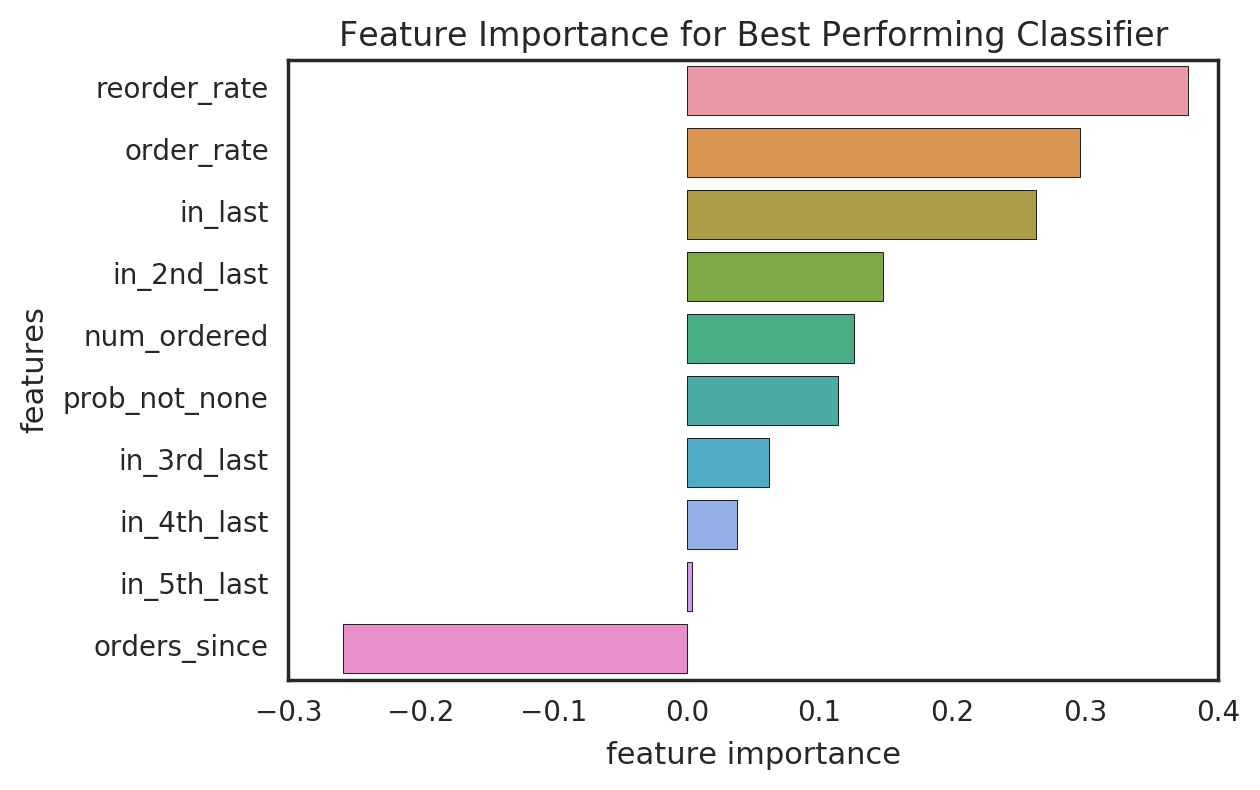

In [27]:
coef_df = pd.DataFrame({
        'coef':best_lr1.coef_[0],
        'feature':X.columns})

coef_df = coef_df.sort_values('coef', ascending=False)
ax = sns.barplot(y='feature',x='coef',data=coef_df)
ax.set(xlabel='feature importance', ylabel='features',title='Feature Importance for Best Performing Classifier')
plt.show()

I also fit AdaBoost and Gradient Boosting classifiers.

In [28]:
boost1 = AdaBoostClassifier()
boost1.fit(X_train,y_train)
boost1.score(X_test,y_test)

0.86465999999999998

In [29]:
gb1 = GradientBoostingClassifier()
gb1.fit(X_train, y_train)
gb1.score(X_test, y_test)

0.86484000000000005

<a id="local-validation"></a>
### Local Validation

#### Imputing Probabilities on Products

Here I impute values from the models fit above on all of the products in the order histories for 15,000 users in each training model. I use the random choice function to ensure the sample of users best represents the broader sample.

In [30]:
def model_for_scoring(train_df, lr, boost, gb):
    user_sample = np.random.choice(train_df['user_id'].unique(), 15000, replace=False)
    model_foreval = train_df[train_df['user_id'].isin(user_sample)]
    X = model_foreval[predictors]
    Xs = ss.fit_transform(X)
    prob_array_1 = lr.predict_proba(Xs)
    prob_array_2 = boost.predict_proba(Xs)
    prob_array_3 = gb.predict_proba(Xs)
    model_foreval['pp_lr'] = prob_array_1[:,1]
    model_foreval['pp_boost'] = prob_array_2[:,1]
    model_foreval['pp_gb'] = prob_array_3[:,1]
    return model_foreval

In [31]:
model_foreval_2 = model_for_scoring(train_model_2, best_lr2, boost2, gb2)
model_foreval_1 = model_for_scoring(train_model_1, best_lr1, boost1, gb1)

#### Predicting Products 

I defined a class that first takes in the dataframe with the products and probabilities and groups all products with a greater likelihood of being in the next order than a probability floor that I set, according to the classifier I choose. 

A handful of users, will not have any products above the threshold I set. For those users, I add the product ID for 'None' and add them to the larger model. This gets all models to the equivalent number of orders in the sample.

Lastly, I merge the order_id for each sample users' training order (meaning an order in training eval set, not the prior eval set.)

In [37]:
class ScoreModels(object):
    
    def __init__(self, model_df):
        self.model_ = model_df
        self.classifier_ = None
        self.not_null_ = None
        
    def fit(self, col, threshold_num):
        ''' get products above selected classifier's threshold '''
        model_subset = self.model_[self.model_[col] > threshold_num]
        model_subset = pd.DataFrame(model_subset.groupby('user_id')['product_id'].apply(list)).reset_index()
        model_subset.columns = ['user_id','product_id_pred']
        self.not_null_ = model_subset.shape[0]
        ''' add NaNs for orders where no products met threshold '''
        ids = model_subset['user_id'].unique()
        mask = -self.model_['user_id'].isin(ids)
        null_users = self.model_[mask]['user_id'].unique()
        null_preds = pd.DataFrame(data=null_users, columns=['user_id'])
        null_preds['product_id_pred'] = 49699
        updated_df = pd.concat([null_preds, model_subset],ignore_index=True) 
        ''' get order IDs '''
        train_orders = orders[orders['eval_set']=='train']
        merged_df = pd.merge(updated_df, train_orders, on='user_id', how='inner')
        merged_df = merged_df[['user_id','product_id_pred','order_id']]
        self.classifier_ = merged_df
        
    def score_model(self, real_orders):
        real, pred = dfs_to_score(real_orders, self.classifier_) ## defined below
        pred['product_id_pred'] = pred['product_id_pred'].map(list_to_string) ## defined below
        real['product_id_real'] = real['product_id_real'].map(list_to_string)
        scores = score_order_predictions(real, pred, return_df=True, show_wrong_IDs=True) ## defined below
        return scores

In [40]:
lr1 = ScoreModels(model_foreval_1)
lr1.fit('pp_lr', .186)
print('lr1 model orders with reorders: ' +str(lr1.not_null_))
lr1.classifier_.sample(n=3)

lr1 model orders with reorders: 14943


,user_id,product_id_pred,order_id
6933,96485,"[19894, 30776, 22328, 30353, 39475]",2430104
4939,69080,"[13176, 5876, 46842, 26369, 47357, 2275, 19171]",71469
2686,37661,"[25466, 12212, 42486]",603323


In [42]:
boost1 = ScoreModels(model_foreval_1)
boost1.fit('pp_boost', .4942)
print('boost1 model orders with reorders: ' +str(boost1.not_null_))

boost1 model orders with reorders: 14768


In [44]:
gb1 = ScoreModels(model_foreval_1)
gb1.fit('pp_gb', .237)
print('gb1 model orders with reorders: ' +str(gb1.not_null_))

gb1 model orders with reorders: 14783


In [45]:
lr2 = ScoreModels(model_foreval_2)
lr2.fit('pp_lr', .177)
print('lr2 model orders with reorders: ' +str(lr2.not_null_))

lr2 model orders with reorders: 14893


In [46]:
boost2 = ScoreModels(model_foreval_2)
boost2.fit('pp_boost', .4942)
print('boost2 model orders with reorders: ' +str(boost2.not_null_))

boost2 model orders with reorders: 14738


In [47]:
gb2 = ScoreModels(model_foreval_2)
gb2.fit('pp_gb', .23)
print('gb2 model orders with reorders: ' +str(gb2.not_null_))

gb2 model orders with reorders: 14800


I group the users in each 15,000 person training sample with the real products in their orders - what I'm trying to predict. 

In [48]:
def get_real_orders(model_foreval):
    train_orders = orders[orders['eval_set']=='train']
    score_users = pd.merge(model_foreval, train_orders, on='user_id', how='inner')
    eval_index = score_users['order_id'].unique()
    mask = (order_products_train['order_id'].isin(eval_index)) & (order_products_train['reordered']==1)
    ord_foreval = order_products_train[mask]
    ord_foreval = pd.DataFrame(ord_foreval.groupby(
        'order_id')['product_id'].apply(list)).reset_index()
    ord_foreval.columns = ['order_id','product_id_real']
    return ord_foreval

In [49]:
ord_foreval_1 = get_real_orders(model_foreval_1)
ord_foreval_2 = get_real_orders(model_foreval_2)

#### Scoring Models

A few functions are necessary to take the predictions I've compiled above and score them.

The first function, dfs_to_score, takes two dataframes, one with a list of predicted products and orders without products, representing an order for each user in the sample, and one for orders in the same sample with the actual products ordered. The function outputs two dataframes, each with orders for all users in the sample.

The function list_to_string takes the list of numeric product id's for each order and converts them into a space delimited string for use in the scoring function.

The function score_order_predictions, orginally from https://www.kaggle.com/frankherfert/local-validation-with-detailed-product-comparison, compares two dataframes, those generated by dfs_to_score and then outputs precision, recall, and f1 scores as well as a dataframe with wrong guesses and missed products. The latter enables me to conduct residual analysis to evaluate each model's performance.

In [50]:
def dfs_to_score(real_df, model_df):
    merged_df = pd.merge(model_df, real_df, on='order_id', how='left')
    df_real = merged_df[['order_id','product_id_real']]
    df_pred = merged_df[['order_id','product_id_pred']]
    return df_real, df_pred

In [51]:
def list_to_string(test_row):
    ''' Convert list of products into space-delimited list, for submission'''
    test_row = str(test_row)
    test_row = test_row.replace('[','')
    test_row = test_row.replace(']','')
    test_row = test_row.replace(',', ' ')
    updated_row = test_row
    return(updated_row)

In [52]:
def score_order_predictions(df_real, df_pred, return_df=True, show_wrong_IDs=True):
    '''
    Print out the total weighted precision, recall and F1-Score for the given true and predicted orders.
    
    return_df:  if set to True, a new DataFrame with added columns for precision, recall and F1-Score will be returned.
    
    show_wrong_IDs: if set to True, two columns with the IDs that the prediction missed and incorrectly predicted will be added. Needs return_df to be True.
    '''
    df_combined = pd.merge(df_real, df_pred, on="order_id", suffixes=("_real", "_pred"))
    
    df_combined["real_array"] = df_combined["product_id_real"].apply(lambda x: x.split())
    df_combined["pred_array"] = df_combined["product_id_pred"].apply(lambda x: x.split())
    
    df_combined["num_real"] = df_combined["product_id_real"].apply(lambda x: len(x.split()))
    df_combined["num_pred"] = df_combined["product_id_pred"].apply(lambda x: len(x.split()))

    df_combined["num_pred_correct"] = np.nan
    for i in df_combined.index:
        df_combined.loc[i, "num_pred_correct"] = len([e for e in df_combined.loc[i,"real_array"]
                                                      if e    in df_combined.loc[i,"pred_array"]])
    if show_wrong_IDs==True:
        df_combined["IDs_missing"] = np.empty((len(df_combined), 0)).tolist()
        for i in df_combined.index:
            missing = np.in1d(df_combined.loc[i, "real_array"], df_combined.loc[i,"pred_array"], invert=True)
            missing_values = np.array(df_combined.loc[i, "real_array"])[missing]
            df_combined.set_value(i, "IDs_missing", missing_values)
 
        df_combined["IDs_not_ordered"] = np.empty((len(df_combined), 0)).tolist()
        for i in df_combined.index:
            not_ordered = np.in1d(df_combined.loc[i, "pred_array"], df_combined.loc[i,"real_array"], invert=True)
            not_ordered_values = np.array(df_combined.loc[i, "pred_array"])[not_ordered]
            df_combined.set_value(i, "IDs_not_ordered", not_ordered_values)

    df_combined["precision"] = np.round(df_combined["num_pred_correct"] / df_combined["num_pred"], 4)
    df_combined["recall"]    = np.round(df_combined["num_pred_correct"] / df_combined["num_real"], 4)
    df_combined["F1-Score"]  = np.round(2*( (df_combined["precision"]*df_combined["recall"]) / 
                                           (df_combined["precision"]+df_combined["recall"]) ), 4)
    
    #recall_total =    df_combined["num_pred_correct"].sum() / df_combined["num_real"].sum()
    recall_total = np.mean(df_combined["recall"]) ##need to clarify if mean recall per order or weighted recall used
    precision_total = df_combined["num_pred_correct"].sum() / df_combined["num_pred"].sum()
    F1_total =  2* ( (precision_total * recall_total) / (precision_total + recall_total) )      
    
    print("F1-Score: ", round(F1_total, 4))
    print("recall:   ", round(recall_total, 4))
    print("precision:", round(precision_total, 4))
    
    df_combined.drop(["real_array", "pred_array", "num_real", "num_pred", "num_pred_correct"], axis=1, inplace=True)
    
    # reorder columns so that the scoring-columns appear first and
    # all other on the right of them (bad readability with many IDs)
    df_combined = pd.concat([df_combined.loc[:, "order_id"], 
                             df_combined.iloc[:, -3:],
                             df_combined.iloc[:, 1:-3]], 
                            axis=1)
    if return_df==True:
        return df_combined
    else: 
        return None

#### Scoring Users With Less Than 10 Orders

Each classifier, though their probabilities for each product vary, performs roughly the same, though after tuning the probability threshold the logistic regression scores best.

In [53]:
lr_1_scores = lr1.score_model(ord_foreval_1)
lr_1_scores.sample(n=5)

('F1-Score: ', 0.4188)
('recall:   ', 0.5053)
('precision:', 0.3575)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
3004,1145823,0.1667,1.000,0.2858,7862,13176 17122 21137 43352 30162 7862,[],"[13176, 17122, 21137, 43352, 30162]"
5591,2305996,0.2500,1.000,0.4000,28571,21903 33787 47626 28571,[],"[21903, 33787, 47626]"
6807,3273466,0.6667,1.000,0.8000,43961 13176,13176 21903 43961,[],[21903]
6620,1044067,0.5000,0.375,0.4286,46023 35221 32773 23067 2797 20468 24852...,24852 35221 41387 23067 10252 2632,"[46023, 32773, 2797, 20468, 6550]","[41387, 10252, 2632]"
1369,1200992,0.0000,0.000,NaN,8710,39146,[8710],[39146]


In [54]:
boost_1_scores = boost1.score_model(ord_foreval_1)
boost_1_scores.sample(n=5)

('F1-Score: ', 0.412)
('recall:   ', 0.428)
('precision:', 0.3971)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
3138,267491,0.4167,0.7143,0.5263,22124 4920 20090 42828 49610 24184 22281,13176 22124 21903 4920 22281 48595 33120...,"[42828, 24184]","[13176, 21903, 48595, 33120, 17949, 31242, 26047]"
13266,1819538,0.0000,0.0000,NaN,33869 35894 23524,27 43780,"[33869, 35894, 23524]","[27, 43780]"
8246,887484,0.0000,0.0000,NaN,4920 26131 48733 37646 17461,49699 47626 4429,"[4920, 26131, 48733, 37646, 17461]","[49699, 47626, 4429]"
291,2555679,0.5000,0.3333,0.4000,43631 26586 40142,49699 43631,"[26586, 40142]",[49699]
4733,977773,0.5000,0.8333,0.6250,9124 34217 42450 41373 19871 18022,9124 42450 17008 34217 40332 10673 19871...,[18022],"[17008, 40332, 10673, 5485, 11826]"


In [55]:
gb_1_scores = gb1.score_model(ord_foreval_1)
gb_1_scores.sample(n=5)

('F1-Score: ', 0.4156)
('recall:   ', 0.4366)
('precision:', 0.3965)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
382,26611,0.0000,0.0,NaN,49699,48988 38200 35504,[49699],"[48988, 38200, 35504]"
10697,2253943,0.5000,1.0,0.6667,28427,42450 28427,[],[42450]
7501,2630618,0.2500,0.2,0.2222,12341 43352 33279 8571 116,12341 38768 8803 38883,"[43352, 33279, 8571, 116]","[38768, 8803, 38883]"
12406,1468630,0.0000,0.0,NaN,39581 43352 12341 20583 6383 33044 32684...,49699,"[39581, 43352, 12341, 20583, 6383, 33044, 3268...",[49699]
5203,1284044,0.2857,0.5,0.3636,30668 48183 28204 24852 45251 30174 3880...,5322 24852 47144 45007 15290 21019 28204...,"[30668, 48183, 3880, 4605]","[5322, 47144, 45007, 15290, 21019, 2091, 36640..."


#### Users With 10 or More Orders

As with the model for users with fewer orders, each classifier performs roughly the same, though after tuning the probability threshold logistic regression again scores best.

In [56]:
lr_2_scores = lr2.score_model(ord_foreval_2)
lr_2_scores.sample(n=5)

('F1-Score: ', 0.4213)
('recall:   ', 0.4634)
('precision:', 0.3863)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
4935,3169185,0.3333,0.5000,0.4000,47141 20876,44632 47141 37658,[20876],"[44632, 37658]"
4639,2089438,0.0000,0.0000,NaN,27156 48364 31343 30391,27845 38689 30442,"[27156, 48364, 31343, 30391]","[27845, 38689, 30442]"
6593,387490,0.1667,0.1667,0.1667,9124 33957 25642 5450 24852 24062,24852 26604 24214 18583 12208 20602,"[9124, 33957, 25642, 5450, 24062]","[26604, 24214, 18583, 12208, 20602]"
7470,2841014,0.4000,0.4000,0.4000,17759 17630 26689 43622 8153,44632 17630 17634 39427 26689,"[17759, 43622, 8153]","[44632, 17634, 39427]"
3591,2955227,0.5000,1.0000,0.6667,37646,37646 43295,[],[43295]


In [57]:
boost_2_scores = boost2.score_model(ord_foreval_2)
boost_2_scores.sample(n=5)

('F1-Score: ', 0.4153)
('recall:   ', 0.4177)
('precision:', 0.413)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
13578,451061,1.0000,0.6500,0.7879,1463 10070 27086 37388 29544 25949 1234 ...,14947 27086 35958 25949 1463 44479 10070...,"[1234, 37029, 37141, 43858, 14764, 13702, 26096]",[]
11393,2116528,0.3571,1.0000,0.5263,22035 42445 22963 21903 42828 9825 24385...,5322 19057 22963 27344 47209 21137 21903...,[],"[5322, 47209, 21137, 48679, 30391, 38777, 2710..."
9233,2251895,0.2500,0.3333,0.2857,1463 27966 31343 37067 22151 4920,24852 39928 47209 21137 11777 37067 1463...,"[27966, 31343, 22151, 4920]","[24852, 39928, 47209, 21137, 11777, 11422]"
11628,1280209,0.0000,0.0000,NaN,23313 43195 43200 20244 17008 17022 516 ...,17923 47877 27958 39758 31981 43209 2719...,"[23313, 43195, 43200, 20244, 17008, 17022, 516...","[17923, 47877, 27958, 39758, 31981, 43209, 271..."
5065,1084056,0.5000,1.0000,0.6667,19904,19613 19904,[],[19613]


In [58]:
gb_2_scores = gb2.score_model(ord_foreval_2)
gb_2_scores.sample(n=5)

('F1-Score: ', 0.4187)
('recall:   ', 0.4336)
('precision:', 0.4049)


,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,IDs_missing,IDs_not_ordered
2992,2246297,0.2500,0.3750,0.3000,45125 1396 13944 32158 47962 40136 19307...,8424 32158 44799 8590 18893 29487 16816 ...,"[1396, 13944, 47962, 19307, 46402]","[8424, 44799, 8590, 18893, 29487, 16816, 11461..."
3689,1502073,0.4444,0.4444,0.4444,11440 14778 27086 5194 13740 32740 8758 ...,5194 5612 14778 2581 11440 31802 32740 ...,"[27086, 13740, 8758, 26177, 7751]","[5612, 2581, 31802, 13776, 20837]"
4747,3185505,0.6000,0.7500,0.6667,20161 15263 33331 38739 39708 17616 4855...,44234 38739 17616 48559 23909 23410 9020...,"[45438, 24852, 31066]","[44234, 23909, 23410, 23634, 25266, 46656]"
4951,1742018,0.6667,0.8000,0.7273,24549 6287 2966 7091 22950,33754 2966 6287 24549 25824 7091,[22950],"[33754, 25824]"
5812,2240147,0.5714,0.6667,0.6154,4562 36316 10193 35123 40795 15100 29487...,43352 9076 35123 43772 36316 4562 25544 ...,"[10690, 17119, 10102, 19468]","[43352, 9076, 43772, 17640, 35378, 30170]"


I save both logistic regression scores for residual analysis.

In [103]:
lr_1_scores.to_csv('./best_lr_scores7a', index=False)
lr_2_scores.to_csv('./best_lr_scores7b', index=False)

<a id="analyzing-residuals"></a>
# Analyzing Residuals

<a id="converting-the-output"></a>
### Converting The Output

The advantage of having a local scoring validation tool, which I used to score the orders of selected users in the training sample, is that I can see products my model missed, products my model wrongly assumed were in customers' orders, and, with a minimal amount of work, products my model got correct. The disadvantage, however, is that by not coding the scoring function myself, I had no control over the output. And thus I need to do a bit of work to convert the output to a format I can analyze. 

In [3]:
df_scores_1 = pd.read_csv("./best_lr_scores7a")
df_scores_1 = df_scores_1.rename(columns={'IDs_missing':'missed','IDs_not_ordered':'wrong_guesses'})
df_scores_2 = pd.read_csv("./best_lr_scores7b")
df_scores_2 = df_scores_2.rename(columns={'IDs_missing':'missed','IDs_not_ordered':'wrong_guesses'})
df_scores_1.sample(n=1)

,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,missed,wrong_guesses
14625,495421,0.0588,0.25,0.0952,41349 36835 49570 39475,17758 24852 40198 45066 46886 9387 31215...,['41349' '36835' '49570'],['17758' '24852' '40198' '45066' '46886' '9387...


In the first step here, I take the space delimited strings in both product_id columns as well as the missed and wrong_guesses columns and convert those back to lists of numeric product ids.

In [5]:
def get_prods(string):
    if '[' in string:
        string = string.replace('[','')
        string = string.replace(']','')
        string = string[1:-1]
        string = string.replace("'","")
    string = [int(i) for i in string.split()]
    return string

In [6]:
df_scores_1['missed'] = df_scores_1['missed'].map(get_prods)
df_scores_1['wrong_guesses'] = df_scores_1['wrong_guesses'].map(get_prods)
df_scores_1['product_id_pred'] = df_scores_1['product_id_pred'].map(get_prods)
df_scores_1['product_id_real'] = df_scores_1['product_id_real'].map(get_prods)
df_scores_1.head(3)

,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,missed,wrong_guesses
0,3303454,1.0,1.0,1.0,[49699],[49699],[],[]
1,2402557,0.0,0.0,NaN,[26367],[49699],[26367],[49699]
2,1569245,0.0,0.0,NaN,[39428],[49699],[39428],[49699]


In [7]:
df_scores_2['missed'] = df_scores_2['missed'].map(get_prods)
df_scores_2['wrong_guesses'] = df_scores_2['wrong_guesses'].map(get_prods)
df_scores_2['product_id_pred'] = df_scores_2['product_id_pred'].map(get_prods)
df_scores_2['product_id_real'] = df_scores_2['product_id_real'].map(get_prods)

#### Adding Correct Predictions

Next compare the products in each product_id list to identify which predicted products were in the real order. I then take these products and create a new column, correct, with a list of product ids in integer form.

In [8]:
def correct(df):
    for i in df.index:
        correct = []
        for prod in df['product_id_pred'][i]:
            real = df['product_id_real'][i]
            if prod in real:
                correct.append(prod)
        correct = str(correct)
        correct =  correct.replace(',','')
        df.ix[i,'correct'] = correct[1:-1]
    return df

In [9]:
df_scores_1 = correct(df_scores_1)
df_scores_2 = correct(df_scores_2)
df_scores_1.head(3)

,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,missed,wrong_guesses,correct
0,3303454,1.0,1.0,1.0,[49699],[49699],[],[],49699
1,2402557,0.0,0.0,NaN,[26367],[49699],[26367],[49699],
2,1569245,0.0,0.0,NaN,[39428],[49699],[39428],[49699],


In [11]:
df_scores_1['correct'] = df_scores_1['correct'].map(get_prods)
df_scores_2['correct'] = df_scores_2['correct'].map(get_prods)
df_scores_1.head(3)

,order_id,precision,recall,F1-Score,product_id_real,product_id_pred,missed,wrong_guesses,correct
0,3303454,1.0,1.0,1.0,[49699],[49699],[],[],[49699]
1,2402557,0.0,0.0,NaN,[26367],[49699],[26367],[49699],[]
2,1569245,0.0,0.0,NaN,[39428],[49699],[39428],[49699],[]


<a id="creating-dataframes"></a>
### Creating Missed, Wrong, and Correct Dataframes

Products in list form are difficult to analyze, so here I unpack the products into separate dataframes, each capturing the order_id, product_id, whether the classifer guessed the product, and whether the item was actually in the training order. This function runs very slowly.

In [13]:
def create_df(residuals_df,col,guessed_num, in_order_num):
    new_df = pd.DataFrame(columns=['order_id','product_id','guessed','in_order'])
    index = 0
    for i in residuals_df.index:
        for prod in residuals_df[col][i]:
            new_df.loc[index,'order_id'] = residuals_df['order_id'][i]
            new_df.loc[index,'product_id'] = prod
            new_df.loc[index,'guessed'] = guessed_num
            new_df.loc[index,'in_order'] = in_order_num
            index += 1
    return new_df

In [14]:
missed_df_1 = create_df(df_scores_1,'missed',0,1)
print('missed_df_1 shape: ' +str(missed_df_1.shape[0]))
missed_df_1.head(1)

missed_df_1 shape: 35456


,order_id,product_id,guessed,in_order
0,2402557,26367,0,1


In [16]:
missed_df_2 = create_df(df_scores_2,'missed',0,1)
print('missed_df_2 shape: ' +str(missed_df_2.shape[0]))
missed_df_2.head(1)

missed_df_2 shape: 60320


,order_id,product_id,guessed,in_order
0,1492872,37528,0,1


In [17]:
correct_df_1 = create_df(df_scores_1,'correct',1,1)
print('correct_df_1 shape: ' +str(correct_df_1.shape[0]))
correct_df_1.head()

correct_df_1 shape: 40122


,order_id,product_id,guessed,in_order
0,3303454,49699,1,1
1,2415572,49699,1,1
2,368898,49699,1,1
3,2305080,49699,1,1
4,412672,49699,1,1


In [18]:
correct_df_2 = create_df(df_scores_2,'correct',1,1)
print('correct_df_2 shape: ' +str(correct_df_2.shape[0]))
correct_df_2.head()

correct_df_2 shape: 57734


,order_id,product_id,guessed,in_order
0,419646,49699,1,1
1,1638066,49699,1,1
2,1170025,49699,1,1
3,115088,49699,1,1
4,1035469,49699,1,1


In [19]:
wrong_df_1 = create_df(df_scores_1,'wrong_guesses',1,0)
print('wrong_df_1 shape: ' +str(wrong_df_1.shape[0]))
wrong_df_1.head()

wrong_df_1 shape: 72703


,order_id,product_id,guessed,in_order
0,2402557,49699,1,0
1,1569245,49699,1,0
2,1638647,49699,1,0
3,1910801,49699,1,0
4,3058409,49699,1,0


In [20]:
wrong_df_2 = create_df(df_scores_2,'wrong_guesses',1,0)
print('wrong_df_2 shape: ' +str(wrong_df_2.shape[0]))
wrong_df_2.head()

wrong_df_2 shape: 91350


,order_id,product_id,guessed,in_order
0,1492872,49699,1,0
1,2917884,49699,1,0
2,1713286,49699,1,0
3,1336047,49699,1,0
4,1699057,49699,1,0


In [21]:
frames = [correct_df_1,missed_df_1,wrong_df_1]
residuals = pd.concat(frames, ignore_index=True)
print('Number of residuals <10: ' + str(residuals.shape[0]))
residuals.to_csv('./best_lr_residuals4a',index=False)

Number of residuals <10: 148281


In [22]:
frames = [correct_df_2,missed_df_2,wrong_df_2]
residuals = pd.concat(frames, ignore_index=True)
print('Number of residuals >=10: ' + str(residuals.shape[0]))
residuals.to_csv('./best_lr_residuals4b',index=False)

Number of residuals >=10: 209404


In [3]:
lr_residuals_1 = pd.read_csv("./best_lr_residuals4a")
lr_residuals_2 = pd.read_csv("./best_lr_residuals4b")

In [13]:
def nulls_df(residuals_df):
    nulls = residuals_df[residuals_df['product_id']==49699]
    nulls = pd.merge(nulls, orders, on='order_id',how='inner')
    correct = (nulls['guessed']==1) & (nulls['in_order']==1)
    print('Correct predictions of no reordered products: ' + str(nulls[correct].shape[0]))
    incorrect = (nulls['guessed']==1) & (nulls['in_order']==0)
    print('Inorrect predictions of no reordered products: ' + str(nulls[incorrect].shape[0]))
    missed = (nulls['guessed']==0) & (nulls['in_order']==1)
    print('Missed Instances of no reordered products: ' + str(nulls[missed].shape[0]))
    print('Precision of no reordered products predictions: ' + str((
                float(nulls[correct].shape[0]) / (nulls[correct].shape[0] + nulls[incorrect].shape[0]))))
    print('Recall of orders with no reordered products: ' + str((
                float(nulls[correct].shape[0]) / (nulls[correct].shape[0] + nulls[missed].shape[0]))))
    return nulls

<a id="less-than-10"></a>
### Analyzing Users With Less Than 10 Orders

#### None Handling

While my model's precision and recall for orders without reordered products (cases where 'None' is the product) is worse than for the model as a whole, the results here are a vast improvement from earlier iterations of my model. Specifically, wheras earlier model iterations had 13-14% recall of None orders, recall for users with less than 10 orders is now 150% better, albeit at some cost to precision (going from ~36% to 30% here). The improvement here is probably attributable to both treating None instances as a product and intermixing None with product predictions in marginal cases.

In [14]:
nulls = nulls_df(lr_residuals_1)

Correct predictions of no reordered products: 493
Inorrect predictions of no reordered products: 1161
Missed Instances of no reordered products: 932
Precision of no reordered products predictions: 0.298065296252
Recall of orders with no reordered products: 0.345964912281


The functions below enable comparing the number of correct, incorrect, and missed products by whatever organizing feature is convenient - department, aisle, and product, days since prior order, or number of orders per user, etc. With counts for correct, incorrect, and missed products, I can calculate precision and recall for each unique aspect of the organizing feature - specific departments, aisles, etc.

In [5]:
#grouping product-level by product counts
def grouped_df(df,col,col_name,guessed_num,in_order_num):
    mask = (df['guessed']==guessed_num) & (df['in_order']==in_order_num)
    masked_df = df[mask]
    grouped_df = masked_df.groupby(col)[['product_id']].count().reset_index()
    grouped_df.columns=[col,col_name]
    return grouped_df

In [6]:
#grouping product-level by conditional product counts and adding precision and recall
def dfs_with_pr(correct,incorrect,missed,col):
    dept_df = pd.merge(correct,incorrect,on=col,how='left')
    dept_df = pd.merge(dept_df,missed,on=col,how='left')
    dept_df['precision'] = dept_df['correct_products'] / (dept_df['correct_products']+dept_df['incorrect_products'])
    dept_df['recall'] = dept_df['correct_products'] / (dept_df['correct_products']+dept_df['missed_products'])
    return dept_df

In [19]:
def combined_dfs_with_pr(df, col):
    correct = grouped_df(df, col,'correct_products',1,1)
    incorrect = grouped_df(df, col,'incorrect_products',1,0)
    missed = grouped_df(df, col,'missed_products',0,1)
    df_all = dfs_with_pr(correct, incorrect, missed, col)
    return df_all

More than half of None orders in the sample happen 30 days after a previous order and in these instances precision and recall are very similar to the precision and recall of the model as a whole.

In [20]:
nd_all = combined_dfs_with_pr(nulls, 'days_since_prior_order')
nd_all.sort_values('missed_products', ascending=False).head()

,days_since_prior_order,correct_products,incorrect_products,missed_products,precision,recall
30,30.0,240,429,532,0.358744,0.310881
2,2.0,8,21,27,0.275862,0.228571
7,7.0,19,45,24,0.296875,0.441860
4,4.0,14,43,24,0.245614,0.368421
6,6.0,12,52,22,0.187500,0.352941


Looking at None instances by order number, the model seems to likewise classify each order with roughly consistent precision and recall, fluctuations in performance likely due to small smaples.

In [22]:
no_all = combined_dfs_with_pr(nulls, 'order_number')
no_all.sort_values('missed_products', ascending=False)

,order_number,correct_products,incorrect_products,missed_products,precision,recall
0,4,144,297,323,0.326531,0.308351
1,5,120,286,160,0.295567,0.428571
2,6,62,173,146,0.263830,0.298077
3,7,55,158,114,0.258216,0.325444
4,8,48,94,77,0.338028,0.384000
5,9,35,76,63,0.315315,0.357143
6,10,29,77,49,0.273585,0.371795


#### Department Analysis

With the residuals dataframe in place, I write a function to merge order and product information onto the residuals dataframe.

In [25]:
def residuals_df(residuals):
    residuals_df = pd.merge(residuals, products, on='product_id', how='inner')
    residuals_df = pd.merge(residuals_df, departments, on='department_id', how='inner')
    residuals_df = pd.merge(residuals_df, aisles, on='aisle_id', how='inner')
    orders_subset = orders[['order_id','user_id','order_dow','order_hour_of_day','days_since_prior_order',
                            'order_number']]
    residuals_df = pd.merge(residuals_df, orders_subset, on='order_id', how='inner')
    return residuals_df

In [26]:
lr_df_1 = residuals_df(lr_residuals_1)
lr_df_1.head(1)

,order_id,product_id,guessed,in_order,product_name,aisle_id,department_id,department,aisle,user_id,order_dow,order_hour_of_day,days_since_prior_order,order_number
0,3402036,33819,1,1,Original French Vanilla Yogurt,120,16,dairy eggs,yogurt,23,1,12,30.0,5


Looking first by department, and sorting by the departments where the model performed well, well being defined here as above .4, the model is fairly precise with the three highest volume departments: produce, dairy and eggs, and beverages. Recall is better with those departments still, with scores in each of these departments surpassing .6. 

These departments generally supply perishable products that people order frequently and consume quickly, aligning well with the features in the model.

In [29]:
dept_all = combined_dfs_with_pr(lr_df_1,'department')

In [13]:
def sort_inaccurate(df,prod_col,quantity_threshold,metric,metric_threshold):
    mask = (df[prod_col]>quantity_threshold) & (df[metric]<metric_threshold)
    return df[mask].sort_values(metric)

In [14]:
def sort_accurate(df,prod_col,quantity_threshold,metric,metric_threshold):
    mask = (df[prod_col]>quantity_threshold) & (df[metric]>metric_threshold)
    return df[mask].sort_values(metric)

In [26]:
dept_precise = sort_accurate(dept_all,'incorrect_products',200,'precision',.4)
dept_precise

,department,correct_products,incorrect_products,missed_products,precision,recall
3,beverages,4497,6426,2522,0.4117,0.64069


In [27]:
dept_recalled = sort_accurate(dept_all,'missed_products',200,'recall',.4)
dept_recalled

,department,correct_products,incorrect_products,missed_products,precision,recall
4,breakfast,652,1215,878,0.349223,0.426144
10,frozen,2335,4132,2997,0.361064,0.437922
1,babies,285,603,351,0.320946,0.448113
13,meat seafood,755,1591,908,0.321824,0.453999
20,snacks,2888,4907,3233,0.370494,0.471818
8,deli,1307,2366,1203,0.355840,0.520717
2,bakery,1503,2922,1228,0.339661,0.550348
19,produce,14746,28171,9327,0.343593,0.612553
7,dairy eggs,8221,13901,5052,0.371621,0.619378
3,beverages,4497,6426,2522,0.411700,0.640690


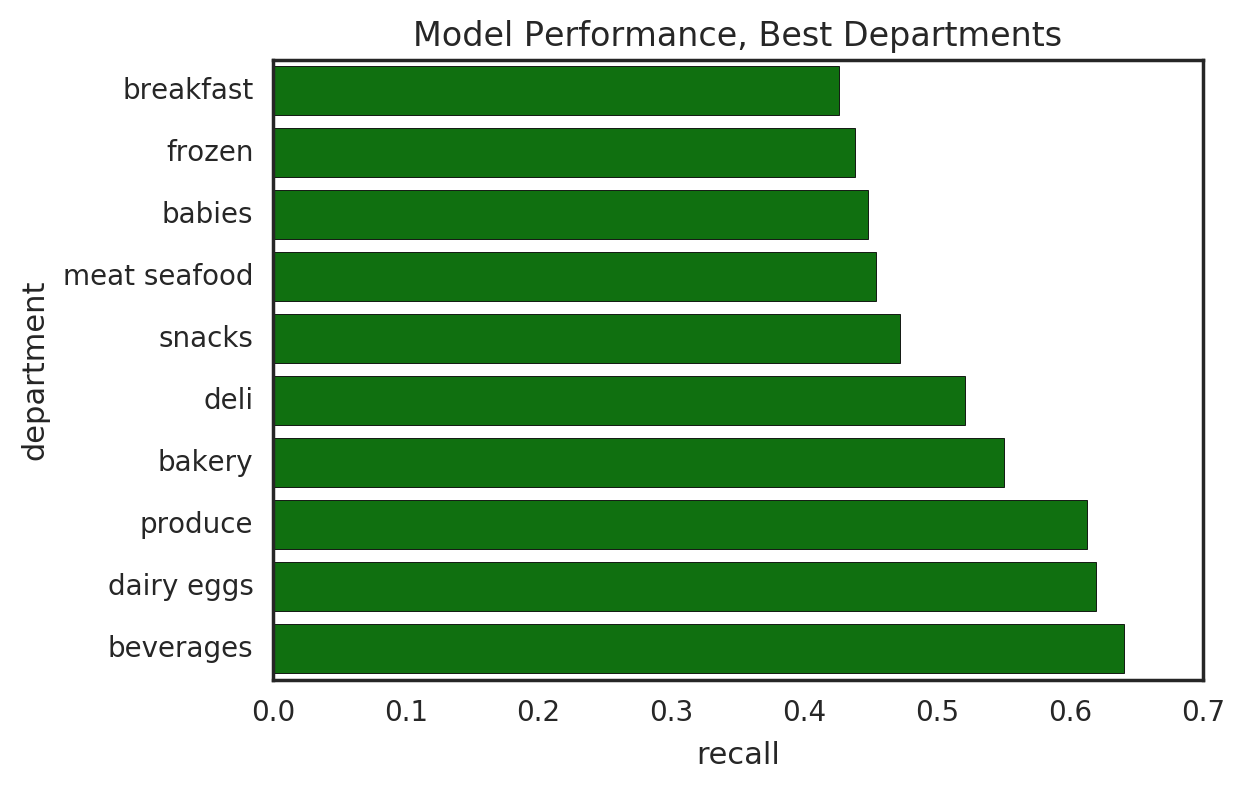

In [35]:
mask = dept_recalled['recall']>.4
masked = dept_recalled[mask]
ax = sns.barplot(y='department',x='recall',color='green',data=masked)
ax.set(xlabel='recall', ylabel='department',title='Model Performance, Best Departments')
plt.show()

Turning to where the model performs poorly, the major failure is in the recall of non-perishable products in departments like pantry, personal care, and household, with recall less than .3 across 6 departments. Products like spices, conditioner, and tile cleaner are not purchased frequently and often times not purchased again. They also keep around the house for a while. The features in the model are not a good fit for predicting the recurrence of these products. Though these are lower volumes departments, substaintial gains in recall could be made by improving on the model's performance in these departments.

Poor precision is a story of similar departments, though the lowest precision scores are markedly higher than the recall scores for those same departments, with nearly every department at or better than .3 precision.

In [36]:
dept_underestimated = sort_inaccurate(dept_all,'missed_products',100,'recall',.35)
dept_underestimated

,department,correct_products,incorrect_products,missed_products,precision,recall
17,personal care,106,227,463,0.318318,0.186292
16,pantry,468,1130,1893,0.292866,0.198221
11,household,303,667,981,0.312371,0.235981
12,international,90,190,285,0.321429,0.240000
6,canned goods,554,1329,1475,0.294211,0.273041
9,dry goods pasta,492,1043,1190,0.320521,0.292509
14,missing,85,117,167,0.420792,0.337302


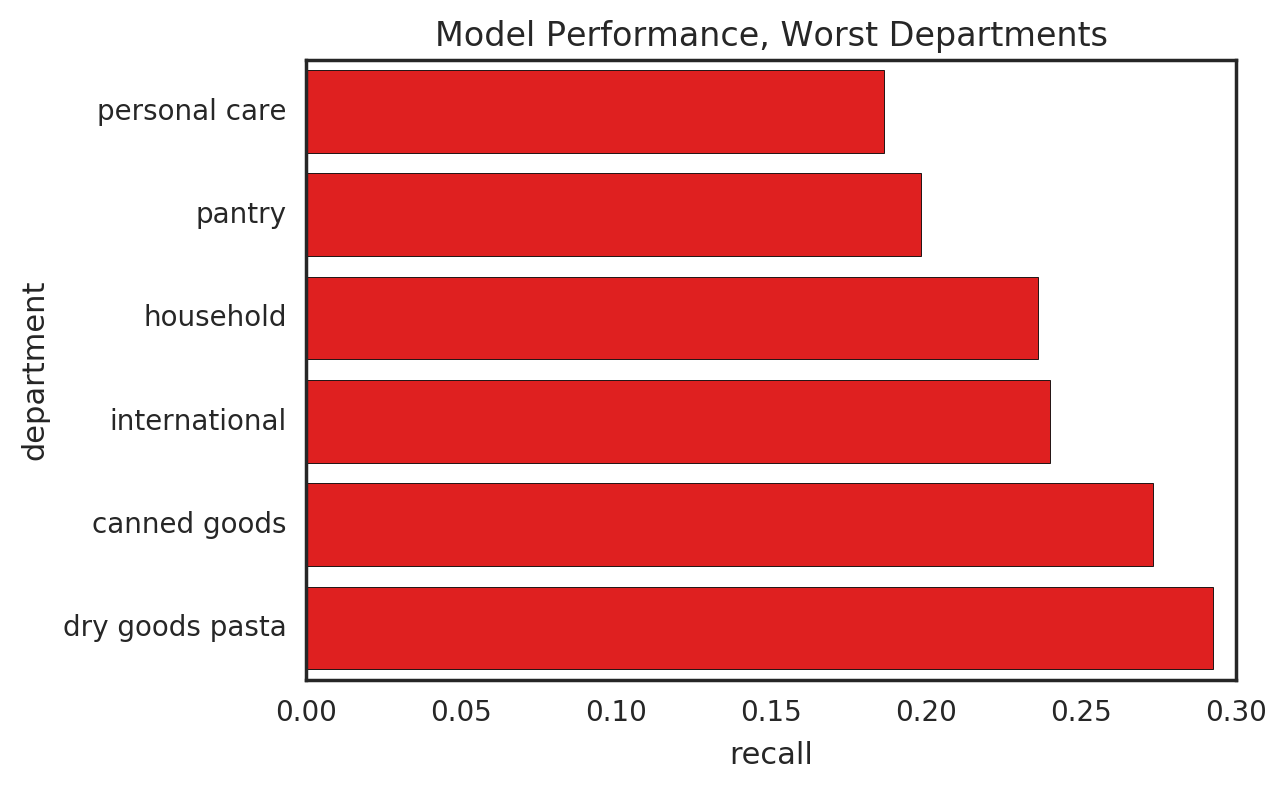

In [37]:
mask = dept_underestimated['department']!='missing'
masked = dept_underestimated[mask]
ax = sns.barplot(y='department',x='recall',color='red',data=masked)
ax.set(xlabel='recall', ylabel='department',title='Model Performance, Worst Departments')
plt.show()

In [38]:
dept_overestimated = sort_inaccurate(dept_all,'incorrect_products',200,'precision',.35)
dept_overestimated

,department,correct_products,incorrect_products,missed_products,precision,recall
16,pantry,468,1130,1893,0.292866,0.198221
6,canned goods,554,1329,1475,0.294211,0.273041
11,household,303,667,981,0.312371,0.235981
17,personal care,106,227,463,0.318318,0.186292
9,dry goods pasta,492,1043,1190,0.320521,0.292509
1,babies,285,603,351,0.320946,0.448113
13,meat seafood,755,1591,908,0.321824,0.453999
2,bakery,1503,2922,1228,0.339661,0.550348
19,produce,14746,28171,9327,0.343593,0.612553
18,pets,118,221,131,0.348083,0.473896


#### Precision and Recall by Number of Orders and Days Since Prior Order

As with the None cases, the model performs fairly consistently regardless of the total number of user orders for users with less than 10 orders.

In [31]:
orders_all = combined_dfs_with_pr(lr_df_1,'order_number')
mask = (orders_all['missed_products']>=100)
orders_all[mask].sort_values('recall')

,order_number,correct_products,incorrect_products,missed_products,precision,recall
6,10,3897,6986,3902,0.358081,0.499679
5,9,4563,7937,4318,0.365040,0.513793
3,7,5524,9858,5105,0.359121,0.519710
2,6,5980,11053,5308,0.351083,0.529766
4,8,5029,8415,4458,0.374070,0.530094
1,5,6984,12959,5559,0.350198,0.556805
0,4,7652,14334,5874,0.348040,0.565725


Looking at precision and recall by days since prior reorder, scores are markedly lower for orders made 1-3 days after a previous order than any other date. This is an odd but consistent finding meriting further investigation. However, the number of orders made during this period pales in comparison to the number of orders placed 30 days after a previous order, and greater gains could be realized by improving slightly on the precision for products purchased then.

In [32]:
days_all = combined_dfs_with_pr(lr_df_1,'days_since_prior_order')
days_all['days_since_prior_order'] = days_all['days_since_prior_order'].map(lambda x: int(x))
days_all[days_all['precision']<=.35]

,days_since_prior_order,correct_products,incorrect_products,missed_products,precision,recall
1,1,221,524,464,0.296644,0.322628
2,2,208,626,386,0.249400,0.350168
3,3,396,1184,446,0.250633,0.470309
4,4,657,1716,626,0.276865,0.512081
5,5,984,2040,846,0.325397,0.537705
30,30,13611,27144,13595,0.333971,0.500294


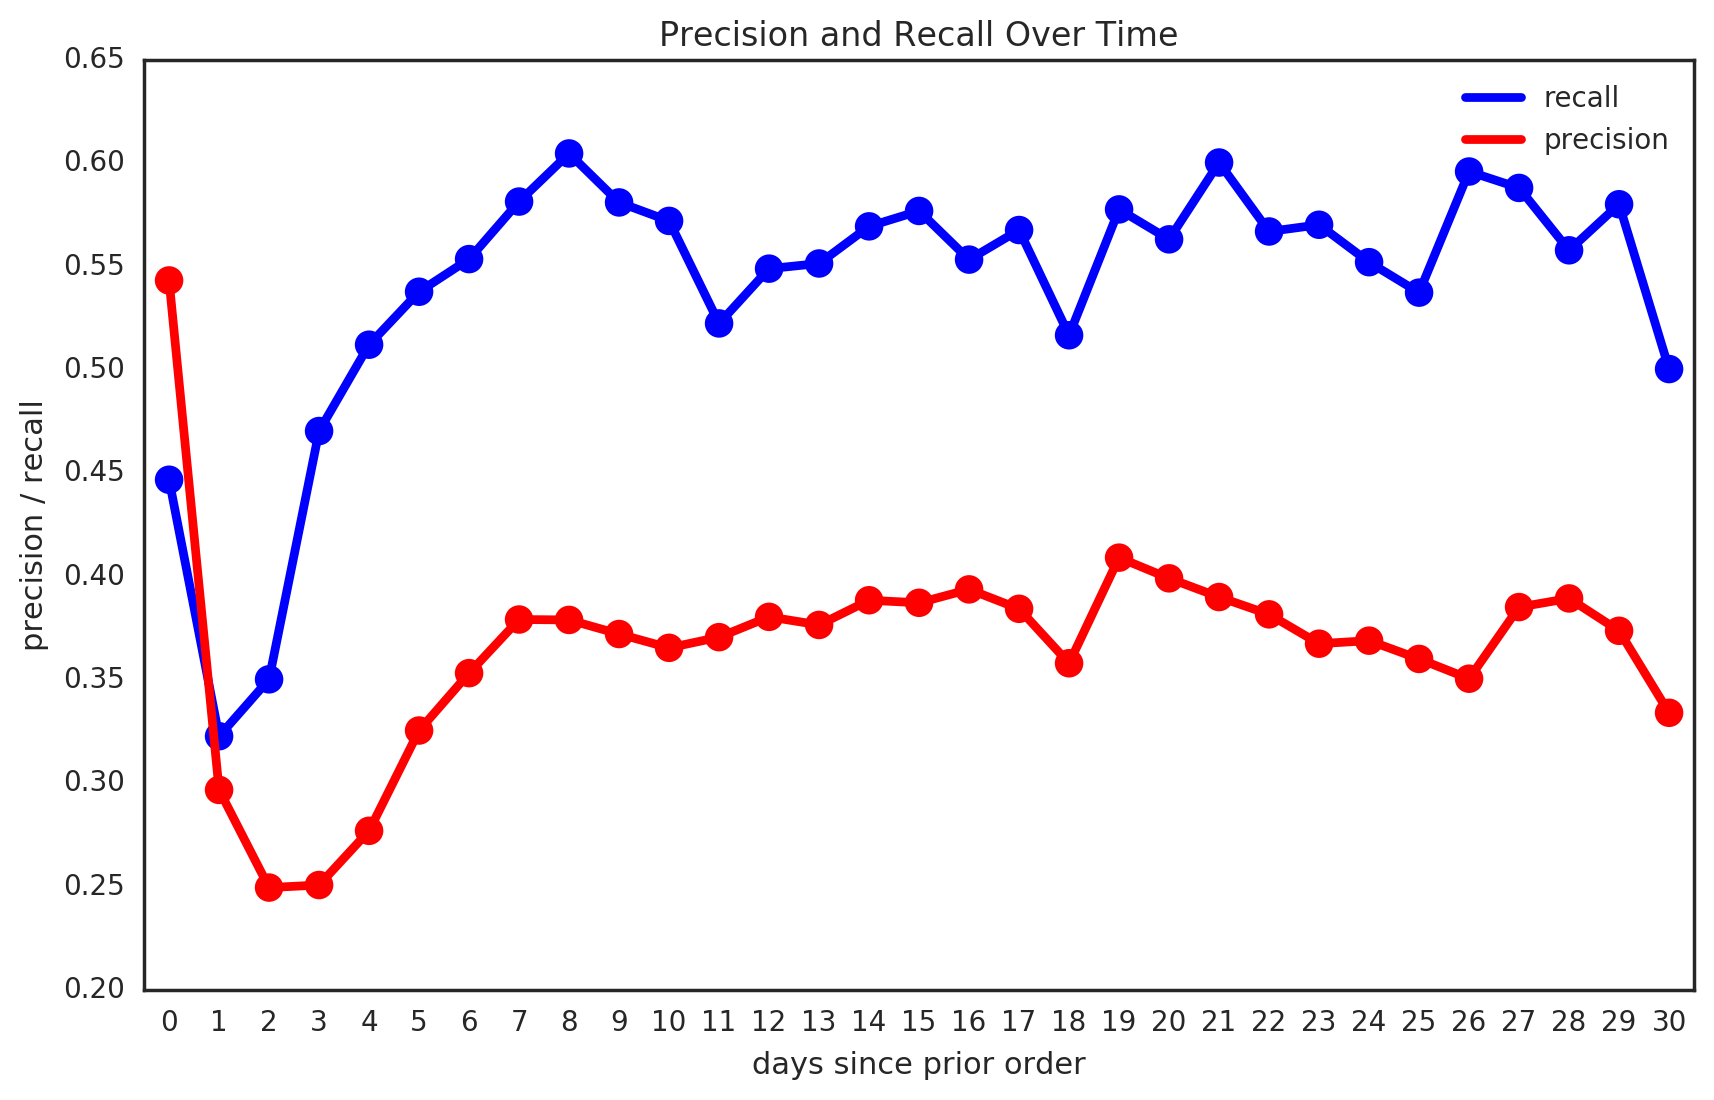

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
recall = sns.pointplot(y='recall',x='days_since_prior_order', color='blue',data=days_all, label='recall', ax=ax)
precision = sns.pointplot(y='precision',x='days_since_prior_order', color='red',data=days_all, label='precision', ax=ax)
ax.set(xlabel='days since prior order', ylabel='precision / recall',title='Precision and Recall Over Time')
ax.legend(handles=ax.lines[::len(days_all)+1], labels=["recall","precision"])
plt.show()

<a id="10-or-more"></a>
### Analyzing Users With 10 or More Orders

#### None Handling

Precision and recall for None instances are noticeably lower for users with 10 or more orders though they are much less common.

In [33]:
nulls = nulls_df(lr_residuals_2)

Correct predictions of no reordered products: 119
Inorrect predictions of no reordered products: 455
Missed Instances of no reordered products: 346
Precision of no reordered products predictions: 0.207317073171
Recall of orders with no reordered products: 0.255913978495


A plurarlity of None orders happen 30 days after a previous order and for these cases the model has a higher precision and recall than average.

In [34]:
nd_all = combined_dfs_with_pr(nulls,'days_since_prior_order')
nd_all.sort_values('missed_products',ascending=False).head()

,days_since_prior_order,correct_products,incorrect_products,missed_products,precision,recall
26,30.0,38,96,113,0.283582,0.251656
1,1.0,8,13,20,0.380952,0.285714
2,2.0,6,16,18,0.272727,0.250000
4,4.0,2,21,17,0.086957,0.105263
0,0.0,5,16,16,0.238095,0.238095


I do not look at None cases or model by performance by total orders for this user group, as total orders, anywhere between 11 and 100, are diffuse.

#### Department Analysis

Though the weight given to features is different for the model with only users with 10 or more orders, the features are the same for both, and the model's strengths and weaknesses are consistent. The model with more regular customers tends to be a bit more precise at the expense of an equivalent amount of recall, but fundamentally the departments with high as well as low precision and recall are the same as above.

In [35]:
lr_df_2 = residuals_df(lr_residuals_2)
dept_all = combined_dfs_with_pr(lr_df_2,'department')

In [15]:
dept_precise = sort_accurate(dept_all,'incorrect_products',200,'precision',.4)
dept_precise

,department,correct_products,incorrect_products,missed_products,precision,recall
18,pets,203,293,185,0.409274,0.523196
3,beverages,6378,8092,4083,0.440774,0.609693


In [16]:
dept_recalled = sort_accurate(dept_all,'missed_products',200,'recall',.4)
dept_recalled

,department,correct_products,incorrect_products,missed_products,precision,recall
10,frozen,3124,5214,4488,0.374670,0.410405
4,breakfast,988,1602,1392,0.381467,0.415126
1,babies,606,1094,793,0.356471,0.433167
20,snacks,4403,7197,5421,0.379569,0.448188
8,deli,1883,3098,1999,0.378037,0.485059
0,alcohol,214,329,223,0.394107,0.489703
2,bakery,2234,3640,2041,0.380320,0.522573
19,produce,21377,34027,17721,0.385839,0.546754
7,dairy eggs,12034,18115,8589,0.399151,0.583523
3,beverages,6378,8092,4083,0.440774,0.609693


In [17]:
dept_underestimated = sort_inaccurate(dept_all,'missed_products',100,'recall',.35)
dept_underestimated

,department,correct_products,incorrect_products,missed_products,precision,recall
17,personal care,169,299,878,0.361111,0.161414
16,pantry,721,1526,3693,0.320872,0.163344
11,household,461,898,1763,0.339220,0.207284
9,dry goods pasta,639,1381,2011,0.316337,0.241132
12,international,166,254,510,0.395238,0.245562
6,canned goods,796,1707,2269,0.318018,0.259706


In [18]:
dept_overestimated = sort_inaccurate(dept_all,'incorrect_products',200,'precision',.35)
dept_overestimated

,department,correct_products,incorrect_products,missed_products,precision,recall
9,dry goods pasta,639,1381,2011,0.316337,0.241132
6,canned goods,796,1707,2269,0.318018,0.259706
16,pantry,721,1526,3693,0.320872,0.163344
11,household,461,898,1763,0.339220,0.207284
13,meat seafood,956,1814,1447,0.345126,0.397836


#### Precision and Recall by Days Since Prior Order

Also as above, predictions on orders made 1-3 days following a previous order are noticeably worse, and in this instance represent more orders and products than in the other sample.

In [36]:
days_all = combined_dfs_with_pr(lr_df_2,'days_since_prior_order')
days_all['days_since_prior_order'] = days_all['days_since_prior_order'].map(lambda x: int(x))
days_all[days_all['precision']<=.35]

,days_since_prior_order,correct_products,incorrect_products,missed_products,precision,recall
1,1,728,2215,1416,0.247367,0.339552
2,2,1172,2801,2038,0.294991,0.365109
3,3,1915,4514,2501,0.297869,0.433650
4,4,2783,5197,3141,0.348747,0.469784


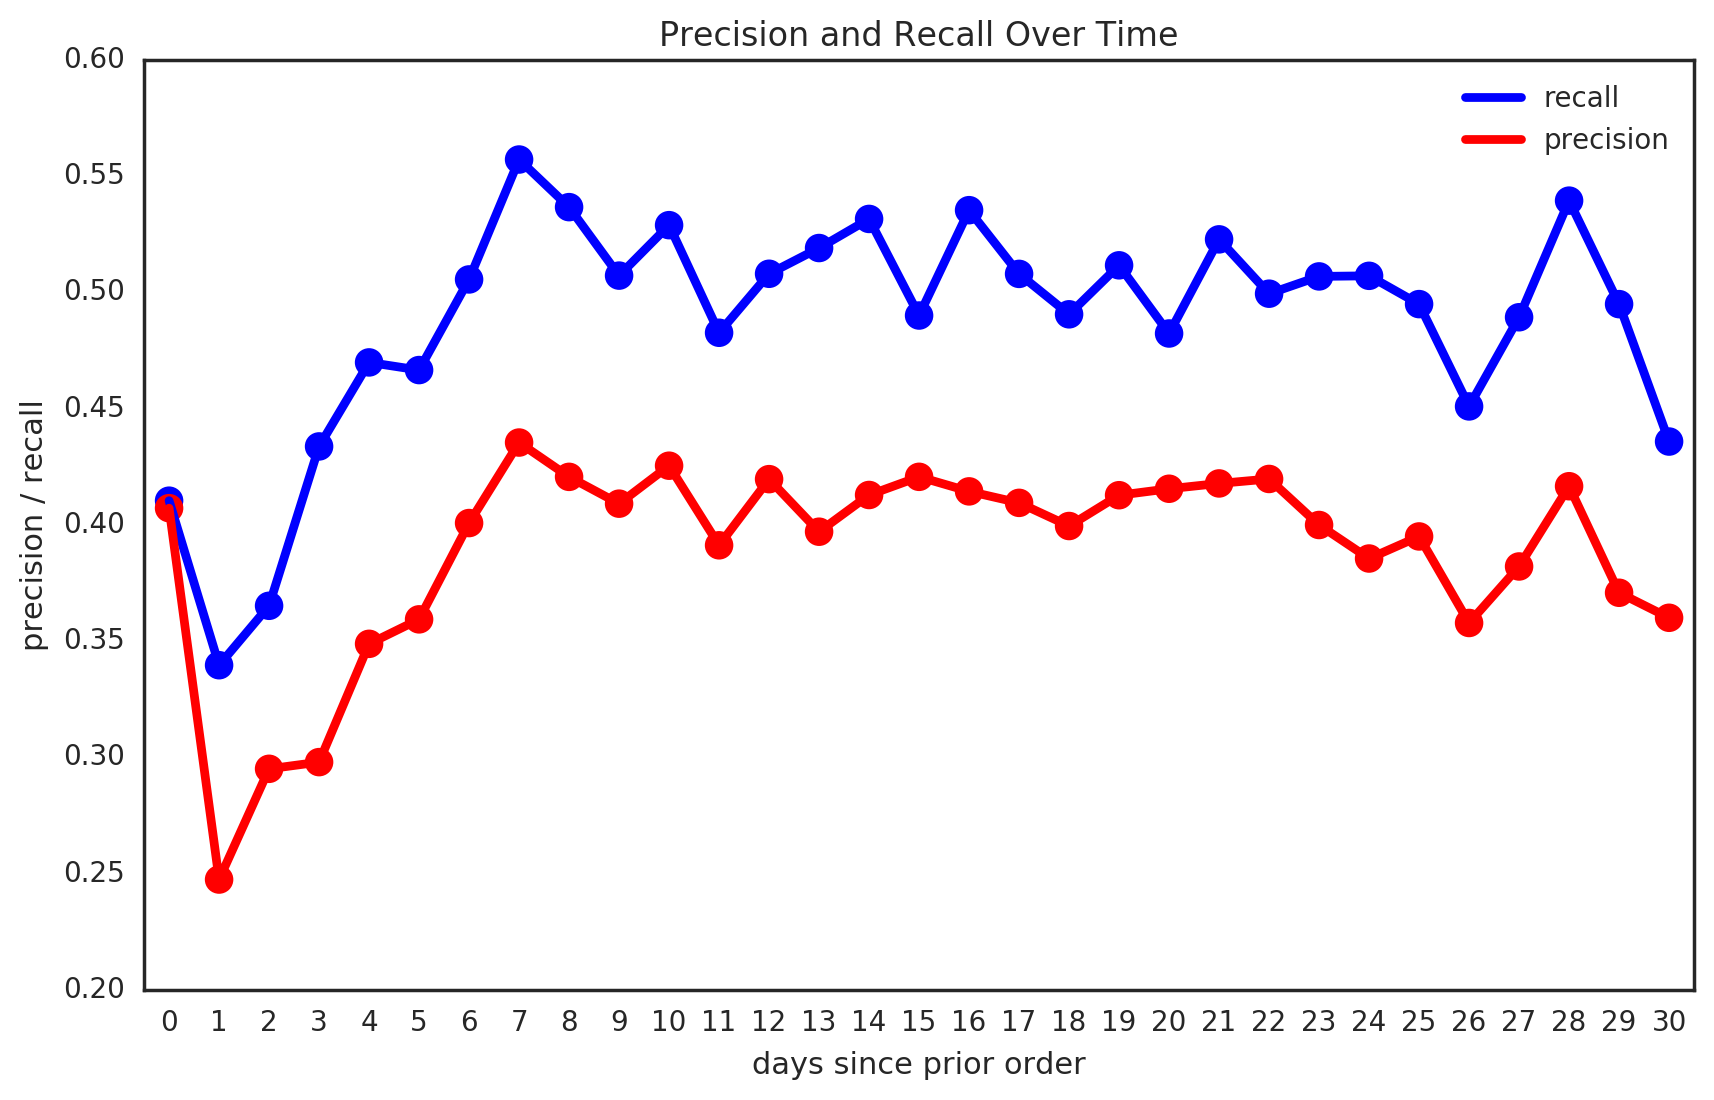

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
recall = sns.pointplot(y='recall',x='days_since_prior_order', color='blue',data=days_all, label='recall', ax=ax)
precision = sns.pointplot(y='precision',x='days_since_prior_order', color='red',data=days_all, label='precision', ax=ax)
ax.set(xlabel='days since prior order', ylabel='precision / recall',title='Precision and Recall Over Time')
ax.legend(handles=ax.lines[::len(days_all)+1], labels=["recall","precision"])
plt.show()

<a id="conclusion"></a>
# Conclusion

It's hard to establish a baseline for this prediction problem, but my model significantly outperforms a simple model that replicates customers' most recent order, generating lift in the f1 score of 1.23 (.383/.31) according to Kaggle's scoring function. My model excels in predicting products that are ordered often and consumed quickly. It performs poorly with products not meeting this criteria. 

Residual analysis demonstrates clear area for continued model improvement in identifying orders not containing reordered products, which EDA revealed are concentrated in users with few orders and especially at maximally near or far proximity to a previous order. Residual analysis lastly reveals that the model performs poorly for users making orders between 1-3 day following their last order.

To address the problem of identifying infrequently ordered products, I'll need to develop additional features. One option would be to try to discover patterns for some irregularly ordered items. Butter, for example, might consistently be reordered for many users after a fixed number of orders or days. To continue to improve predicting None orders, I could create a separate classifier for that purpose. Finally, there is the problem of inconsistent model performance for users making orders 1-3 days after their previous order, a consistent finding across both user groups and in every group of residuals I've reviewed. Predictions might likewise improve by classifying these users' orders separately.

That's all. Thank you reading!